In [1]:
import os; import subprocess

def detect_env():
    return 'colab' if 'content' in os.listdir('/') else 'IBM'
  
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))
  
if detect_env() == 'colab': root_folder = '/content'
elif detect_env() == 'IBM' : root_folder = '/root/Derakhshani/adversarial'
python_files_path = root_folder + '/nag-public'
if os.path.isdir(python_files_path):
  initial_dir = os.getcwd()
  os.chdir(python_files_path)
  run_shell_command('git pull')
  os.chdir(initial_dir)
else:
  os.chdir('/root/Derakhshani/adversarial')
  run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')

Already up-to-date.



In [ ]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import numpy as np
import sys; import os; import shutil

In [2]:
import sys
sys.path.append(python_files_path + '/NAG-11May-beforeDenoiser')

from nag_util import *
import nag_util
from environment import *
from visualization import *

env = create_env()
env.setup(cuda_index = 0)

In [4]:
gen_arch = "targeted"
# gen_arch = "non-targeted"

In [5]:
class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super().__init__()
    self.leak,self.sub,self.maxv = leak,sub,maxv

  def forward(self, x): 
    x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x.sub_(self.sub)
    if self.maxv is not None: x.clamp_max_(self.maxv)
    return x
  
class deconv_layer(nn.Module):
    def __init__(self, in_ch, out_ch, k_size = (4,4), s = (2,2), pad = (1,1), b = True, activation = True):
        super(deconv_layer, self).__init__()

        self.CT2d = nn.ConvTranspose2d(in_channels = in_ch,
                                  out_channels = out_ch,
                                  kernel_size = k_size,
                                  stride = s, 
                                  padding = pad,
                                  bias = b)
        self.BN2d = nn.BatchNorm2d(out_ch)
        
        self.activation = activation
        if self.activation:
            self.relu = GeneralRelu(0, 0.2, 5)
        
        self.weight_init()
    
    def forward(self, input):
        if self.activation:
            return self.relu(self.BN2d(self.CT2d(input)))
        else:
            return self.BN2d(self.CT2d(input))

    def weight_init(self):
        self.CT2d.weight.data.normal_(mean = 0, std = 0.02)
        self.CT2d.bias.data.fill_(0)


In [6]:
class deconv_layer(nn.Module):
    def __init__(self, in_ch, out_ch, k_size = (4,4), s = (2,2), pad = (1,1), b = True, activation = True):
        super(deconv_layer, self).__init__()

        self.CT2d = nn.ConvTranspose2d(in_channels = in_ch,
                                  out_channels = out_ch,
                                  kernel_size = k_size,
                                  stride = s, 
                                  padding = pad,
                                  bias = b)
        self.BN2d = nn.BatchNorm2d(out_ch)
        self.activation = activation

        self.weight_init()
    
    def forward(self, input):
        if self.activation:
            return F.relu(self.BN2d(self.CT2d(input)), inplace=True)
        else:
            return self.BN2d(self.CT2d(input))

    def weight_init(self):
        self.CT2d.weight.data.normal_(mean = 0, std = 0.02)
        self.CT2d.bias.data.fill_(0)

In [7]:
if gen_arch == "targeted":
  class Gen(nn.Module):
    def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
      super(Gen, self).__init__()

      self.bs = None
      self.z_dim = z_dim
      self.gf_dim = gf_dim
      self.y_dim = y_dim
      self.df_dim = df_dim
      self.image_shape = image_shape
      self.active_labels = (20,30)
      
      self.n_unit_coeffs = [10, 7, 4, 2, 1, 1, 1]
      self.n_units = [coeff * self.gf_dim for coeff in self.n_unit_coeffs]
      
      self.z_ = nn.Linear(self.z_dim, self.n_units[0] * 4 * 4, bias=True)
      self.z_.bias.data.fill_(0)
      self.BN_ = nn.BatchNorm2d(self.n_units[0])

      self.half = max(self.gf_dim // 2, 1) 
      self.quarter = max(self.gf_dim // 4, 1)
      self.eighth = max(self.gf_dim // 8, 1)
      # sixteenth = max(self.gf_dim // 16, 1)

      self.CT2d_1 = deconv_layer(self.n_units[0], self.n_units[1], k_size = (5,5), pad = (2,2))
      self.CT2d_2 = deconv_layer(self.n_units[1], self.n_units[2])    
      self.CT2d_3 = deconv_layer(self.n_units[2], self.n_units[3])
      self.CT2d_4 = deconv_layer(self.n_units[3], self.n_units[4])
      self.CT2d_5 = deconv_layer(self.n_units[4], self.n_units[5])
      self.CT2d_6 = deconv_layer(self.n_units[5], self.n_units[6])
      self.CT2d_7 = deconv_layer(self.n_units[6], 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

    def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
      h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
      h_input = torch.cat([h_input, h_input_z], dim = 1)
      output = deconv_layer(h_input)
      assert output.shape[2:] == (expected_output_size, expected_output_size), \
              "Unexpected output shape at randomized_deconv_layer. expected" + \
              "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
      return output

    def forward_z(self, z):
      self.bs = z.shape[0]

      h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
      assert h0.shape[2:] == (4, 4), "Unexpected shape, it shoud be (4,4)"

      h1 = self.CT2d_1(h0)
      h2 = self.CT2d_2(h1)
      h3 = self.CT2d_3(h2)
      h4 = self.CT2d_4(h3)
      h5 = self.CT2d_5(h4)
      h6 = self.CT2d_6(h5)
      h7 = self.CT2d_7(h6)
      
      
#       h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
#       h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
#       h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
#       h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
#       h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
#       h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
#       h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

      ksi = 10.0
      output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
      # this coeff scales the output to be appropriate for images that are 
      # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
      # interval)
      return output_coeff * torch.tanh(h7)

  #   # blind-selection
    def forward(self, inputs):
      self.bs = inputs.shape[0]

      benign_preds_onehot = arch(inputs)
      benign_preds = torch.argmax(benign_preds_onehot, dim = 1)

      z = torch.zeros([self.bs, 1000]).cuda()
      for i in range(self.bs):
        random_label = self.randint(self.active_labels[0], self.active_labels[1], exclude = benign_preds[i].item())
        z[i][random_label] = 1.

      z_out = self.forward_z(z)

      return z_out, None, None, inputs, benign_preds_onehot, z

  #   #second-best selection: made validation so much worse
  #   def forward(self, inputs):
  #     self.bs = inputs.shape[0]

  #     benign_preds_onehot = arch(inputs)
  #     target_preds = torch.topk(benign_preds_onehot, 2, dim = 1).indices[:, 1:]

  #     z = torch.zeros([self.bs, 1000]).cuda()
  #     for i in range(self.bs):
  #       z[i][target_preds[i]] = 1.

  #     z_out = self.forward_z(z)

  #     return z_out, None, None, inputs, benign_preds_onehot, z

  #    def forward(self, inputs):
  #     self.bs = inputs.shape[0]

  #     benign_preds_onehot = arch(inputs)
  #     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)

  #     z = torch.zeros([self.bs, 1000]).cuda()
  #     random_label = self.randint(0,1000, exclude = benign_preds.tolist())
  #     for i in range(self.bs):
  #       z[i][random_label] = 1.

  #     z_out = self.forward_z(z)

  #     return z_out, None, None, inputs, benign_preds_onehot, z

    @staticmethod
    def randint(low, high, exclude):
      if exclude >= low and exclude < high:
        temp = np.random.randint(low, high - 1)
        if temp >= exclude:
          temp = temp + 1
        return temp
      else:
        return np.random.randint(low, high)

    def forward_single_z(self, z):
      return self.forward_z(z[None]).squeeze()

    def generate_single_noise(self):
      z = torch.empty(self.z_dim).uniform_(-1,1).cuda()
      return self.forward_single_z(z)         

    def make_triplet_samples(self, z, margin, r2, r3):
      positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
      negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
      return positive_sample, negative_sample

    def random_vector_surface(self, shape, r = 1.):
      mat = torch.randn(size=shape).cuda()
      norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
      return (mat/norm) * r


    def random_vector_volume(self, shape, inner_r, outer_r):
      fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
      fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
      fraction.unsqueeze_(-1)
      return self.random_vector_surface(shape, 1) * fraction

    def make_z(self, in_shape):
      return torch.empty(in_shape).cuda().uniform_(-1,1)


In [8]:
# g = Gen(z_dim = 1000).cuda()
# t = torch.empty(1000).uniform_().cuda()
# g.forward_single_z(t).shape

In [9]:
if gen_arch == "non-targeted":
  class Gen(nn.Module):
    def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
      super(Gen, self).__init__()

      self.bs = None
      self.z_dim = z_dim
      self.gf_dim = gf_dim
      self.y_dim = y_dim
      self.df_dim = df_dim
      self.image_shape = image_shape

      self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
      self.z_.bias.data.fill_(0)
      self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

      self.half = max(self.gf_dim // 2, 1) 
      self.quarter = max(self.gf_dim // 4, 1)
      self.eighth = max(self.gf_dim // 8, 1)
      # sixteenth = max(self.gf_dim // 16, 1)

      self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
      self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
      self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
      self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
      self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
      self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
      self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

    def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
      h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
      h_input = torch.cat([h_input, h_input_z], dim = 1)
      output = deconv_layer(h_input)
      assert output.shape[2:] == (expected_output_size, expected_output_size), \
              "Unexpected output shape at randomized_deconv_layer. expected" + \
              "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
      return output

    def forward_z(self, z):
      self.bs = z.shape[0]

      h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
      assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

      h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
      h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
      h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
      h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
      h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
      h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
      h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

      ksi = 10.0
      output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
      # this coeff scales the output to be appropriate for images that are 
      # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
      # interval)
      return output_coeff * torch.tanh(h7)

    def forward(self, inputs):
      self.bs = inputs.shape[0]
      z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
      p, n = self.make_triplet_samples(z, 0.1, 0.1, 2.)

      z_out = self.forward_z(z)
#       p_out = self.forward_z(p)
#       n_out = self.forward_z(n)

#       return z_out, p_out, n_out, inputs, z
      return z_out, None, None, inputs, z

    def forward_single_z(self, z):
      return self.forward_z(z[None]).squeeze()

    def generate_single_noise(self):
      z = torch.empty(self.z_dim).uniform_(-1,1).cuda()
      return self.forward_single_z(z)


    def make_triplet_samples(self, z, margin, r2, r3):
      positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
      negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
      return positive_sample, negative_sample

    def random_vector_surface(self, shape, r = 1.):
      mat = torch.randn(size=shape).cuda()
      norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
      return (mat/norm) * r


    def random_vector_volume(self, shape, inner_r, outer_r):
      fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
      fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
      fraction.unsqueeze_(-1)
      return self.random_vector_surface(shape, 1) * fraction

    def make_z(self, in_shape):
      return torch.empty(in_shape).cuda().uniform_(-1,1)

In [10]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  inp = torch.log(x1)
  target = x2
  return F.kl_div(inp, target, reduction='batchmean')

def distrib_distance(x1, x2):
  x1 = tensorify(x1)
  x2 = tensorify(x2)
  x1 = x1 / torch.sum(x1)
  x2 = x2 / torch.sum(x2)
  return kl_distance(x1[None], x2[None])

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 * 100. / torch.sum(x1)
  x2 = x2 * 100. / torch.sum(x2)
  return torch.norm(x1 - x2, 2)

def distance_from_uniform(x):
  return distrib_distance(x, [1.] * len(x))

def wasserstein_distance(x1, x2):
  return torch.mean(x1 - x2)

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def l2_distance(x1, x2):
  return F.mse_loss(x1 * 10, x2 * 10)

def mse_loss(x1, x2):
  return F.mse_loss(x1, x2)

def cos_distance(x1, x2, dim = 1):
  return -1 * torch.mean(F.cosine_similarity(x1, x2, dim=dim))


def triplet_loss(anchor, positive, negative, distance_func, margin):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
  ap_dist = distance_func(anchor, positive)
  an_dist = distance_func(anchor, negative)

  triplet_loss.call_count += 1
  if triplet_loss.call_count % 200 == 0 : #and anchor.shape[1] == 1000:
#     print("a: ", end=""); print_big_vector(anchor[0])
#     print("p: ", end=""); print_big_vector(positive[0])
#     print("n: ", end=""); print_big_vector(negative[0])
    print("func:{}, ap_dist: {}, an_dist: {}".format(distance_func.__name__, ap_dist, an_dist))
    
  return torch.mean(F.relu(ap_dist - an_dist + margin))

triplet_loss.call_count = 0

In [11]:
# def diversity_loss(embeddings, z_s):
#   size = z_s.shape[0]
#   result = 0
#   for i in range(size):
#     for j in range(i+1, size):
# #       a = F.cosine_similarity(embeddings[i], embeddings[j], dim = 0)
# #       b = torch.norm(z_s[i] - z_s[j], 2, dim = 0)
# #       print('embeddings: ')
# #       print_big_vector(embeddings[i])
# #       print_big_vector(embeddings[j])
# #       print(f'a: {a}, b:{b}, multiple: {a*b}')
#       result += F.cosine_similarity(embeddings[i], embeddings[j], dim = 0) * \
#                 torch.norm(z_s[i] - z_s[j], 2, dim = 0)
#   n_pairs = (size * (size - 1)) / 2
#   mean = result / n_pairs 
# #   print(f'result {result}, n_pairs {n_pairs}, mean {mean}')
#   return mean
  

# # normalized with shuffling
# def diversity_loss(embeddings, deranged_embeddings, z_s, deranged_z_s):
#     cos_similarity = F.cosine_similarity(embeddings, deranged_embeddings)
#     z_distance = torch.norm(z_s - deranged_z_s, 2, dim = 1)
#     return torch.mean(cos_similarity * z_distance)
  
# # normalized with shuffling
# def diversity_loss(embeddings, z_s):
#     deranged_embeddings, deranged_z_s = derange(embeddings, z_s)
#     cos_similarity = F.cosine_similarity(embeddings, deranged_embeddings)
#     z_distance = torch.norm(z_s - deranged_z_s, dim = 1)
#     max_possible_z_distance = 6.3246
#     return torch.mean(cos_similarity * (z_distance/max_possible_z_distance))


def diversity_loss(input, target):
#   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
  if input.shape[0] != batch_size:
    print("input shape: ", input.shape)
    print("target shape: ", target.shape, "\n\n")
  return torch.mean(F.cosine_similarity(
    input.view([batch_size, -1]),
    target.view([batch_size, -1]), 
  ))


if gen_arch == 'non-targeted':
  def fool_loss(input, target):
    true_class = torch.argmax(target, dim=1).view(-1,1).long().cuda()
    target_probabilities = input.gather(1, true_class)
    epsilon = 1e-10
    result =  torch.mean(-1 * torch.log(1 - target_probabilities + epsilon))

    fool_loss.call_count += 1
    if fool_loss.call_count % 200 == 0:
      print("target probs {}, loss: {}: ".format(target_probabilities, result))

    return result

  fool_loss.call_count = 0

if gen_arch == 'targeted':
  def fool_loss(model_output, target_labels):
    target_labels = target_labels.view(-1, 1).long().cuda()
    target_probabilities = model_output.gather(1, target_labels)
    epsilon = 1e-10
    # highest possible fool_loss is - log(1e-10) == 23
    result = torch.mean(-1 * torch.log(target_probabilities + epsilon))

    fool_loss.call_count += 1
    if fool_loss.call_count % 200 == 0:
      print("target probs {}, loss: {}: ".format(target_probabilities, result))

    return result

  fool_loss.call_count = 0


def targeted_validation(gen_output, target):
  perturbations, _, _, clean_images, _, z = gen_output
  perturbed_images = clean_images + perturbations
  target_labels = torch.argmax(z, 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)
#   print('adv preds: ', adversary_preds.shape, adversary_preds)
#   print('target_labels: ', target_labels.shape, target_labels)
#   print('eq: ', (adversary_preds == target_labels))
  return (adversary_preds == target_labels).float().mean()
  

# # targeted 
# def validation(gen_output, target):
#   perturbations, _, _, clean_images, _, _ = gen_output
#   return validation_(perturbations, clean_images)

# # non-targeted
# def validation(gen_output, target):
#   perturbations, _, _, clean_images, _ = gen_output
#   return validation_(perturbations, clean_images)

# # general
def validation(gen_output, target):
  perturbations = gen_output[0]
  clean_images = gen_output[3]
  return validation_(perturbations, clean_images)

unfooled_histogram = np.array([0.] * 1000)
fooled_histogram = np.array([0.] * 1000)
valid_cnt = 0

def print_hist(unfooled, fooled):
  indexed = [(i, u) for i, u in enumerate(unfooled)]
  summarized = list(filter(lambda x: x[1] > 0.0, indexed))
  total = fooled + unfooled

  percent_total = [(i, 100. * u / (total[i] + 1e-10), total[i]) for i, u in enumerate(unfooled)]
  sorted_percent_total = sorted(percent_total, key =lambda x: x[1], reverse = True)

  print('\npercent_total: ')
  print(list(filter(lambda x: x[1] > 0.0, sorted_percent_total)))
  print('\n')
  
  return sorted_percent_total

def validation_(perturbations, clean_images):
  perturbed_images = clean_images + perturbations
  benign_preds = torch.argmax(arch(clean_images), 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)

  is_unfooled = (benign_preds == adversary_preds)
  for i , unfooled in enumerate(is_unfooled):
    if unfooled == 1:
      unfooled_histogram[benign_preds[i]] += 1
    else:
      fooled_histogram[benign_preds[i]] += 1
  
#   global valid_cnt
#   valid_cnt += 1
#   if valid_cnt % 10 == 0:
#     print_hist(unfooled_histogram, fooled_histogram)
    
  return (benign_preds != adversary_preds).float().mean()

In [12]:
if gen_arch == 'targeted':
  class FeatureLoss(nn.Module):
      def __name__(self):
        return "feature_loss"

      def __init__(self, dis, layers, layer_weights):
          super().__init__()

          # define generator here 
          self.dis = dis
          self.diversity_layers = layers
          self.hooks = hook_outputs(self.diversity_layers, detach=False)
          self.weights = layer_weights
          self.metric_names = ["fool_loss"] #+ [f"div_loss_{i}" for i in range(len(layers))] #maybe Gram
  #         self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)

      def make_features(self, x, clone=False):
          y = self.dis(x)
          return y, [(o.clone() if clone else o) for o in self.hooks.stored]

      def forward(self, inp, target):
        sigma_B, _, _, X_B, B_Y, z = inp

        X_A = X_B + sigma_B
  #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

        A_Y, A_feat = self.make_features(X_A)
  #       _, S_feat = self.make_features(X_S)

        chosen_labels = z.argmax(dim=1)
        fooling_loss =  fool_loss(A_Y, chosen_labels)

  #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
  #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

  #       self.losses = [fooling_loss] + weighted_diversity_losses
  #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

        self.losses = [fooling_loss]
        self.metrics = dict(zip(self.metric_names, [fooling_loss]))

        return sum(self.losses)

      def add_perturbation_shuffled(self, inp, perturbation):
  #       j = torch.randperm(inp.shape[0])
          j = derangement(inp.shape[0])
          return inp.add(perturbation[j])

In [13]:
def derange(*args):
  if len(args) == 0: raise ValueError('shuffle function needs atleast one argument')
  deranged_indexes = derangement(args[0].shape[0])
  if not all([args[0].shape[0] == arg.shape[0] for arg in args]): 
    raise ValueError('inputs to shuffle must all have the same 0th dimension')
  return [arg[deranged_indexes] for arg in args]

In [14]:
if gen_arch == 'non-targeted':
  class FeatureLoss(nn.Module):
      def __name__(self):
        return "feature_loss"

      def __init__(self, dis, layers, layer_weights):
          super().__init__()

          self.dis = dis
          self.diversity_layers = layers
          self.hooks = hook_outputs(self.diversity_layers, detach=False)
          self.weights = layer_weights

  #         self.metric_names = ["fool_loss"] + [f"div_loss_{i}" for i in range(len(layers))] + ['triplet_loss']# Maybe Gram
  #         self.metric_names = ["div_loss"] + ['triplet_loss']# Maybe Gram
          self.metric_names = ["fool_loss"] + ['div_loss']# Maybe Gram
          self.triplet_weight = 4.
          self.div_weight = 1.
          self.fooling_weight = 1.

      def make_features(self, x, clone=False):
          y = self.dis(x)
          return y, [(o.clone() if clone else o) for o in self.hooks.stored]

      # contrastive loss
      def forward(self, inp, target):
          sigma_B, sigma_pos, sigma_neg, X_B, z_B = inp

          deranged_perturbations, deranged_z_s = derange(sigma_B, z_B)

          X_A = X_B + sigma_B
          X_S = X_B + deranged_perturbations
#           X_A_pos = X_B + sigma_pos
#           X_A_neg = X_B + sigma_neg

          B_Y, _ = self.make_features(X_B)
          A_Y, A_feat = self.make_features(X_A)
          _, S_feat = self.make_features(X_S)
#           pos_softmax, _ = self.make_features(X_A_pos)
#           neg_softmax, _ = self.make_features(X_A_neg)

          raw_fooling_loss =  fool_loss(A_Y, B_Y)
          weighted_fooling_loss = self.fooling_weight * raw_fooling_loss

#           raw_diversity_loss = diversity_loss(A_feat[0], S_feat[0], z_B, deranged_z_s)
          raw_diversity_loss = diversity_loss(A_feat[0], S_feat[0])
          weighted_diversity_loss = raw_diversity_loss * self.div_weight

#           raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#           weighted_triplet_loss = raw_triplet_loss * self.triplet_weight

  #         self.losses = weighted_diversity_losses + [weighted_triplet_loss]
  #         raw_losses = raw_diversity_losses + [raw_triplet_loss]

          self.losses = [weighted_fooling_loss] + [weighted_diversity_loss] #+ [weighted_triplet_loss]
          raw_losses = [raw_fooling_loss] + [raw_diversity_loss] #+ [raw_triplet_loss]

  #         self.losses = [fooling_loss] + [weighted_triplet_loss]
  #         self.metrics = dict(zip(self.metric_names, [fooling_loss] + [raw_triplet_loss]))

          if len(self.metric_names) != len(raw_losses):
            raise Exception("length of metric names unequals length of losses")

          self.metrics = dict(zip(self.metric_names, raw_losses))
          return sum(self.losses)



  # #     triplet loss
  #     def forward(self, inp, target):
  #         sigma_B, sigma_pos, sigma_neg, X_B, _ = inp

  #         X_A = self.add_perturbation(X_B, sigma_B) 
  #         X_A_pos = self.add_perturbation(X_B, sigma_pos)
  #         X_A_neg = self.add_perturbation(X_B, sigma_neg) 
  #         X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

  # #         B_Y, _ = self.make_features(X_B)
  #         A_Y, A_feat = self.make_features(X_A)
  # #         _, S_feat = self.make_features(X_S)
  #         pos_softmax, _ = self.make_features(X_A_pos)
  #         neg_softmax, _ = self.make_features(X_A_neg)

  # #         raw_fooling_loss =  fool_loss(A_Y, B_Y)
  # #         weighted_fooling_loss = self.fooling_weight * raw_fooling_loss

  #         raw_diversity_losses = [diversity_loss(a_f, s_f, sigma_B, ) for a_f, s_f in zip(A_feat, S_feat)]
  #         weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
  #         raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
  #         weighted_triplet_loss = raw_triplet_loss * self.triplet_weight

  #         self.losses = weighted_diversity_losses + [weighted_triplet_loss]
  #         raw_losses = raw_diversity_losses + [raw_triplet_loss]

  # #         self.losses = [weighted_fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss]
  # #         raw_losses = [raw_fooling_loss] + raw_diversity_losses + [raw_triplet_loss]

  # #         self.losses = [fooling_loss] + [weighted_triplet_loss]
  # #         self.metrics = dict(zip(self.metric_names, [fooling_loss] + [raw_triplet_loss]))

  #         if len(self.metric_names) != len(raw_losses):
  #           raise Exception("length of metric names unequals length of losses")

  #         self.metrics = dict(zip(self.metric_names, raw_losses))
  #         return sum(self.losses)


  #     #use two types of triplet losses
  #     def forward(self, inp, target):
  #       sigma_B, sigma_pos, sigma_neg, X_B = inp

  #       X_A = self.add_perturbation(X_B, sigma_B) 
  #       X_A_pos = self.add_perturbation(X_B, sigma_pos)
  #       X_A_neg = self.add_perturbation(X_B, sigma_neg) 

  #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

  #       B_Y, _ = self.make_features(X_B)
  #       A_Y, A_feat = self.make_features(X_A)
  #       _, S_feat = self.make_features(X_S)
  #       pos_softmax, _ = self.make_features(X_A_pos)
  #       neg_softmax, _ = self.make_features(X_A_neg)

  #       fooling_loss =  fool_loss(A_Y, B_Y)

  #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
  #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

  #       raw_triplet_loss_sm = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
  #       weighted_triplet_loss_sm = raw_triplet_loss_sm * self.triplet_weight_sm

  #       raw_triplet_loss_noise = triplet_loss(sigma_B, sigma_pos, sigma_neg, l2_distance, 5.)
  #       weighted_triplet_loss_noise = raw_triplet_loss_noise * self.triplet_weight_noise

  #       self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise] 
  #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise]))

  #       return sum(self.losses)

  #     # just fooling and diversity
  #     def forward(self, inp, target):
  #       sigma_B, sigma_pos, sigma_neg, X_B = inp

  #       X_A = self.add_perturbation(X_B, sigma_B) 

  #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

  #       B_Y, _ = self.make_features(X_B)
  #       A_Y, A_feat = self.make_features(X_A)
  #       _, S_feat = self.make_features(X_S)

  #       fooling_loss =  fool_loss(A_Y, B_Y)

  #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
  #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

  #       self.losses = [fooling_loss] + weighted_diversity_losses
  #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

  #       return sum(self.losses)


      def add_perturbation_shuffled(self, inp, perturbation):
        j = derangement(inp.shape[0])
        return inp.add(perturbation[j])

In [15]:
import pandas as pd

def produce_summary(root_folder, n_files):
  def writeline(file, values, fmt_string):
    file.write(', '.join(fmt_string.format(v) for v in values) + '\n')
  
  last_rows = []
  for i in range(n_files):
    prefix = '/root/Derakhshani/adversarial/textual_notes/CSVs'
    df = pd.read_csv("{}/{}/{}.csv".format(prefix, root_folder, i))
    last_rows.append(df.iloc[-1][1:-1].values.tolist())
  
  last_rows = np.array(last_rows)
  
  labels = list(df.columns[1:-1])
  means = np.mean(last_rows, axis=0).tolist()
  outfile = open('{}/{}/summary.txt'.format(prefix, root_folder), 'w+')
  outfile.write('means: \n')
  writeline(outfile, labels, '{: >20}')
  writeline(outfile, means, '{: >20.3}')
  outfile.write('\n')
      
  operations = []
  for column in df.columns[1:-1]:
    if column in ['train_loss', 'valid_loss', 'fool_loss', 'triplet_loss'] or column[:8] == 'div_loss':
      operations.append('min')
    elif column in ['validation', 'targeted_validation', 'div_metric', 'entropy']:
      operations.append('max')
    else:
      raise ValueError('column {} is not recognized'.format(column))
    
  results = []
  indexes = []
  
  for i in range(len(operations)):
    values = last_rows[:, i]
    if operations[i] == 'max': operation = np.max
    elif operations[i] == 'min': operation = np.min
    result = operation(values)
    results.append(result)
    indexes.append(values.tolist().index(result))
  
  outfile.write('bests: \n')
  writeline(outfile, labels, '{: >20}')
  writeline(outfile, operations, '{: >20}')
  writeline(outfile, results, '{: >20.3}')
  writeline(outfile, indexes, '{: >20}')

In [16]:
from distutils import dir_util 

def investigate_initial_settings(n_settings, n_epochs, lr, wd, results_dir):
  os.mkdir(env.get_csv_dir() + results_dir)
  os.mkdir(env.get_models_dir() + results_dir)
  
  for setting_ind in range(n_settings):
    print(f"investigation no: {setting_ind}")
    learn = None; gen = None; gc.collect()
    gen = Gen(z_dim = z_dim)
    init_cnn(gen, True)
    
    tmp_csv_filename =  env.temp_csv_path + '/' + results_dir + '/' + str(setting_ind)
    csv_logger = partial(ImmediateCSVLogger, filename=tmp_csv_filename)

    if gen_arch == 'non-targeted':
      metrics = [validation]
    elif gen_arch == 'targeted':
      metrics = [validation, targeted_validation]
      
    learn = Learner(data, gen, loss_func = feat_loss, metrics=metrics, 
                    model_dir = env.get_learner_models_dir(), 
                    callback_fns=[DiversityMetric, LossMetrics, csv_logger])
    
    saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=model.__name__ + "-best")
    saver_every_epoch = SaveModelCallback(learn, every='epoch', name=model.__name__)

    learn.fit(n_epochs, lr=lr, wd = wd, callbacks=[saver_best, saver_every_epoch])
    
    shutil.copyfile(tmp_csv_filename + ".csv", env.get_csv_dir() + results_dir + '/' + str(setting_ind) + '.csv')
    
    model_dest = env.get_models_dir() + results_dir + '/' + str(setting_ind)
    os.mkdir(model_dest)
    dir_util.copy_tree(env.data_path/env.get_learner_models_dir(), model_dest)
    shutil.rmtree(env.data_path/env.get_learner_models_dir())  
    
  produce_summary(results_dir, n_settings)

In [17]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  gen = learn.model.eval()
  perturbations = [gen.generate_single_noise() for _ in range(n_perturbations)]
  learn.model.train(initial_training_mode)  
  return perturbations

def compute_prediction_histogram(learn, perturbation, verbose=False):
  pred_hist = [0] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 and verbose: print ("at batch no {}".format(batch_no))
    perturbed_batch = batch + perturbation[None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      pred_hist[pred] += 1
  return pred_hist


def compute_mean_prediction_histogram(learn, perturbations, verbose=False):
  pred_hist = torch.tensor([0] * 1000).detach_()
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 5 == 0 and verbose: print(f"at batch no {batch_no}")
    for j, perturbation in enumerate(perturbations):
      perturbed_batch = batch + perturbation[None]
      preds = arch(perturbed_batch).argmax(1)
      for pred in preds:
        pred_hist[pred] += 1
  pred_hist = pred_hist.float() / len(perturbations)
  return pred_hist.tolist()


def classes_needed_to_reach(percentage, hist):
  hist_sum = np.sum(hist)
  indexed_hist = [(i, hist_element) for i,hist_element in  
                          enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse = True)
  
  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = sorted_hist[n_used_classes]
    cumulative_percent += (hist_elem[1] / hist_sum) * 100.
    n_used_classes += 1

  return n_used_classes, sorted_hist

def diversity(learn, n_perturbations, percentage = 95, verbose = True):
  pred_histogram = compute_mean_prediction_histogram(
      learn, generate_perturbations(learn, n_perturbations), verbose
  )
  print("finished creating the prediction histogram")

  return classes_needed_to_reach(95, pred_histogram)

In [18]:
class DiversityMetric(LearnerCallback):
  _order = -20 # Needs to run before the recorder
  
  def __init__(self, learn):
    super().__init__(learn)
    self.average_over = 4
    self.n_perturbations = 10
    self.percentage = 95
  
  def on_train_begin(self, **kwargs):
    self.learn.recorder.add_metric_names(['div_metric', 'entropy'])
    
  def on_epoch_begin(self, **kwargs):
    global learn
    self.perturbations_list = [generate_perturbations(self.learn, self.n_perturbations) \
                          for _ in range(self.average_over)]
    self.pred_hist_list = [torch.tensor([0] * 1000).detach_() for _ in range(self.average_over)]
    
  def on_batch_end(self, last_output, train, **kwargs):
    if not train:
      images = last_output[3]; assert(images.shape[1:] == (3,224, 224))
      for perturbations, pred_hist in zip(self.perturbations_list, self.pred_hist_list):
        for j, perturbation in enumerate(perturbations):
          perturbed_batch = images + perturbation[None]
          preds = arch(perturbed_batch).argmax(1)
          for pred in preds:
            pred_hist[pred] += 1
  
  def on_epoch_end(self, last_metrics, **kwargs):
    for i in range(len(self.pred_hist_list)):
      self.pred_hist_list[i] = (self.pred_hist_list[i].float() / self.n_perturbations).tolist()
    
    div_metric_list = [classes_needed_to_reach(self.percentage, pred_hist)[0] \
                          for pred_hist in self.pred_hist_list]
    entropy_list = [entropy(pred_hist) for pred_hist in self.pred_hist_list]
    return add_metrics(last_metrics, [np.mean(div_metric_list), np.mean(entropy_list)])

In [19]:
class TargetedDiversityMetric(DiversityMetric):
    def __init__(self, n_perturbations, percentage):
      super().__init__(n_perturbations, percentage)

In [20]:
class FoolingWeightScheduler(LearnerCallback):
  def __init__(self, learn: Learner):
    super().__init__(learn)
    self.weights_history = []
    self.fooling_loss_history = []
  
  def get_metric_value(self, metric_name):
    for value, name in zip(self.learn.recorder.metrics[-1],self.learn.recorder.names[3:-1]):
      if name == metric_name:
        return value
    raise ValueError('Could not find {} metric.'.format(metric_name))
  
  def on_epoch_end(self, last_metrics, **kwargs):
    # history keeping
    self.weights_history.append((kwargs['epoch'], self.learn.loss_func.fooling_weight))
    
    # the actual functionality
    fooling_loss = self.get_metric_value('fool_loss')
    self.fooling_loss_history.append(fooling_loss)
    
    if len(self.weights_history) < 2:
      return
    
    if self.fooling_loss_history[-1] > self.fooling_loss_history[-2]:
      self.learn.loss_func.fooling_weight += 0.3    
      print('fooling weight increased to {} at the end of epoch {}'.format(
        self.learn.loss_func.fooling_weight, kwargs['epoch']))

In [21]:
# mode = 'sanity_check'
mode = 'normal'
# mode = 'div_metric_calc'

In [22]:
# model = models.resnet50
# model = models.resnet152
# model = models.vgg16_bn
model = torchvision.models.googlenet

In [23]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')
elif mode == "div_metric_calc":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
  env.load_test_dataset(str(env.data_path))

In [24]:
batch_size = 16
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder(valid=('test' if mode == 'div_metric_calc' else 'valid'))
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [25]:
if gen_arch == "non-targeted":
  z_dim = 10
elif gen_arch == "targeted":
  z_dim = 1000
  
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

layers = [
    arch.softmax
]

layer_weights = [1.] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [26]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [27]:
class LRAnneal(LearnerCallback):
  _order = -20 # Needs to run before the recorder
  
  def __init__(self, learn, final_value):
    super().__init__(learn)
    self.final_value = final_value
  
  def on_train_begin(self, **kwargs):
    self.initial_value = self.opt.lr
    self.learn.recorder.add_metric_names(['lr'])
  
  def on_epoch_end(self, epoch, n_epochs, last_metrics, **kwargs):
    self.opt.lr = annealing_linear(self.initial_value, self.final_value, float(epoch) / n_epochs)
    return add_metrics(last_metrics, self.opt.lr)
  
# class LRMonitor(LearnerCallBack):
#   def __init__(self, learn):
#     super().__init__(learn)
#     self.name = 'lr'
    
#   def on_epoch_end(self, last_metrics, **kwargs):
#     return add_metrics(last_metrics, self.opt.lr)

In [28]:
import os; import time

class FileControl(LearnerCallback):
    def __init__(self, learn, root_folder, gen):
      super().__init__(learn)
      self.root_folder = root_folder
      self.gen = gen
      
    def on_epoch_end(self, epoch, **kwargs):
      with open(self.root_folder + '/ctrl.txt', 'r') as control_file:
        control_data = json.loads(control_file.read())
      
      if str(epoch) in control_data:
        action = control_data[str(epoch)]
        self.epoch = epoch
        return self.perform_action(action)
        
    def perform_action(self, action):
      if action == 'stop':
        return {'stop_training': True}
      elif action == 'ask':
        print('prompted to ask for action at epoch {}:'.format(self.epoch))
        new_action = input()
        self.perform_action(new_action)
      elif action == 'ask_file':
        return self.ask_from_file()
      elif action == 'double_labels':
        self.gen.n_active_labels = min(self.gen.n_active_labels * 2, 1000)
        print('increased n_active_labels to {} at end of epoch {}'.format(self.gen.n_active_labels ,self.epoch))
      elif action == 'continue':
        return 
      else:
        print('invalid action: \"{}\". please enter a valid action:'.format(action))
        return self.perform_action(input())
    
    def ask_from_file(self):
      wait_file = open(self.root_folder + '/wait.txt', 'w')
      while True:
        if not os.path.isfile(self.root_folder + '/answer.txt'):
          open(self.root_folder + '/answer.txt', 'x')
        answers_file = open(self.root_folder + '/answer.txt', 'r')
        action = answers_file.read().strip()
        if action in ['stop', 'double_labels', 'continue']:
          print('action read: \"{}\"'.format(action))
          wait_file.close()
          os.remove(self.root_folder + '/wait.txt')
          return self.perform_action(action)
        else:
          wait_file.truncate(0)
          wait_file.write('invalid action \"{}\"\n'.format(action))
          wait_file.flush()
          time.sleep(10)

In [29]:
# class Object:
#   pass

# g = Object()
# g.n_active_labels = 2

# f = FileControl(learn, '/root/Derakhshani/adversarial/ctrl', g)

# f.on_epoch_end(0)

In [30]:
# env.save_filename = 'resnet50_65' #resnet50_64
# env.save_filename = 'resnet50_17'
env.save_filename = 'googlenet_28_labelset3x'


if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [31]:
learn = None; gen = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
gen = Gen(z_dim=z_dim)
init_cnn(gen, True)

if gen_arch == 'non-targeted':
  metrics = [validation]
elif gen_arch == 'targeted':
  metrics = [validation, targeted_validation]
    
learn = Learner(data, gen, loss_func = feat_loss, model_dir = env.get_learner_models_dir(),
                metrics=metrics, callback_fns=[DiversityMetric, LossMetrics, csv_logger])

# learn = Learner(data, Gen(z_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])

# load_starting_point(learn, model.__name__, z_dim)
# random_seed(42, True)

models_directory returned is:  models/567


In [32]:
# !cp "/content/gdrive/My Drive/DL/models/vgg16_12-last.pth"  "/content/"
# learn.load('/content/vgg16_12-last')

# load_filename = 'resnet50-11_39'
# load_filename = 'resnet50_startpoint_0'
# load_filename = 'googlenet_13_attempt5/googlenet_13_attempt5_29'
# load_filename = 'investigate_googlenet_3/0/googlenet_1'
# load_filename = 'vgg16_30/vgg16_30_69'
# load_filename = 'vgg16_12-last'
# load_filename = 'investigate_googlenet_4/1/googlenet_1'
load_filename = 'googlenet_28_labelset3/googlenet_28_labelset3_59'
# load_filename = 'googlenet_25_attempt2/googlenet_25_attempt2_399'
# load_filename = None

learn.load('/root/Derakhshani/adversarial/models/' + load_filename)

/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Gen. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type deconv_layer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (9000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02454379,n02454379,n02454379,n02454379
Path: /root/Derakhshani/adversarial/datasets/dataset;

Valid: LabelList (1000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02397096,n02090379,n01729977,n02268853
Path: /root/Derakhshani/adversarial/datasets/dataset;

Test: None, model=Gen(
  (z_): Linear(in_features=1000, out_features=10240, bias=True)
  (BN_): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (CT2d_1): deconv_layer(
    (CT2d): ConvTranspose2d(640, 448, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (BN2d): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (CT2d_2): deconv_layer(
    (CT2d): ConvTranspose2d

In [33]:
# learn.lr_find(1e-6, 100)
# learn.recorder.plot()

In [34]:
# results_dir = 'investigate_googlenet_3'
# investigate_initial_settings(4, 2, lr = 1e-2, wd = 0.0, results_dir = results_dir)

In [35]:
# shutil.rmtree(env.get_models_dir() + results_dir)
# shutil.rmtree(env.get_csv_dir() + results_dir)

In [36]:
# class WeightTuner(LearnerCallback):
#   def __init__(self, learn: Learner):
#     super().__init__(learn)
#     self.fooling_weight = learn.loss_func.fooling_weight
    
#   def on_epoch_begin(self, **kwargs):
#     fooling_rate = 
#     print("by how much to increase the fooling_weight? (current value: {})".format(fooling_rate))

In [37]:
class CyclicalLRScheduler(LearnerCallback):
  def __init__(self, learn, max_lr, min_lr, cycle_len):
    super().__init__(learn)
    self.max_lr = max_lr
    self.min_lr = min_lr
    self.cycle_len = cycle_len
    
  def on_train_begin(self, **kwargs):
    self.n_iter_per_epoch = len(self.learn.data.train_dl)
    self.cycle_len_iters = self.cycle_len * self.n_iter_per_epoch
    self.learn.opt.lr = self.min_lr
    
    
  def on_batch_end(self, iteration, train, **kwargs):
    if train:
      cycle_index = iteration % self.cycle_len_iters
      half_cycle_len = self.cycle_len_iters / 2

      if cycle_index < half_cycle_len:
        new_lr = float(self.max_lr - self.min_lr) / half_cycle_len * cycle_index + self.min_lr
      else:
        new_lr = float(self.min_lr - self.max_lr) / half_cycle_len * (cycle_index - half_cycle_len) + self.max_lr

#       print('iter: {}, lr: {}'.format(iteration, new_lr))
      self.opt.lr = new_lr

In [38]:
try:
  load_filename
except NameError:
  load_filename = None

print("the selected settings are : ")
print('''\tmode: {} \n\tnetw-under-attack: {} \n\tload filename: {} 
      \tsave filename: {}\n\tmetric names: {}\n\tgen arch: {}\n'''.format(
      mode, model.__name__, load_filename , env.save_filename, feat_loss.metric_names,
      gen_arch
))
print("please MAKE SURE that the config is correct.")

the selected settings are : 
	mode: normal 
	netw-under-attack: googlenet 
	load filename: googlenet_28_labelset3/googlenet_28_labelset3_59 
      	save filename: googlenet_28_labelset3x
	metric names: ['fool_loss']
	gen arch: targeted

please MAKE SURE that the config is correct.


In [39]:
# learn.lr_find(1e-6, 100)
# learn.recorder.plot()

In [40]:
learn.validate(learn.data.train_dl)


percent_total: 
[(293, 99.9999999988889, 9.0), (67, 90.90909090826446, 11.0), (640, 89.9999999991, 10.0), (123, 88.88888888790123, 9.0), (109, 85.71428571306123, 7.0), (612, 84.61538461473373, 13.0), (580, 83.33333333263889, 12.0), (800, 83.33333333263889, 12.0), (741, 83.33333333194444, 6.0), (924, 83.33333333194444, 6.0), (992, 81.81818181743802, 11.0), (37, 79.9999999992, 10.0), (298, 79.9999999984, 5.0), (84, 77.77777777691358, 9.0), (85, 77.77777777691358, 9.0), (214, 77.77777777691358, 9.0), (275, 77.77777777691358, 9.0), (284, 77.77777777691358, 9.0), (290, 77.77777777691358, 9.0), (340, 77.77777777691358, 9.0), (363, 77.77777777691358, 9.0), (406, 77.77777777691358, 9.0), (947, 77.77777777691358, 9.0), (955, 74.999999999375, 12.0), (81, 74.9999999990625, 8.0), (116, 74.9999999990625, 8.0), (197, 74.9999999990625, 8.0), (334, 74.9999999990625, 8.0), (393, 74.9999999990625, 8.0), (176, 74.999999998125, 4.0), (479, 74.999999998125, 4.0), (696, 74.999999998125, 4.0), (878, 74.9999

[(293, 99.9999999988889, 9.0),
 (67, 90.90909090826446, 11.0),
 (640, 89.9999999991, 10.0),
 (123, 88.88888888790123, 9.0),
 (109, 85.71428571306123, 7.0),
 (612, 84.61538461473373, 13.0),
 (580, 83.33333333263889, 12.0),
 (800, 83.33333333263889, 12.0),
 (741, 83.33333333194444, 6.0),
 (924, 83.33333333194444, 6.0),
 (992, 81.81818181743802, 11.0),
 (37, 79.9999999992, 10.0),
 (298, 79.9999999984, 5.0),
 (84, 77.77777777691358, 9.0),
 (85, 77.77777777691358, 9.0),
 (214, 77.77777777691358, 9.0),
 (275, 77.77777777691358, 9.0),
 (284, 77.77777777691358, 9.0),
 (290, 77.77777777691358, 9.0),
 (340, 77.77777777691358, 9.0),
 (363, 77.77777777691358, 9.0),
 (406, 77.77777777691358, 9.0),
 (947, 77.77777777691358, 9.0),
 (955, 74.999999999375, 12.0),
 (81, 74.9999999990625, 8.0),
 (116, 74.9999999990625, 8.0),
 (197, 74.9999999990625, 8.0),
 (334, 74.9999999990625, 8.0),
 (393, 74.9999999990625, 8.0),
 (176, 74.999999998125, 4.0),
 (479, 74.999999998125, 4.0),
 (696, 74.999999998125, 4.0),

In [41]:
hist = print_hist(unfooled_histogram, fooled_histogram)
with open('/root/Derakhshani/adversarial/temp/labelstudy/3.txt', 'w') as f:
  f.write(str(hist))


percent_total: 
[(293, 99.9999999988889, 9.0), (67, 90.90909090826446, 11.0), (640, 89.9999999991, 10.0), (123, 88.88888888790123, 9.0), (109, 85.71428571306123, 7.0), (612, 84.61538461473373, 13.0), (580, 83.33333333263889, 12.0), (800, 83.33333333263889, 12.0), (741, 83.33333333194444, 6.0), (924, 83.33333333194444, 6.0), (992, 81.81818181743802, 11.0), (37, 79.9999999992, 10.0), (298, 79.9999999984, 5.0), (84, 77.77777777691358, 9.0), (85, 77.77777777691358, 9.0), (214, 77.77777777691358, 9.0), (275, 77.77777777691358, 9.0), (284, 77.77777777691358, 9.0), (290, 77.77777777691358, 9.0), (340, 77.77777777691358, 9.0), (363, 77.77777777691358, 9.0), (406, 77.77777777691358, 9.0), (947, 77.77777777691358, 9.0), (955, 74.999999999375, 12.0), (81, 74.9999999990625, 8.0), (116, 74.9999999990625, 8.0), (197, 74.9999999990625, 8.0), (334, 74.9999999990625, 8.0), (393, 74.9999999990625, 8.0), (176, 74.999999998125, 4.0), (479, 74.999999998125, 4.0), (696, 74.999999998125, 4.0), (878, 74.9999

In [ ]:
# RUN SITE
if 'x' in env.save_filename and mode != 'sanity_check':
  raise ValueError('save_filename contains x')


saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)
# fooling_weight_scheduler = FoolingWeightScheduler(learn)
# lr_anneal = LRAnneal(learn, 1e-4)
# file_ctrl = FileControl(learn, '/root/Derakhshani/adversarial/ctrl', learn.model)
# cyclical_sched = CyclicalLRScheduler(learn, 3e-2, 6e-4, 4)

callbacks = [saver_best, saver_every_epoch]
# callbacks.append(lr_anneal)
# callbacks.append(fooling_weight_scheduler)
# callbacks.append(file_ctrl)
# callbacks.append(cyclical_sched)

learn.fit(60, lr=1e-2, wd = 0., callbacks=callbacks)

# with Hooks(gen, append_stats_normal) as hooks:
#   learn.fit(1, lr=5e-03, wd = 0., callbacks=[saver_best, saver_every_epoch])

# for i in range(10):
#   learn.fit_one_cycle(7, wd = 0.,max_lr=1., div_factor = 1000.) 

shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/env.get_learner_models_dir(), env.get_models_path())
shutil.rmtree(env.data_path/env.get_learner_models_dir())

epoch,train_loss,valid_loss,validation,targeted_validation,div_metric,entropy,fool_loss,time
0,7.121359,7.152056,0.584000,0.056000,476.750000,8.366093,7.152057,06:31
1,6.198088,6.560611,0.627000,0.086000,503.250000,8.536942,6.560612,06:29
2,5.888159,5.943223,0.619000,0.135000,497.250000,8.416161,5.943222,06:17
3,5.341006,5.613952,0.660000,0.190000,508.250000,8.317034,5.613951,06:09
4,5.165999,5.324699,0.651000,0.234000,479.500000,8.001426,5.324700,06:28
5,5.067543,5.185034,0.656000,0.261000,465.250000,8.055265,5.185034,06:22
6,4.782239,5.033641,0.656000,0.290000,473.250000,7.936302,5.033641,06:09
7,4.785642,4.949646,0.663000,0.312000,456.000000,7.898442,4.949646,06:21
8,4.482396,4.768007,0.676000,0.310000,441.750000,7.697337,4.768007,06:09
9,4.496236,4.680906,0.684000,0.339000,462.250000,7.973073,4.680906,06:13


target probs tensor([[4.2394e-04],
        [5.5571e-05],
        [1.0054e-06],
        [5.6095e-04],
        [2.1973e-04],
        [1.0242e-03],
        [8.5164e-03],
        [3.2188e-05],
        [7.4588e-06],
        [7.9248e-05],
        [2.8176e-02],
        [9.1001e-05],
        [1.1728e-04],
        [9.2826e-04],
        [7.5184e-03],
        [7.8703e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 8.360788345336914: 
target probs tensor([[3.1255e-04],
        [1.9276e-03],
        [2.2201e-05],
        [7.4497e-05],
        [2.4212e-03],
        [1.1243e-01],
        [3.6056e-03],
        [2.1928e-03],
        [2.7286e-03],
        [7.2952e-05],
        [3.4214e-04],
        [6.9484e-03],
        [1.9476e-04],
        [8.0077e-04],
        [6.6231e-01],
        [3.5639e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.68147087097168: 

percent_total: 
[(182, 99.999999995, 2.0), (292, 99.999999995, 2.0), (7, 99.99999999, 1.0), (20, 99.99999999, 1.0), (57, 99.9999

target probs tensor([[2.5279e-04],
        [3.1998e-05],
        [1.0913e-04],
        [1.3793e-02],
        [2.2445e-04],
        [1.3670e-05],
        [1.6583e-01],
        [1.3502e-03],
        [1.6602e-03],
        [7.8543e-03],
        [3.8580e-03],
        [4.1431e-05],
        [4.4925e-04],
        [9.8929e-02],
        [1.2901e-02],
        [8.1426e-03]], device='cuda:0'), loss: 6.632797718048096: 

percent_total: 
[(182, 99.999999995, 2.0), (231, 99.999999995, 2.0), (292, 99.999999995, 2.0), (349, 99.999999995, 2.0), (377, 99.999999995, 2.0), (544, 99.999999995, 2.0), (652, 99.999999995, 2.0), (868, 99.999999995, 2.0), (963, 99.999999995, 2.0), (0, 99.99999999, 1.0), (7, 99.99999999, 1.0), (8, 99.99999999, 1.0), (15, 99.99999999, 1.0), (20, 99.99999999, 1.0), (23, 99.99999999, 1.0), (24, 99.99999999, 1.0), (37, 99.99999999, 1.0), (41, 99.99999999, 1.0), (44, 99.99999999, 1.0), (53, 99.99999999, 1.0), (68, 99.99999999, 1.0), (72, 99.99999999, 1.0), (87, 99.99999999, 1.0), (90, 


percent_total: 
[(108, 99.999999995, 2.0), (182, 99.999999995, 2.0), (231, 99.999999995, 2.0), (292, 99.999999995, 2.0), (334, 99.999999995, 2.0), (349, 99.999999995, 2.0), (377, 99.999999995, 2.0), (489, 99.999999995, 2.0), (538, 99.999999995, 2.0), (544, 99.999999995, 2.0), (640, 99.999999995, 2.0), (652, 99.999999995, 2.0), (756, 99.999999995, 2.0), (843, 99.999999995, 2.0), (868, 99.999999995, 2.0), (962, 99.999999995, 2.0), (963, 99.999999995, 2.0), (0, 99.99999999, 1.0), (1, 99.99999999, 1.0), (7, 99.99999999, 1.0), (8, 99.99999999, 1.0), (15, 99.99999999, 1.0), (16, 99.99999999, 1.0), (17, 99.99999999, 1.0), (20, 99.99999999, 1.0), (23, 99.99999999, 1.0), (24, 99.99999999, 1.0), (25, 99.99999999, 1.0), (28, 99.99999999, 1.0), (33, 99.99999999, 1.0), (34, 99.99999999, 1.0), (37, 99.99999999, 1.0), (41, 99.99999999, 1.0), (44, 99.99999999, 1.0), (45, 99.99999999, 1.0), (53, 99.99999999, 1.0), (61, 99.99999999, 1.0), (63, 99.99999999, 1.0), (65, 99.99999999, 1.0), (67, 99.99999999

Better model found at epoch 0 with validation value: 0.5839999914169312.
target probs tensor([[3.9765e-04],
        [1.0407e-01],
        [3.4523e-05],
        [8.6646e-05],
        [8.1186e-03],
        [4.7141e-02],
        [8.3448e-04],
        [5.8334e-05],
        [4.5441e-02],
        [2.1557e-03],
        [2.6823e-03],
        [1.0898e-03],
        [4.3728e-01],
        [1.9521e-05],
        [1.2452e-03],
        [3.2452e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.424570083618164: 
target probs tensor([[1.6340e-01],
        [9.3341e-05],
        [8.7334e-01],
        [6.7691e-01],
        [1.6936e-04],
        [1.2551e-04],
        [7.6082e-03],
        [1.5273e-03],
        [1.2211e-02],
        [6.7893e-03],
        [1.5602e-03],
        [7.1851e-05],
        [4.5699e-04],
        [3.8382e-02],
        [1.0434e-02],
        [1.3394e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.223228931427002: 

percent_total: 
[(292, 99.9999999975, 4.0), (182, 99.9

target probs tensor([[2.2546e-02],
        [6.7747e-04],
        [4.4591e-04],
        [1.6123e-03],
        [2.2840e-02],
        [6.8217e-05],
        [1.4148e-04],
        [1.0489e-03],
        [2.5591e-06],
        [1.1113e-01],
        [1.4834e-03],
        [5.2546e-03],
        [8.6850e-02],
        [3.3147e-03],
        [6.7412e-06],
        [3.1793e-01]], device='cuda:0'), loss: 6.398214340209961: 

percent_total: 
[(292, 99.9999999975, 4.0), (108, 99.99999999666667, 3.0), (334, 99.99999999666667, 3.0), (652, 99.99999999666667, 3.0), (868, 99.99999999666667, 3.0), (0, 99.999999995, 2.0), (7, 99.999999995, 2.0), (15, 99.999999995, 2.0), (68, 99.999999995, 2.0), (87, 99.999999995, 2.0), (91, 99.999999995, 2.0), (99, 99.999999995, 2.0), (109, 99.999999995, 2.0), (134, 99.999999995, 2.0), (151, 99.999999995, 2.0), (183, 99.999999995, 2.0), (192, 99.999999995, 2.0), (204, 99.999999995, 2.0), (218, 99.999999995, 2.0), (222, 99.999999995, 2.0), (231, 99.999999995, 2.0), (232, 99.99999


percent_total: 
[(292, 99.9999999975, 4.0), (652, 99.9999999975, 4.0), (108, 99.99999999666667, 3.0), (231, 99.99999999666667, 3.0), (334, 99.99999999666667, 3.0), (756, 99.99999999666667, 3.0), (825, 99.99999999666667, 3.0), (868, 99.99999999666667, 3.0), (962, 99.99999999666667, 3.0), (0, 99.999999995, 2.0), (7, 99.999999995, 2.0), (8, 99.999999995, 2.0), (15, 99.999999995, 2.0), (24, 99.999999995, 2.0), (37, 99.999999995, 2.0), (68, 99.999999995, 2.0), (87, 99.999999995, 2.0), (91, 99.999999995, 2.0), (97, 99.999999995, 2.0), (99, 99.999999995, 2.0), (109, 99.999999995, 2.0), (132, 99.999999995, 2.0), (134, 99.999999995, 2.0), (139, 99.999999995, 2.0), (151, 99.999999995, 2.0), (158, 99.999999995, 2.0), (183, 99.999999995, 2.0), (192, 99.999999995, 2.0), (198, 99.999999995, 2.0), (204, 99.999999995, 2.0), (213, 99.999999995, 2.0), (218, 99.999999995, 2.0), (222, 99.999999995, 2.0), (232, 99.999999995, 2.0), (247, 99.999999995, 2.0), (249, 99.999999995, 2.0), (257, 99.999999995, 2.0


percent_total: 
[(292, 99.9999999975, 4.0), (652, 99.9999999975, 4.0), (868, 99.9999999975, 4.0), (108, 99.99999999666667, 3.0), (334, 99.99999999666667, 3.0), (489, 99.99999999666667, 3.0), (538, 99.99999999666667, 3.0), (640, 99.99999999666667, 3.0), (756, 99.99999999666667, 3.0), (825, 99.99999999666667, 3.0), (962, 99.99999999666667, 3.0), (0, 99.999999995, 2.0), (7, 99.999999995, 2.0), (8, 99.999999995, 2.0), (15, 99.999999995, 2.0), (23, 99.999999995, 2.0), (24, 99.999999995, 2.0), (37, 99.999999995, 2.0), (53, 99.999999995, 2.0), (68, 99.999999995, 2.0), (87, 99.999999995, 2.0), (91, 99.999999995, 2.0), (92, 99.999999995, 2.0), (97, 99.999999995, 2.0), (99, 99.999999995, 2.0), (109, 99.999999995, 2.0), (132, 99.999999995, 2.0), (134, 99.999999995, 2.0), (139, 99.999999995, 2.0), (146, 99.999999995, 2.0), (151, 99.999999995, 2.0), (158, 99.999999995, 2.0), (183, 99.999999995, 2.0), (186, 99.999999995, 2.0), (192, 99.999999995, 2.0), (198, 99.999999995, 2.0), (204, 99.999999995, 


percent_total: 
[(108, 99.9999999975, 4.0), (292, 99.9999999975, 4.0), (489, 99.9999999975, 4.0), (652, 99.9999999975, 4.0), (756, 99.9999999975, 4.0), (868, 99.9999999975, 4.0), (334, 99.99999999666667, 3.0), (538, 99.99999999666667, 3.0), (640, 99.99999999666667, 3.0), (825, 99.99999999666667, 3.0), (962, 99.99999999666667, 3.0), (0, 99.999999995, 2.0), (1, 99.999999995, 2.0), (7, 99.999999995, 2.0), (8, 99.999999995, 2.0), (15, 99.999999995, 2.0), (17, 99.999999995, 2.0), (23, 99.999999995, 2.0), (24, 99.999999995, 2.0), (33, 99.999999995, 2.0), (34, 99.999999995, 2.0), (37, 99.999999995, 2.0), (41, 99.999999995, 2.0), (45, 99.999999995, 2.0), (53, 99.999999995, 2.0), (65, 99.999999995, 2.0), (68, 99.999999995, 2.0), (87, 99.999999995, 2.0), (90, 99.999999995, 2.0), (91, 99.999999995, 2.0), (92, 99.999999995, 2.0), (97, 99.999999995, 2.0), (98, 99.999999995, 2.0), (99, 99.999999995, 2.0), (102, 99.999999995, 2.0), (105, 99.999999995, 2.0), (107, 99.999999995, 2.0), (109, 99.9999999


percent_total: 
[(108, 99.9999999975, 4.0), (292, 99.9999999975, 4.0), (334, 99.9999999975, 4.0), (489, 99.9999999975, 4.0), (538, 99.9999999975, 4.0), (640, 99.9999999975, 4.0), (652, 99.9999999975, 4.0), (756, 99.9999999975, 4.0), (868, 99.9999999975, 4.0), (962, 99.9999999975, 4.0), (825, 99.99999999666667, 3.0), (0, 99.999999995, 2.0), (1, 99.999999995, 2.0), (7, 99.999999995, 2.0), (8, 99.999999995, 2.0), (15, 99.999999995, 2.0), (17, 99.999999995, 2.0), (23, 99.999999995, 2.0), (24, 99.999999995, 2.0), (25, 99.999999995, 2.0), (33, 99.999999995, 2.0), (34, 99.999999995, 2.0), (37, 99.999999995, 2.0), (41, 99.999999995, 2.0), (45, 99.999999995, 2.0), (53, 99.999999995, 2.0), (61, 99.999999995, 2.0), (63, 99.999999995, 2.0), (65, 99.999999995, 2.0), (67, 99.999999995, 2.0), (68, 99.999999995, 2.0), (83, 99.999999995, 2.0), (86, 99.999999995, 2.0), (87, 99.999999995, 2.0), (88, 99.999999995, 2.0), (90, 99.999999995, 2.0), (91, 99.999999995, 2.0), (92, 99.999999995, 2.0), (97, 99.99

Better model found at epoch 1 with validation value: 0.6269999742507935.
target probs tensor([[8.6178e-03],
        [9.6743e-01],
        [1.4459e-03],
        [1.6141e-05],
        [2.8729e-04],
        [3.9224e-04],
        [1.9480e-03],
        [6.5617e-02],
        [6.1670e-05],
        [2.0174e-01],
        [1.7062e-03],
        [2.2211e-01],
        [6.2801e-03],
        [1.8197e-04],
        [6.2682e-01],
        [3.6417e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.679118633270264: 
target probs tensor([[4.2756e-04],
        [6.6458e-03],
        [1.8838e-01],
        [2.2169e-01],
        [3.2908e-05],
        [7.2421e-04],
        [1.5245e-02],
        [6.5837e-02],
        [1.8022e-01],
        [4.8889e-01],
        [7.4906e-05],
        [4.8944e-04],
        [9.4318e-01],
        [9.8366e-01],
        [9.8213e-01],
        [5.8094e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.074705600738525: 
target probs tensor([[6.1629e-03],
        [1.4127e-04]


percent_total: 
[(292, 99.99999999833334, 6.0), (108, 99.999999998, 5.0), (334, 99.999999998, 5.0), (652, 99.999999998, 5.0), (489, 99.9999999975, 4.0), (538, 99.9999999975, 4.0), (640, 99.9999999975, 4.0), (756, 99.9999999975, 4.0), (825, 99.9999999975, 4.0), (962, 99.9999999975, 4.0), (0, 99.99999999666667, 3.0), (7, 99.99999999666667, 3.0), (68, 99.99999999666667, 3.0), (99, 99.99999999666667, 3.0), (109, 99.99999999666667, 3.0), (134, 99.99999999666667, 3.0), (183, 99.99999999666667, 3.0), (192, 99.99999999666667, 3.0), (204, 99.99999999666667, 3.0), (218, 99.99999999666667, 3.0), (222, 99.99999999666667, 3.0), (247, 99.99999999666667, 3.0), (257, 99.99999999666667, 3.0), (267, 99.99999999666667, 3.0), (293, 99.99999999666667, 3.0), (294, 99.99999999666667, 3.0), (347, 99.99999999666667, 3.0), (361, 99.99999999666667, 3.0), (363, 99.99999999666667, 3.0), (365, 99.99999999666667, 3.0), (388, 99.99999999666667, 3.0), (392, 99.99999999666667, 3.0), (394, 99.99999999666667, 3.0), (395


percent_total: 
[(292, 99.99999999833334, 6.0), (108, 99.999999998, 5.0), (334, 99.999999998, 5.0), (652, 99.999999998, 5.0), (756, 99.999999998, 5.0), (825, 99.999999998, 5.0), (962, 99.999999998, 5.0), (489, 99.9999999975, 4.0), (538, 99.9999999975, 4.0), (640, 99.9999999975, 4.0), (0, 99.99999999666667, 3.0), (7, 99.99999999666667, 3.0), (15, 99.99999999666667, 3.0), (37, 99.99999999666667, 3.0), (68, 99.99999999666667, 3.0), (87, 99.99999999666667, 3.0), (91, 99.99999999666667, 3.0), (99, 99.99999999666667, 3.0), (109, 99.99999999666667, 3.0), (134, 99.99999999666667, 3.0), (151, 99.99999999666667, 3.0), (158, 99.99999999666667, 3.0), (183, 99.99999999666667, 3.0), (192, 99.99999999666667, 3.0), (198, 99.99999999666667, 3.0), (204, 99.99999999666667, 3.0), (213, 99.99999999666667, 3.0), (218, 99.99999999666667, 3.0), (222, 99.99999999666667, 3.0), (232, 99.99999999666667, 3.0), (247, 99.99999999666667, 3.0), (249, 99.99999999666667, 3.0), (257, 99.99999999666667, 3.0), (267, 99.99


percent_total: 
[(292, 99.99999999833334, 6.0), (652, 99.99999999833334, 6.0), (108, 99.999999998, 5.0), (334, 99.999999998, 5.0), (489, 99.999999998, 5.0), (538, 99.999999998, 5.0), (640, 99.999999998, 5.0), (756, 99.999999998, 5.0), (825, 99.999999998, 5.0), (962, 99.999999998, 5.0), (0, 99.99999999666667, 3.0), (7, 99.99999999666667, 3.0), (8, 99.99999999666667, 3.0), (15, 99.99999999666667, 3.0), (23, 99.99999999666667, 3.0), (37, 99.99999999666667, 3.0), (68, 99.99999999666667, 3.0), (87, 99.99999999666667, 3.0), (91, 99.99999999666667, 3.0), (92, 99.99999999666667, 3.0), (99, 99.99999999666667, 3.0), (109, 99.99999999666667, 3.0), (132, 99.99999999666667, 3.0), (134, 99.99999999666667, 3.0), (139, 99.99999999666667, 3.0), (146, 99.99999999666667, 3.0), (151, 99.99999999666667, 3.0), (158, 99.99999999666667, 3.0), (183, 99.99999999666667, 3.0), (186, 99.99999999666667, 3.0), (192, 99.99999999666667, 3.0), (198, 99.99999999666667, 3.0), (204, 99.99999999666667, 3.0), (213, 99.9999


percent_total: 
[(108, 99.99999999833334, 6.0), (292, 99.99999999833334, 6.0), (489, 99.99999999833334, 6.0), (652, 99.99999999833334, 6.0), (334, 99.999999998, 5.0), (538, 99.999999998, 5.0), (640, 99.999999998, 5.0), (756, 99.999999998, 5.0), (825, 99.999999998, 5.0), (962, 99.999999998, 5.0), (0, 99.99999999666667, 3.0), (1, 99.99999999666667, 3.0), (7, 99.99999999666667, 3.0), (8, 99.99999999666667, 3.0), (15, 99.99999999666667, 3.0), (17, 99.99999999666667, 3.0), (23, 99.99999999666667, 3.0), (33, 99.99999999666667, 3.0), (34, 99.99999999666667, 3.0), (37, 99.99999999666667, 3.0), (41, 99.99999999666667, 3.0), (53, 99.99999999666667, 3.0), (65, 99.99999999666667, 3.0), (68, 99.99999999666667, 3.0), (87, 99.99999999666667, 3.0), (91, 99.99999999666667, 3.0), (92, 99.99999999666667, 3.0), (98, 99.99999999666667, 3.0), (99, 99.99999999666667, 3.0), (102, 99.99999999666667, 3.0), (105, 99.99999999666667, 3.0), (109, 99.99999999666667, 3.0), (113, 99.99999999666667, 3.0), (132, 99.999


percent_total: 
[(108, 99.99999999833334, 6.0), (292, 99.99999999833334, 6.0), (489, 99.99999999833334, 6.0), (538, 99.99999999833334, 6.0), (652, 99.99999999833334, 6.0), (756, 99.99999999833334, 6.0), (962, 99.99999999833334, 6.0), (334, 99.999999998, 5.0), (640, 99.999999998, 5.0), (825, 99.999999998, 5.0), (0, 99.99999999666667, 3.0), (1, 99.99999999666667, 3.0), (7, 99.99999999666667, 3.0), (8, 99.99999999666667, 3.0), (15, 99.99999999666667, 3.0), (17, 99.99999999666667, 3.0), (23, 99.99999999666667, 3.0), (25, 99.99999999666667, 3.0), (33, 99.99999999666667, 3.0), (34, 99.99999999666667, 3.0), (37, 99.99999999666667, 3.0), (41, 99.99999999666667, 3.0), (45, 99.99999999666667, 3.0), (53, 99.99999999666667, 3.0), (65, 99.99999999666667, 3.0), (68, 99.99999999666667, 3.0), (83, 99.99999999666667, 3.0), (86, 99.99999999666667, 3.0), (87, 99.99999999666667, 3.0), (91, 99.99999999666667, 3.0), (92, 99.99999999666667, 3.0), (98, 99.99999999666667, 3.0), (99, 99.99999999666667, 3.0), (

target probs tensor([[1.2982e-02],
        [9.4699e-04],
        [7.4395e-01],
        [4.2694e-04],
        [1.5064e-01],
        [8.8558e-03],
        [5.5464e-03],
        [4.5971e-03],
        [1.2957e-03],
        [5.1925e-02],
        [1.0620e-01],
        [1.6812e-01],
        [1.1186e-03],
        [6.0576e-06],
        [2.1351e-03],
        [1.4528e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.817368030548096: 
target probs tensor([[5.7489e-03],
        [2.0659e-03],
        [1.1932e-01],
        [8.5536e-03],
        [1.8838e-02],
        [1.9520e-05],
        [1.5047e-04],
        [1.8207e-02],
        [4.9145e-04],
        [3.6325e-03],
        [6.2187e-04],
        [7.7100e-05],
        [2.1818e-05],
        [3.0308e-04],
        [3.2943e-03],
        [6.1437e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.742867469787598: 
target probs tensor([[2.3051e-02],
        [2.9354e-01],
        [1.4403e-04],
        [4.5052e-05],
        [6.7098e-02],
     


percent_total: 
[(292, 99.99999999875, 8.0), (652, 99.99999999857143, 7.0), (108, 99.99999999833334, 6.0), (334, 99.99999999833334, 6.0), (489, 99.99999999833334, 6.0), (538, 99.99999999833334, 6.0), (640, 99.99999999833334, 6.0), (756, 99.99999999833334, 6.0), (825, 99.99999999833334, 6.0), (962, 99.99999999833334, 6.0), (7, 99.9999999975, 4.0), (68, 99.9999999975, 4.0), (99, 99.9999999975, 4.0), (109, 99.9999999975, 4.0), (134, 99.9999999975, 4.0), (192, 99.9999999975, 4.0), (218, 99.9999999975, 4.0), (222, 99.9999999975, 4.0), (257, 99.9999999975, 4.0), (267, 99.9999999975, 4.0), (293, 99.9999999975, 4.0), (294, 99.9999999975, 4.0), (361, 99.9999999975, 4.0), (363, 99.9999999975, 4.0), (392, 99.9999999975, 4.0), (409, 99.9999999975, 4.0), (410, 99.9999999975, 4.0), (425, 99.9999999975, 4.0), (431, 99.9999999975, 4.0), (483, 99.9999999975, 4.0), (507, 99.9999999975, 4.0), (608, 99.9999999975, 4.0), (609, 99.9999999975, 4.0), (646, 99.9999999975, 4.0), (670, 99.9999999975, 4.0), (732


percent_total: 
[(292, 99.99999999875, 8.0), (108, 99.99999999857143, 7.0), (334, 99.99999999857143, 7.0), (652, 99.99999999857143, 7.0), (825, 99.99999999857143, 7.0), (489, 99.99999999833334, 6.0), (538, 99.99999999833334, 6.0), (640, 99.99999999833334, 6.0), (756, 99.99999999833334, 6.0), (962, 99.99999999833334, 6.0), (0, 99.9999999975, 4.0), (7, 99.9999999975, 4.0), (15, 99.9999999975, 4.0), (37, 99.9999999975, 4.0), (68, 99.9999999975, 4.0), (87, 99.9999999975, 4.0), (91, 99.9999999975, 4.0), (99, 99.9999999975, 4.0), (109, 99.9999999975, 4.0), (134, 99.9999999975, 4.0), (151, 99.9999999975, 4.0), (183, 99.9999999975, 4.0), (192, 99.9999999975, 4.0), (218, 99.9999999975, 4.0), (222, 99.9999999975, 4.0), (232, 99.9999999975, 4.0), (249, 99.9999999975, 4.0), (257, 99.9999999975, 4.0), (267, 99.9999999975, 4.0), (275, 99.9999999975, 4.0), (293, 99.9999999975, 4.0), (294, 99.9999999975, 4.0), (314, 99.9999999975, 4.0), (316, 99.9999999975, 4.0), (327, 99.9999999975, 4.0), (347, 99.9


percent_total: 
[(292, 99.99999999875, 8.0), (652, 99.99999999875, 8.0), (108, 99.99999999857143, 7.0), (334, 99.99999999857143, 7.0), (756, 99.99999999857143, 7.0), (825, 99.99999999857143, 7.0), (489, 99.99999999833334, 6.0), (640, 99.99999999833334, 6.0), (0, 99.9999999975, 4.0), (7, 99.9999999975, 4.0), (8, 99.9999999975, 4.0), (15, 99.9999999975, 4.0), (23, 99.9999999975, 4.0), (37, 99.9999999975, 4.0), (68, 99.9999999975, 4.0), (87, 99.9999999975, 4.0), (91, 99.9999999975, 4.0), (92, 99.9999999975, 4.0), (99, 99.9999999975, 4.0), (109, 99.9999999975, 4.0), (132, 99.9999999975, 4.0), (134, 99.9999999975, 4.0), (139, 99.9999999975, 4.0), (151, 99.9999999975, 4.0), (183, 99.9999999975, 4.0), (186, 99.9999999975, 4.0), (192, 99.9999999975, 4.0), (213, 99.9999999975, 4.0), (218, 99.9999999975, 4.0), (222, 99.9999999975, 4.0), (228, 99.9999999975, 4.0), (232, 99.9999999975, 4.0), (249, 99.9999999975, 4.0), (257, 99.9999999975, 4.0), (267, 99.9999999975, 4.0), (275, 99.9999999975, 4.0)


percent_total: 
[(108, 99.99999999875, 8.0), (292, 99.99999999875, 8.0), (652, 99.99999999875, 8.0), (334, 99.99999999857143, 7.0), (489, 99.99999999857143, 7.0), (640, 99.99999999857143, 7.0), (756, 99.99999999857143, 7.0), (825, 99.99999999857143, 7.0), (0, 99.9999999975, 4.0), (7, 99.9999999975, 4.0), (8, 99.9999999975, 4.0), (15, 99.9999999975, 4.0), (17, 99.9999999975, 4.0), (23, 99.9999999975, 4.0), (33, 99.9999999975, 4.0), (37, 99.9999999975, 4.0), (41, 99.9999999975, 4.0), (53, 99.9999999975, 4.0), (68, 99.9999999975, 4.0), (87, 99.9999999975, 4.0), (91, 99.9999999975, 4.0), (92, 99.9999999975, 4.0), (98, 99.9999999975, 4.0), (99, 99.9999999975, 4.0), (102, 99.9999999975, 4.0), (109, 99.9999999975, 4.0), (132, 99.9999999975, 4.0), (134, 99.9999999975, 4.0), (139, 99.9999999975, 4.0), (146, 99.9999999975, 4.0), (151, 99.9999999975, 4.0), (163, 99.9999999975, 4.0), (171, 99.9999999975, 4.0), (183, 99.9999999975, 4.0), (186, 99.9999999975, 4.0), (192, 99.9999999975, 4.0), (213, 


percent_total: 
[(108, 99.99999999875, 8.0), (292, 99.99999999875, 8.0), (489, 99.99999999875, 8.0), (652, 99.99999999875, 8.0), (756, 99.99999999875, 8.0), (334, 99.99999999857143, 7.0), (640, 99.99999999857143, 7.0), (825, 99.99999999857143, 7.0), (0, 99.9999999975, 4.0), (7, 99.9999999975, 4.0), (8, 99.9999999975, 4.0), (15, 99.9999999975, 4.0), (17, 99.9999999975, 4.0), (23, 99.9999999975, 4.0), (25, 99.9999999975, 4.0), (33, 99.9999999975, 4.0), (34, 99.9999999975, 4.0), (37, 99.9999999975, 4.0), (41, 99.9999999975, 4.0), (45, 99.9999999975, 4.0), (53, 99.9999999975, 4.0), (68, 99.9999999975, 4.0), (83, 99.9999999975, 4.0), (86, 99.9999999975, 4.0), (87, 99.9999999975, 4.0), (91, 99.9999999975, 4.0), (92, 99.9999999975, 4.0), (98, 99.9999999975, 4.0), (99, 99.9999999975, 4.0), (102, 99.9999999975, 4.0), (105, 99.9999999975, 4.0), (107, 99.9999999975, 4.0), (109, 99.9999999975, 4.0), (132, 99.9999999975, 4.0), (134, 99.9999999975, 4.0), (139, 99.9999999975, 4.0), (140, 99.99999999


percent_total: 
[(108, 99.99999999875, 8.0), (292, 99.99999999875, 8.0), (334, 99.99999999875, 8.0), (489, 99.99999999875, 8.0), (640, 99.99999999875, 8.0), (652, 99.99999999875, 8.0), (756, 99.99999999875, 8.0), (825, 99.99999999857143, 7.0), (0, 99.9999999975, 4.0), (7, 99.9999999975, 4.0), (8, 99.9999999975, 4.0), (15, 99.9999999975, 4.0), (17, 99.9999999975, 4.0), (23, 99.9999999975, 4.0), (25, 99.9999999975, 4.0), (28, 99.9999999975, 4.0), (33, 99.9999999975, 4.0), (34, 99.9999999975, 4.0), (37, 99.9999999975, 4.0), (41, 99.9999999975, 4.0), (42, 99.9999999975, 4.0), (45, 99.9999999975, 4.0), (46, 99.9999999975, 4.0), (53, 99.9999999975, 4.0), (61, 99.9999999975, 4.0), (67, 99.9999999975, 4.0), (68, 99.9999999975, 4.0), (77, 99.9999999975, 4.0), (83, 99.9999999975, 4.0), (86, 99.9999999975, 4.0), (87, 99.9999999975, 4.0), (88, 99.9999999975, 4.0), (91, 99.9999999975, 4.0), (92, 99.9999999975, 4.0), (98, 99.9999999975, 4.0), (99, 99.9999999975, 4.0), (102, 99.9999999975, 4.0), (10

Better model found at epoch 3 with validation value: 0.6600000262260437.
target probs tensor([[7.6903e-03],
        [4.4489e-01],
        [1.1774e-04],
        [9.8780e-03],
        [2.4561e-05],
        [2.0528e-01],
        [5.4381e-01],
        [5.4749e-01],
        [2.4839e-04],
        [4.7110e-01],
        [1.8797e-03],
        [9.5485e-05],
        [4.7465e-05],
        [4.9144e-04],
        [4.9017e-04],
        [7.0535e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.611822128295898: 
target probs tensor([[4.9092e-05],
        [4.7617e-02],
        [1.3397e-02],
        [7.3778e-01],
        [5.3810e-04],
        [3.8058e-05],
        [8.4112e-04],
        [3.0114e-01],
        [1.3951e-03],
        [8.9070e-01],
        [2.0303e-03],
        [3.8167e-02],
        [2.4988e-02],
        [1.6687e-02],
        [3.6841e-04],
        [3.2437e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.215399742126465: 
target probs tensor([[2.0727e-01],
        [8.6188e-04]


percent_total: 
[(292, 99.999999999, 10.0), (108, 99.9999999988889, 9.0), (334, 99.9999999988889, 9.0), (652, 99.9999999988889, 9.0), (489, 99.99999999875, 8.0), (640, 99.99999999875, 8.0), (756, 99.99999999875, 8.0), (825, 99.99999999875, 8.0), (0, 99.999999998, 5.0), (7, 99.999999998, 5.0), (15, 99.999999998, 5.0), (68, 99.999999998, 5.0), (87, 99.999999998, 5.0), (91, 99.999999998, 5.0), (99, 99.999999998, 5.0), (109, 99.999999998, 5.0), (134, 99.999999998, 5.0), (151, 99.999999998, 5.0), (183, 99.999999998, 5.0), (192, 99.999999998, 5.0), (218, 99.999999998, 5.0), (222, 99.999999998, 5.0), (257, 99.999999998, 5.0), (267, 99.999999998, 5.0), (275, 99.999999998, 5.0), (293, 99.999999998, 5.0), (294, 99.999999998, 5.0), (314, 99.999999998, 5.0), (316, 99.999999998, 5.0), (347, 99.999999998, 5.0), (361, 99.999999998, 5.0), (363, 99.999999998, 5.0), (388, 99.999999998, 5.0), (392, 99.999999998, 5.0), (395, 99.999999998, 5.0), (409, 99.999999998, 5.0), (410, 99.999999998, 5.0), (415, 99


percent_total: 
[(292, 99.999999999, 10.0), (652, 99.999999999, 10.0), (108, 99.9999999988889, 9.0), (334, 99.9999999988889, 9.0), (825, 99.9999999988889, 9.0), (489, 99.99999999875, 8.0), (640, 99.99999999875, 8.0), (0, 99.999999998, 5.0), (7, 99.999999998, 5.0), (8, 99.999999998, 5.0), (15, 99.999999998, 5.0), (23, 99.999999998, 5.0), (37, 99.999999998, 5.0), (68, 99.999999998, 5.0), (87, 99.999999998, 5.0), (91, 99.999999998, 5.0), (99, 99.999999998, 5.0), (109, 99.999999998, 5.0), (134, 99.999999998, 5.0), (139, 99.999999998, 5.0), (151, 99.999999998, 5.0), (183, 99.999999998, 5.0), (192, 99.999999998, 5.0), (213, 99.999999998, 5.0), (218, 99.999999998, 5.0), (222, 99.999999998, 5.0), (249, 99.999999998, 5.0), (257, 99.999999998, 5.0), (267, 99.999999998, 5.0), (275, 99.999999998, 5.0), (291, 99.999999998, 5.0), (293, 99.999999998, 5.0), (294, 99.999999998, 5.0), (314, 99.999999998, 5.0), (316, 99.999999998, 5.0), (330, 99.999999998, 5.0), (347, 99.999999998, 5.0), (355, 99.999999


percent_total: 
[(292, 99.999999999, 10.0), (652, 99.999999999, 10.0), (108, 99.9999999988889, 9.0), (334, 99.9999999988889, 9.0), (489, 99.9999999988889, 9.0), (640, 99.9999999988889, 9.0), (825, 99.9999999988889, 9.0), (0, 99.999999998, 5.0), (7, 99.999999998, 5.0), (8, 99.999999998, 5.0), (15, 99.999999998, 5.0), (23, 99.999999998, 5.0), (37, 99.999999998, 5.0), (53, 99.999999998, 5.0), (68, 99.999999998, 5.0), (87, 99.999999998, 5.0), (91, 99.999999998, 5.0), (98, 99.999999998, 5.0), (99, 99.999999998, 5.0), (109, 99.999999998, 5.0), (134, 99.999999998, 5.0), (139, 99.999999998, 5.0), (146, 99.999999998, 5.0), (151, 99.999999998, 5.0), (183, 99.999999998, 5.0), (186, 99.999999998, 5.0), (192, 99.999999998, 5.0), (213, 99.999999998, 5.0), (218, 99.999999998, 5.0), (222, 99.999999998, 5.0), (228, 99.999999998, 5.0), (249, 99.999999998, 5.0), (252, 99.999999998, 5.0), (257, 99.999999998, 5.0), (267, 99.999999998, 5.0), (275, 99.999999998, 5.0), (281, 99.999999998, 5.0), (291, 99.9999


percent_total: 
[(108, 99.999999999, 10.0), (292, 99.999999999, 10.0), (489, 99.999999999, 10.0), (652, 99.999999999, 10.0), (334, 99.9999999988889, 9.0), (640, 99.9999999988889, 9.0), (825, 99.9999999988889, 9.0), (0, 99.999999998, 5.0), (7, 99.999999998, 5.0), (8, 99.999999998, 5.0), (15, 99.999999998, 5.0), (23, 99.999999998, 5.0), (25, 99.999999998, 5.0), (33, 99.999999998, 5.0), (34, 99.999999998, 5.0), (37, 99.999999998, 5.0), (41, 99.999999998, 5.0), (45, 99.999999998, 5.0), (53, 99.999999998, 5.0), (68, 99.999999998, 5.0), (86, 99.999999998, 5.0), (87, 99.999999998, 5.0), (91, 99.999999998, 5.0), (98, 99.999999998, 5.0), (99, 99.999999998, 5.0), (102, 99.999999998, 5.0), (105, 99.999999998, 5.0), (107, 99.999999998, 5.0), (109, 99.999999998, 5.0), (134, 99.999999998, 5.0), (139, 99.999999998, 5.0), (146, 99.999999998, 5.0), (151, 99.999999998, 5.0), (160, 99.999999998, 5.0), (161, 99.999999998, 5.0), (163, 99.999999998, 5.0), (171, 99.999999998, 5.0), (183, 99.999999998, 5.0),


percent_total: 
[(108, 99.999999999, 10.0), (292, 99.999999999, 10.0), (334, 99.999999999, 10.0), (489, 99.999999999, 10.0), (640, 99.999999999, 10.0), (652, 99.999999999, 10.0), (825, 99.9999999988889, 9.0), (0, 99.999999998, 5.0), (7, 99.999999998, 5.0), (8, 99.999999998, 5.0), (15, 99.999999998, 5.0), (23, 99.999999998, 5.0), (25, 99.999999998, 5.0), (33, 99.999999998, 5.0), (34, 99.999999998, 5.0), (37, 99.999999998, 5.0), (41, 99.999999998, 5.0), (45, 99.999999998, 5.0), (53, 99.999999998, 5.0), (61, 99.999999998, 5.0), (67, 99.999999998, 5.0), (68, 99.999999998, 5.0), (83, 99.999999998, 5.0), (86, 99.999999998, 5.0), (87, 99.999999998, 5.0), (88, 99.999999998, 5.0), (91, 99.999999998, 5.0), (98, 99.999999998, 5.0), (99, 99.999999998, 5.0), (102, 99.999999998, 5.0), (105, 99.999999998, 5.0), (107, 99.999999998, 5.0), (109, 99.999999998, 5.0), (120, 99.999999998, 5.0), (123, 99.999999998, 5.0), (134, 99.999999998, 5.0), (139, 99.999999998, 5.0), (140, 99.999999998, 5.0), (144, 99.

target probs tensor([[5.2203e-04],
        [3.6866e-03],
        [4.6230e-06],
        [2.7557e-04],
        [2.7262e-03],
        [5.6488e-05],
        [1.9708e-04],
        [5.1240e-03],
        [4.3768e-02],
        [4.0281e-03],
        [5.7874e-02],
        [3.8665e-05],
        [6.3963e-07],
        [4.2357e-05],
        [9.0478e-04],
        [1.9533e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 7.791726589202881: 
target probs tensor([[1.8811e-02],
        [2.2086e-04],
        [7.9524e-04],
        [2.6219e-02],
        [1.5599e-04],
        [1.2099e-07],
        [1.0820e-02],
        [1.8794e-03],
        [9.3123e-04],
        [6.6888e-01],
        [2.2630e-02],
        [3.2290e-01],
        [1.3605e-04],
        [2.0741e-03],
        [3.6256e-02],
        [5.3070e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 6.056515693664551: 
target probs tensor([[3.3249e-04],
        [9.7639e-03],
        [7.9425e-03],
        [4.3056e-01],
        [9.3396e-01],
     


percent_total: 
[(292, 99.99999999916666, 12.0), (108, 99.9999999990909, 11.0), (334, 99.9999999990909, 11.0), (652, 99.9999999990909, 11.0), (489, 99.999999999, 10.0), (640, 99.999999999, 10.0), (825, 99.999999999, 10.0), (0, 99.99999999833334, 6.0), (7, 99.99999999833334, 6.0), (68, 99.99999999833334, 6.0), (99, 99.99999999833334, 6.0), (109, 99.99999999833334, 6.0), (134, 99.99999999833334, 6.0), (183, 99.99999999833334, 6.0), (192, 99.99999999833334, 6.0), (218, 99.99999999833334, 6.0), (222, 99.99999999833334, 6.0), (257, 99.99999999833334, 6.0), (267, 99.99999999833334, 6.0), (293, 99.99999999833334, 6.0), (294, 99.99999999833334, 6.0), (314, 99.99999999833334, 6.0), (347, 99.99999999833334, 6.0), (361, 99.99999999833334, 6.0), (363, 99.99999999833334, 6.0), (388, 99.99999999833334, 6.0), (392, 99.99999999833334, 6.0), (395, 99.99999999833334, 6.0), (409, 99.99999999833334, 6.0), (425, 99.99999999833334, 6.0), (431, 99.99999999833334, 6.0), (483, 99.99999999833334, 6.0), (507, 9


percent_total: 
[(292, 99.99999999916666, 12.0), (108, 99.9999999990909, 11.0), (334, 99.9999999990909, 11.0), (652, 99.9999999990909, 11.0), (825, 99.9999999990909, 11.0), (489, 99.999999999, 10.0), (640, 99.999999999, 10.0), (0, 99.99999999833334, 6.0), (7, 99.99999999833334, 6.0), (15, 99.99999999833334, 6.0), (37, 99.99999999833334, 6.0), (68, 99.99999999833334, 6.0), (87, 99.99999999833334, 6.0), (91, 99.99999999833334, 6.0), (99, 99.99999999833334, 6.0), (109, 99.99999999833334, 6.0), (134, 99.99999999833334, 6.0), (151, 99.99999999833334, 6.0), (183, 99.99999999833334, 6.0), (192, 99.99999999833334, 6.0), (213, 99.99999999833334, 6.0), (218, 99.99999999833334, 6.0), (222, 99.99999999833334, 6.0), (249, 99.99999999833334, 6.0), (257, 99.99999999833334, 6.0), (267, 99.99999999833334, 6.0), (275, 99.99999999833334, 6.0), (291, 99.99999999833334, 6.0), (293, 99.99999999833334, 6.0), (294, 99.99999999833334, 6.0), (314, 99.99999999833334, 6.0), (316, 99.99999999833334, 6.0), (330, 9


percent_total: 
[(292, 99.99999999916666, 12.0), (652, 99.99999999916666, 12.0), (108, 99.9999999990909, 11.0), (334, 99.9999999990909, 11.0), (489, 99.9999999990909, 11.0), (640, 99.9999999990909, 11.0), (825, 99.9999999990909, 11.0), (0, 99.99999999833334, 6.0), (7, 99.99999999833334, 6.0), (8, 99.99999999833334, 6.0), (15, 99.99999999833334, 6.0), (23, 99.99999999833334, 6.0), (37, 99.99999999833334, 6.0), (68, 99.99999999833334, 6.0), (87, 99.99999999833334, 6.0), (91, 99.99999999833334, 6.0), (99, 99.99999999833334, 6.0), (109, 99.99999999833334, 6.0), (134, 99.99999999833334, 6.0), (139, 99.99999999833334, 6.0), (151, 99.99999999833334, 6.0), (183, 99.99999999833334, 6.0), (186, 99.99999999833334, 6.0), (192, 99.99999999833334, 6.0), (213, 99.99999999833334, 6.0), (218, 99.99999999833334, 6.0), (222, 99.99999999833334, 6.0), (228, 99.99999999833334, 6.0), (249, 99.99999999833334, 6.0), (257, 99.99999999833334, 6.0), (267, 99.99999999833334, 6.0), (275, 99.99999999833334, 6.0), (


percent_total: 
[(108, 99.99999999916666, 12.0), (292, 99.99999999916666, 12.0), (489, 99.99999999916666, 12.0), (652, 99.99999999916666, 12.0), (334, 99.9999999990909, 11.0), (640, 99.9999999990909, 11.0), (825, 99.9999999990909, 11.0), (0, 99.99999999833334, 6.0), (7, 99.99999999833334, 6.0), (8, 99.99999999833334, 6.0), (15, 99.99999999833334, 6.0), (23, 99.99999999833334, 6.0), (33, 99.99999999833334, 6.0), (34, 99.99999999833334, 6.0), (37, 99.99999999833334, 6.0), (41, 99.99999999833334, 6.0), (53, 99.99999999833334, 6.0), (68, 99.99999999833334, 6.0), (87, 99.99999999833334, 6.0), (91, 99.99999999833334, 6.0), (98, 99.99999999833334, 6.0), (99, 99.99999999833334, 6.0), (102, 99.99999999833334, 6.0), (105, 99.99999999833334, 6.0), (107, 99.99999999833334, 6.0), (109, 99.99999999833334, 6.0), (134, 99.99999999833334, 6.0), (139, 99.99999999833334, 6.0), (151, 99.99999999833334, 6.0), (160, 99.99999999833334, 6.0), (161, 99.99999999833334, 6.0), (163, 99.99999999833334, 6.0), (183


percent_total: 
[(108, 99.99999999916666, 12.0), (292, 99.99999999916666, 12.0), (489, 99.99999999916666, 12.0), (652, 99.99999999916666, 12.0), (334, 99.9999999990909, 11.0), (640, 99.9999999990909, 11.0), (825, 99.9999999990909, 11.0), (0, 99.99999999833334, 6.0), (7, 99.99999999833334, 6.0), (8, 99.99999999833334, 6.0), (15, 99.99999999833334, 6.0), (23, 99.99999999833334, 6.0), (25, 99.99999999833334, 6.0), (33, 99.99999999833334, 6.0), (34, 99.99999999833334, 6.0), (37, 99.99999999833334, 6.0), (41, 99.99999999833334, 6.0), (45, 99.99999999833334, 6.0), (53, 99.99999999833334, 6.0), (67, 99.99999999833334, 6.0), (68, 99.99999999833334, 6.0), (83, 99.99999999833334, 6.0), (86, 99.99999999833334, 6.0), (87, 99.99999999833334, 6.0), (88, 99.99999999833334, 6.0), (91, 99.99999999833334, 6.0), (98, 99.99999999833334, 6.0), (99, 99.99999999833334, 6.0), (102, 99.99999999833334, 6.0), (105, 99.99999999833334, 6.0), (107, 99.99999999833334, 6.0), (109, 99.99999999833334, 6.0), (123, 99.9

target probs tensor([[7.2630e-03],
        [5.4094e-01],
        [3.1684e-02],
        [1.1787e-01],
        [1.7723e-04],
        [2.2771e-04],
        [9.6285e-01],
        [2.3873e-01],
        [2.1205e-02],
        [9.5352e-06],
        [9.7964e-04],
        [3.1999e-03],
        [1.3558e-05],
        [3.2851e-05],
        [3.6112e-04],
        [3.2741e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.661858558654785: 
target probs tensor([[4.9785e-01],
        [9.9376e-01],
        [2.5282e-04],
        [4.5202e-01],
        [1.5148e-01],
        [1.2120e-05],
        [6.9796e-01],
        [2.8671e-04],
        [3.1811e-02],
        [1.5719e-03],
        [7.6196e-02],
        [3.6296e-03],
        [4.4040e-01],
        [1.4426e-01],
        [9.7168e-04],
        [9.9442e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.7062458992004395: 
target probs tensor([[3.6813e-01],
        [1.9398e-04],
        [8.5395e-01],
        [3.9145e-01],
        [2.3493e-05],
    


percent_total: 
[(292, 99.99999999928572, 14.0), (652, 99.99999999923077, 13.0), (108, 99.99999999916666, 12.0), (334, 99.99999999916666, 12.0), (489, 99.99999999916666, 12.0), (640, 99.99999999916666, 12.0), (825, 99.99999999916666, 12.0), (7, 99.99999999857143, 7.0), (68, 99.99999999857143, 7.0), (99, 99.99999999857143, 7.0), (109, 99.99999999857143, 7.0), (134, 99.99999999857143, 7.0), (183, 99.99999999857143, 7.0), (192, 99.99999999857143, 7.0), (218, 99.99999999857143, 7.0), (222, 99.99999999857143, 7.0), (257, 99.99999999857143, 7.0), (267, 99.99999999857143, 7.0), (293, 99.99999999857143, 7.0), (294, 99.99999999857143, 7.0), (361, 99.99999999857143, 7.0), (363, 99.99999999857143, 7.0), (388, 99.99999999857143, 7.0), (392, 99.99999999857143, 7.0), (395, 99.99999999857143, 7.0), (409, 99.99999999857143, 7.0), (425, 99.99999999857143, 7.0), (483, 99.99999999857143, 7.0), (507, 99.99999999857143, 7.0), (608, 99.99999999857143, 7.0), (609, 99.99999999857143, 7.0), (646, 99.999999998


percent_total: 
[(292, 99.99999999928572, 14.0), (108, 99.99999999923077, 13.0), (334, 99.99999999923077, 13.0), (652, 99.99999999923077, 13.0), (489, 99.99999999916666, 12.0), (640, 99.99999999916666, 12.0), (7, 99.99999999857143, 7.0), (15, 99.99999999857143, 7.0), (37, 99.99999999857143, 7.0), (68, 99.99999999857143, 7.0), (87, 99.99999999857143, 7.0), (91, 99.99999999857143, 7.0), (99, 99.99999999857143, 7.0), (109, 99.99999999857143, 7.0), (134, 99.99999999857143, 7.0), (183, 99.99999999857143, 7.0), (192, 99.99999999857143, 7.0), (218, 99.99999999857143, 7.0), (222, 99.99999999857143, 7.0), (249, 99.99999999857143, 7.0), (257, 99.99999999857143, 7.0), (267, 99.99999999857143, 7.0), (275, 99.99999999857143, 7.0), (293, 99.99999999857143, 7.0), (294, 99.99999999857143, 7.0), (314, 99.99999999857143, 7.0), (316, 99.99999999857143, 7.0), (347, 99.99999999857143, 7.0), (361, 99.99999999857143, 7.0), (363, 99.99999999857143, 7.0), (388, 99.99999999857143, 7.0), (392, 99.99999999857143


percent_total: 
[(292, 99.99999999928572, 14.0), (652, 99.99999999928572, 14.0), (108, 99.99999999923077, 13.0), (334, 99.99999999923077, 13.0), (489, 99.99999999916666, 12.0), (640, 99.99999999916666, 12.0), (7, 99.99999999857143, 7.0), (8, 99.99999999857143, 7.0), (15, 99.99999999857143, 7.0), (23, 99.99999999857143, 7.0), (37, 99.99999999857143, 7.0), (68, 99.99999999857143, 7.0), (87, 99.99999999857143, 7.0), (91, 99.99999999857143, 7.0), (99, 99.99999999857143, 7.0), (109, 99.99999999857143, 7.0), (134, 99.99999999857143, 7.0), (139, 99.99999999857143, 7.0), (183, 99.99999999857143, 7.0), (186, 99.99999999857143, 7.0), (192, 99.99999999857143, 7.0), (213, 99.99999999857143, 7.0), (218, 99.99999999857143, 7.0), (222, 99.99999999857143, 7.0), (228, 99.99999999857143, 7.0), (249, 99.99999999857143, 7.0), (257, 99.99999999857143, 7.0), (267, 99.99999999857143, 7.0), (275, 99.99999999857143, 7.0), (291, 99.99999999857143, 7.0), (293, 99.99999999857143, 7.0), (294, 99.99999999857143, 7


percent_total: 
[(108, 99.99999999928572, 14.0), (292, 99.99999999928572, 14.0), (652, 99.99999999928572, 14.0), (334, 99.99999999923077, 13.0), (489, 99.99999999923077, 13.0), (640, 99.99999999923077, 13.0), (7, 99.99999999857143, 7.0), (8, 99.99999999857143, 7.0), (15, 99.99999999857143, 7.0), (23, 99.99999999857143, 7.0), (33, 99.99999999857143, 7.0), (34, 99.99999999857143, 7.0), (37, 99.99999999857143, 7.0), (41, 99.99999999857143, 7.0), (53, 99.99999999857143, 7.0), (68, 99.99999999857143, 7.0), (87, 99.99999999857143, 7.0), (91, 99.99999999857143, 7.0), (98, 99.99999999857143, 7.0), (99, 99.99999999857143, 7.0), (102, 99.99999999857143, 7.0), (105, 99.99999999857143, 7.0), (109, 99.99999999857143, 7.0), (134, 99.99999999857143, 7.0), (139, 99.99999999857143, 7.0), (163, 99.99999999857143, 7.0), (183, 99.99999999857143, 7.0), (186, 99.99999999857143, 7.0), (192, 99.99999999857143, 7.0), (213, 99.99999999857143, 7.0), (218, 99.99999999857143, 7.0), (222, 99.99999999857143, 7.0), 


percent_total: 
[(108, 99.99999999928572, 14.0), (292, 99.99999999928572, 14.0), (489, 99.99999999928572, 14.0), (652, 99.99999999928572, 14.0), (334, 99.99999999923077, 13.0), (640, 99.99999999923077, 13.0), (7, 99.99999999857143, 7.0), (8, 99.99999999857143, 7.0), (15, 99.99999999857143, 7.0), (23, 99.99999999857143, 7.0), (25, 99.99999999857143, 7.0), (33, 99.99999999857143, 7.0), (34, 99.99999999857143, 7.0), (37, 99.99999999857143, 7.0), (41, 99.99999999857143, 7.0), (45, 99.99999999857143, 7.0), (53, 99.99999999857143, 7.0), (68, 99.99999999857143, 7.0), (83, 99.99999999857143, 7.0), (86, 99.99999999857143, 7.0), (87, 99.99999999857143, 7.0), (91, 99.99999999857143, 7.0), (98, 99.99999999857143, 7.0), (99, 99.99999999857143, 7.0), (102, 99.99999999857143, 7.0), (105, 99.99999999857143, 7.0), (107, 99.99999999857143, 7.0), (109, 99.99999999857143, 7.0), (123, 99.99999999857143, 7.0), (134, 99.99999999857143, 7.0), (139, 99.99999999857143, 7.0), (140, 99.99999999857143, 7.0), (144


percent_total: 
[(108, 99.99999999928572, 14.0), (292, 99.99999999928572, 14.0), (334, 99.99999999928572, 14.0), (489, 99.99999999928572, 14.0), (640, 99.99999999928572, 14.0), (652, 99.99999999928572, 14.0), (7, 99.99999999857143, 7.0), (8, 99.99999999857143, 7.0), (15, 99.99999999857143, 7.0), (23, 99.99999999857143, 7.0), (25, 99.99999999857143, 7.0), (28, 99.99999999857143, 7.0), (33, 99.99999999857143, 7.0), (34, 99.99999999857143, 7.0), (37, 99.99999999857143, 7.0), (41, 99.99999999857143, 7.0), (45, 99.99999999857143, 7.0), (46, 99.99999999857143, 7.0), (53, 99.99999999857143, 7.0), (61, 99.99999999857143, 7.0), (67, 99.99999999857143, 7.0), (68, 99.99999999857143, 7.0), (77, 99.99999999857143, 7.0), (83, 99.99999999857143, 7.0), (86, 99.99999999857143, 7.0), (87, 99.99999999857143, 7.0), (88, 99.99999999857143, 7.0), (91, 99.99999999857143, 7.0), (98, 99.99999999857143, 7.0), (99, 99.99999999857143, 7.0), (102, 99.99999999857143, 7.0), (105, 99.99999999857143, 7.0), (107, 99.9

target probs tensor([[8.8072e-01],
        [5.2186e-02],
        [4.6353e-05],
        [1.3913e-01],
        [4.7174e-03],
        [6.7185e-01],
        [5.1593e-01],
        [9.8183e-01],
        [2.4626e-02],
        [2.8115e-04],
        [8.6945e-05],
        [9.9449e-01],
        [1.2419e-03],
        [1.3580e-04],
        [5.8248e-01],
        [8.0443e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.266626358032227: 
target probs tensor([[3.5773e-04],
        [8.6748e-01],
        [2.3151e-03],
        [9.9684e-01],
        [9.9656e-01],
        [2.2349e-04],
        [7.2516e-01],
        [3.6900e-05],
        [1.8782e-01],
        [5.6317e-01],
        [1.4756e-03],
        [2.1479e-02],
        [7.5023e-01],
        [8.6413e-01],
        [2.1245e-02],
        [1.0153e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.6983563899993896: 
target probs tensor([[2.0709e-05],
        [8.2876e-03],
        [2.1033e-03],
        [7.0534e-03],
        [1.5523e-04],
    


percent_total: 
[(292, 99.999999999375, 16.0), (108, 99.99999999933334, 15.0), (334, 99.99999999933334, 15.0), (489, 99.99999999928572, 14.0), (640, 99.99999999928572, 14.0), (7, 99.99999999875, 8.0), (15, 99.99999999875, 8.0), (68, 99.99999999875, 8.0), (87, 99.99999999875, 8.0), (91, 99.99999999875, 8.0), (109, 99.99999999875, 8.0), (134, 99.99999999875, 8.0), (183, 99.99999999875, 8.0), (192, 99.99999999875, 8.0), (218, 99.99999999875, 8.0), (222, 99.99999999875, 8.0), (257, 99.99999999875, 8.0), (267, 99.99999999875, 8.0), (275, 99.99999999875, 8.0), (293, 99.99999999875, 8.0), (294, 99.99999999875, 8.0), (314, 99.99999999875, 8.0), (316, 99.99999999875, 8.0), (347, 99.99999999875, 8.0), (361, 99.99999999875, 8.0), (363, 99.99999999875, 8.0), (388, 99.99999999875, 8.0), (392, 99.99999999875, 8.0), (395, 99.99999999875, 8.0), (409, 99.99999999875, 8.0), (415, 99.99999999875, 8.0), (483, 99.99999999875, 8.0), (507, 99.99999999875, 8.0), (576, 99.99999999875, 8.0), (608, 99.999999998


percent_total: 
[(292, 99.999999999375, 16.0), (108, 99.99999999933334, 15.0), (334, 99.99999999933334, 15.0), (489, 99.99999999928572, 14.0), (640, 99.99999999928572, 14.0), (7, 99.99999999875, 8.0), (8, 99.99999999875, 8.0), (15, 99.99999999875, 8.0), (23, 99.99999999875, 8.0), (37, 99.99999999875, 8.0), (68, 99.99999999875, 8.0), (87, 99.99999999875, 8.0), (91, 99.99999999875, 8.0), (109, 99.99999999875, 8.0), (134, 99.99999999875, 8.0), (139, 99.99999999875, 8.0), (183, 99.99999999875, 8.0), (192, 99.99999999875, 8.0), (213, 99.99999999875, 8.0), (218, 99.99999999875, 8.0), (222, 99.99999999875, 8.0), (249, 99.99999999875, 8.0), (257, 99.99999999875, 8.0), (267, 99.99999999875, 8.0), (275, 99.99999999875, 8.0), (291, 99.99999999875, 8.0), (293, 99.99999999875, 8.0), (294, 99.99999999875, 8.0), (314, 99.99999999875, 8.0), (316, 99.99999999875, 8.0), (347, 99.99999999875, 8.0), (350, 99.99999999875, 8.0), (355, 99.99999999875, 8.0), (361, 99.99999999875, 8.0), (363, 99.99999999875, 


percent_total: 
[(292, 99.999999999375, 16.0), (108, 99.99999999933334, 15.0), (334, 99.99999999933334, 15.0), (489, 99.99999999933334, 15.0), (640, 99.99999999933334, 15.0), (7, 99.99999999875, 8.0), (8, 99.99999999875, 8.0), (15, 99.99999999875, 8.0), (23, 99.99999999875, 8.0), (37, 99.99999999875, 8.0), (53, 99.99999999875, 8.0), (68, 99.99999999875, 8.0), (87, 99.99999999875, 8.0), (91, 99.99999999875, 8.0), (98, 99.99999999875, 8.0), (109, 99.99999999875, 8.0), (134, 99.99999999875, 8.0), (139, 99.99999999875, 8.0), (163, 99.99999999875, 8.0), (183, 99.99999999875, 8.0), (186, 99.99999999875, 8.0), (192, 99.99999999875, 8.0), (213, 99.99999999875, 8.0), (218, 99.99999999875, 8.0), (222, 99.99999999875, 8.0), (228, 99.99999999875, 8.0), (249, 99.99999999875, 8.0), (252, 99.99999999875, 8.0), (257, 99.99999999875, 8.0), (267, 99.99999999875, 8.0), (275, 99.99999999875, 8.0), (281, 99.99999999875, 8.0), (291, 99.99999999875, 8.0), (293, 99.99999999875, 8.0), (294, 99.99999999875, 8.


percent_total: 
[(108, 99.999999999375, 16.0), (292, 99.999999999375, 16.0), (489, 99.999999999375, 16.0), (334, 99.99999999933334, 15.0), (640, 99.99999999933334, 15.0), (7, 99.99999999875, 8.0), (8, 99.99999999875, 8.0), (15, 99.99999999875, 8.0), (23, 99.99999999875, 8.0), (25, 99.99999999875, 8.0), (33, 99.99999999875, 8.0), (34, 99.99999999875, 8.0), (37, 99.99999999875, 8.0), (41, 99.99999999875, 8.0), (45, 99.99999999875, 8.0), (53, 99.99999999875, 8.0), (68, 99.99999999875, 8.0), (83, 99.99999999875, 8.0), (86, 99.99999999875, 8.0), (87, 99.99999999875, 8.0), (91, 99.99999999875, 8.0), (98, 99.99999999875, 8.0), (102, 99.99999999875, 8.0), (105, 99.99999999875, 8.0), (107, 99.99999999875, 8.0), (109, 99.99999999875, 8.0), (134, 99.99999999875, 8.0), (139, 99.99999999875, 8.0), (140, 99.99999999875, 8.0), (144, 99.99999999875, 8.0), (160, 99.99999999875, 8.0), (161, 99.99999999875, 8.0), (163, 99.99999999875, 8.0), (183, 99.99999999875, 8.0), (186, 99.99999999875, 8.0), (189, 9


percent_total: 
[(108, 99.999999999375, 16.0), (292, 99.999999999375, 16.0), (334, 99.999999999375, 16.0), (489, 99.999999999375, 16.0), (640, 99.999999999375, 16.0), (7, 99.99999999875, 8.0), (8, 99.99999999875, 8.0), (15, 99.99999999875, 8.0), (23, 99.99999999875, 8.0), (25, 99.99999999875, 8.0), (28, 99.99999999875, 8.0), (33, 99.99999999875, 8.0), (34, 99.99999999875, 8.0), (37, 99.99999999875, 8.0), (41, 99.99999999875, 8.0), (45, 99.99999999875, 8.0), (53, 99.99999999875, 8.0), (61, 99.99999999875, 8.0), (67, 99.99999999875, 8.0), (68, 99.99999999875, 8.0), (77, 99.99999999875, 8.0), (83, 99.99999999875, 8.0), (86, 99.99999999875, 8.0), (87, 99.99999999875, 8.0), (88, 99.99999999875, 8.0), (91, 99.99999999875, 8.0), (98, 99.99999999875, 8.0), (102, 99.99999999875, 8.0), (105, 99.99999999875, 8.0), (107, 99.99999999875, 8.0), (109, 99.99999999875, 8.0), (120, 99.99999999875, 8.0), (123, 99.99999999875, 8.0), (134, 99.99999999875, 8.0), (139, 99.99999999875, 8.0), (140, 99.9999999

target probs tensor([[4.3612e-04],
        [9.1893e-01],
        [8.5348e-01],
        [1.9556e-03],
        [7.7584e-03],
        [7.7779e-05],
        [1.7935e-01],
        [2.6252e-01]], device='cuda:0'), loss: 3.9492623805999756: 
Better model found at epoch 7 with validation value: 0.6629999876022339.
target probs tensor([[9.5515e-01],
        [1.2043e-03],
        [9.4521e-01],
        [5.5413e-03],
        [5.2543e-01],
        [2.1576e-01],
        [4.1334e-03],
        [9.8387e-01],
        [6.3944e-02],
        [1.8323e-06],
        [1.9606e-05],
        [1.1289e-04],
        [2.6582e-05],
        [8.4959e-06],
        [3.5757e-05],
        [7.9299e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.517003059387207: 
target probs tensor([[1.4134e-01],
        [1.4350e-01],
        [5.1429e-02],
        [2.6729e-04],
        [8.7549e-01],
        [4.2127e-02],
        [2.3562e-05],
        [2.7354e-01],
        [2.8996e-06],
        [2.2242e-05],
        [4.2683e-04],
 


percent_total: 
[(292, 99.99999999944446, 18.0), (108, 99.99999999941177, 17.0), (334, 99.99999999941177, 17.0), (489, 99.999999999375, 16.0), (640, 99.999999999375, 16.0), (7, 99.9999999988889, 9.0), (68, 99.9999999988889, 9.0), (87, 99.9999999988889, 9.0), (109, 99.9999999988889, 9.0), (134, 99.9999999988889, 9.0), (183, 99.9999999988889, 9.0), (192, 99.9999999988889, 9.0), (218, 99.9999999988889, 9.0), (222, 99.9999999988889, 9.0), (257, 99.9999999988889, 9.0), (275, 99.9999999988889, 9.0), (293, 99.9999999988889, 9.0), (294, 99.9999999988889, 9.0), (314, 99.9999999988889, 9.0), (347, 99.9999999988889, 9.0), (361, 99.9999999988889, 9.0), (363, 99.9999999988889, 9.0), (388, 99.9999999988889, 9.0), (392, 99.9999999988889, 9.0), (395, 99.9999999988889, 9.0), (409, 99.9999999988889, 9.0), (483, 99.9999999988889, 9.0), (507, 99.9999999988889, 9.0), (576, 99.9999999988889, 9.0), (608, 99.9999999988889, 9.0), (609, 99.9999999988889, 9.0), (646, 99.9999999988889, 9.0), (716, 99.99999999888


percent_total: 
[(292, 99.99999999944446, 18.0), (108, 99.99999999941177, 17.0), (334, 99.99999999941177, 17.0), (489, 99.999999999375, 16.0), (640, 99.999999999375, 16.0), (7, 99.9999999988889, 9.0), (8, 99.9999999988889, 9.0), (15, 99.9999999988889, 9.0), (37, 99.9999999988889, 9.0), (68, 99.9999999988889, 9.0), (87, 99.9999999988889, 9.0), (91, 99.9999999988889, 9.0), (109, 99.9999999988889, 9.0), (134, 99.9999999988889, 9.0), (183, 99.9999999988889, 9.0), (192, 99.9999999988889, 9.0), (213, 99.9999999988889, 9.0), (218, 99.9999999988889, 9.0), (222, 99.9999999988889, 9.0), (249, 99.9999999988889, 9.0), (257, 99.9999999988889, 9.0), (275, 99.9999999988889, 9.0), (291, 99.9999999988889, 9.0), (293, 99.9999999988889, 9.0), (294, 99.9999999988889, 9.0), (314, 99.9999999988889, 9.0), (316, 99.9999999988889, 9.0), (347, 99.9999999988889, 9.0), (355, 99.9999999988889, 9.0), (361, 99.9999999988889, 9.0), (363, 99.9999999988889, 9.0), (364, 99.9999999988889, 9.0), (388, 99.9999999988889, 9


percent_total: 
[(292, 99.99999999944446, 18.0), (108, 99.99999999941177, 17.0), (334, 99.99999999941177, 17.0), (489, 99.99999999941177, 17.0), (640, 99.99999999941177, 17.0), (7, 99.9999999988889, 9.0), (8, 99.9999999988889, 9.0), (15, 99.9999999988889, 9.0), (23, 99.9999999988889, 9.0), (37, 99.9999999988889, 9.0), (68, 99.9999999988889, 9.0), (87, 99.9999999988889, 9.0), (91, 99.9999999988889, 9.0), (109, 99.9999999988889, 9.0), (134, 99.9999999988889, 9.0), (183, 99.9999999988889, 9.0), (186, 99.9999999988889, 9.0), (192, 99.9999999988889, 9.0), (213, 99.9999999988889, 9.0), (218, 99.9999999988889, 9.0), (222, 99.9999999988889, 9.0), (228, 99.9999999988889, 9.0), (249, 99.9999999988889, 9.0), (252, 99.9999999988889, 9.0), (257, 99.9999999988889, 9.0), (275, 99.9999999988889, 9.0), (281, 99.9999999988889, 9.0), (291, 99.9999999988889, 9.0), (293, 99.9999999988889, 9.0), (294, 99.9999999988889, 9.0), (301, 99.9999999988889, 9.0), (314, 99.9999999988889, 9.0), (316, 99.9999999988889

target probs tensor([[2.3638e-02],
        [5.4172e-04],
        [1.7944e-04],
        [7.9282e-01],
        [1.7167e-03],
        [4.7521e-05],
        [7.8635e-01],
        [1.1016e-03],
        [1.3782e-01],
        [9.9222e-02],
        [9.7944e-05],
        [3.2218e-04],
        [9.8045e-01],
        [2.7147e-02],
        [8.9138e-01],
        [6.0799e-02]], device='cuda:0'), loss: 4.475101470947266: 

percent_total: 
[(108, 99.99999999944446, 18.0), (292, 99.99999999944446, 18.0), (489, 99.99999999944446, 18.0), (334, 99.99999999941177, 17.0), (640, 99.99999999941177, 17.0), (7, 99.9999999988889, 9.0), (8, 99.9999999988889, 9.0), (15, 99.9999999988889, 9.0), (23, 99.9999999988889, 9.0), (33, 99.9999999988889, 9.0), (34, 99.9999999988889, 9.0), (37, 99.9999999988889, 9.0), (41, 99.9999999988889, 9.0), (53, 99.9999999988889, 9.0), (68, 99.9999999988889, 9.0), (87, 99.9999999988889, 9.0), (91, 99.9999999988889, 9.0), (98, 99.9999999988889, 9.0), (102, 99.9999999988889, 9.0), (105, 9


percent_total: 
[(108, 99.99999999944446, 18.0), (292, 99.99999999944446, 18.0), (489, 99.99999999944446, 18.0), (640, 99.99999999944446, 18.0), (334, 99.99999999941177, 17.0), (7, 99.9999999988889, 9.0), (8, 99.9999999988889, 9.0), (15, 99.9999999988889, 9.0), (23, 99.9999999988889, 9.0), (25, 99.9999999988889, 9.0), (33, 99.9999999988889, 9.0), (34, 99.9999999988889, 9.0), (37, 99.9999999988889, 9.0), (41, 99.9999999988889, 9.0), (45, 99.9999999988889, 9.0), (53, 99.9999999988889, 9.0), (61, 99.9999999988889, 9.0), (67, 99.9999999988889, 9.0), (68, 99.9999999988889, 9.0), (83, 99.9999999988889, 9.0), (86, 99.9999999988889, 9.0), (87, 99.9999999988889, 9.0), (88, 99.9999999988889, 9.0), (91, 99.9999999988889, 9.0), (98, 99.9999999988889, 9.0), (102, 99.9999999988889, 9.0), (105, 99.9999999988889, 9.0), (107, 99.9999999988889, 9.0), (109, 99.9999999988889, 9.0), (123, 99.9999999988889, 9.0), (134, 99.9999999988889, 9.0), (140, 99.9999999988889, 9.0), (144, 99.9999999988889, 9.0), (160

Better model found at epoch 8 with validation value: 0.6759999990463257.
target probs tensor([[1.9148e-01],
        [9.6212e-06],
        [1.0899e-03],
        [5.0441e-02],
        [9.5506e-01],
        [8.8109e-04],
        [1.1443e-03],
        [8.4701e-03],
        [1.1901e-04],
        [8.9654e-05],
        [7.6780e-01],
        [6.4539e-05],
        [1.4663e-04],
        [4.1530e-01],
        [7.9354e-01],
        [4.1049e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.333693027496338: 
target probs tensor([[1.0911e-02],
        [9.6196e-01],
        [2.2330e-03],
        [3.5059e-02],
        [6.2523e-02],
        [4.1076e-05],
        [6.0046e-01],
        [7.6005e-01],
        [9.1471e-01],
        [3.5961e-05],
        [7.6401e-01],
        [4.2037e-01],
        [3.3322e-02],
        [2.6603e-06],
        [3.6900e-01],
        [7.1471e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.543628692626953: 

percent_total: 
[(292, 99.9999999995, 20.0), (108, 99.

target probs tensor([[2.3605e-02],
        [2.1948e-01],
        [1.5550e-02],
        [5.4600e-03],
        [9.0223e-02],
        [7.6090e-03],
        [3.3598e-02],
        [1.3547e-01],
        [7.5531e-06],
        [9.3632e-01],
        [2.2524e-04],
        [2.6825e-01],
        [6.3608e-02],
        [1.0707e-01],
        [7.3289e-05],
        [9.8940e-01]], device='cuda:0'), loss: 3.96297025680542: 

percent_total: 
[(292, 99.9999999995, 20.0), (108, 99.99999999944446, 18.0), (334, 99.99999999944446, 18.0), (489, 99.99999999944446, 18.0), (640, 99.99999999944446, 18.0), (7, 99.999999999, 10.0), (68, 99.999999999, 10.0), (109, 99.999999999, 10.0), (134, 99.999999999, 10.0), (183, 99.999999999, 10.0), (192, 99.999999999, 10.0), (218, 99.999999999, 10.0), (222, 99.999999999, 10.0), (257, 99.999999999, 10.0), (293, 99.999999999, 10.0), (294, 99.999999999, 10.0), (361, 99.999999999, 10.0), (363, 99.999999999, 10.0), (388, 99.999999999, 10.0), (392, 99.999999999, 10.0), (395, 99.999999


percent_total: 
[(292, 99.9999999995, 20.0), (108, 99.99999999947369, 19.0), (334, 99.99999999947369, 19.0), (489, 99.99999999944446, 18.0), (640, 99.99999999944446, 18.0), (7, 99.999999999, 10.0), (15, 99.999999999, 10.0), (37, 99.999999999, 10.0), (68, 99.999999999, 10.0), (87, 99.999999999, 10.0), (91, 99.999999999, 10.0), (109, 99.999999999, 10.0), (134, 99.999999999, 10.0), (183, 99.999999999, 10.0), (192, 99.999999999, 10.0), (218, 99.999999999, 10.0), (222, 99.999999999, 10.0), (257, 99.999999999, 10.0), (275, 99.999999999, 10.0), (291, 99.999999999, 10.0), (293, 99.999999999, 10.0), (294, 99.999999999, 10.0), (314, 99.999999999, 10.0), (316, 99.999999999, 10.0), (347, 99.999999999, 10.0), (361, 99.999999999, 10.0), (363, 99.999999999, 10.0), (388, 99.999999999, 10.0), (392, 99.999999999, 10.0), (395, 99.999999999, 10.0), (409, 99.999999999, 10.0), (415, 99.999999999, 10.0), (443, 99.999999999, 10.0), (507, 99.999999999, 10.0), (533, 99.999999999, 10.0), (547, 99.999999999, 10.


percent_total: 
[(292, 99.9999999995, 20.0), (108, 99.99999999947369, 19.0), (334, 99.99999999947369, 19.0), (489, 99.99999999944446, 18.0), (640, 99.99999999944446, 18.0), (7, 99.999999999, 10.0), (8, 99.999999999, 10.0), (15, 99.999999999, 10.0), (23, 99.999999999, 10.0), (37, 99.999999999, 10.0), (68, 99.999999999, 10.0), (87, 99.999999999, 10.0), (91, 99.999999999, 10.0), (109, 99.999999999, 10.0), (134, 99.999999999, 10.0), (183, 99.999999999, 10.0), (186, 99.999999999, 10.0), (192, 99.999999999, 10.0), (213, 99.999999999, 10.0), (218, 99.999999999, 10.0), (222, 99.999999999, 10.0), (228, 99.999999999, 10.0), (257, 99.999999999, 10.0), (275, 99.999999999, 10.0), (291, 99.999999999, 10.0), (293, 99.999999999, 10.0), (294, 99.999999999, 10.0), (314, 99.999999999, 10.0), (316, 99.999999999, 10.0), (347, 99.999999999, 10.0), (350, 99.999999999, 10.0), (355, 99.999999999, 10.0), (361, 99.999999999, 10.0), (363, 99.999999999, 10.0), (364, 99.999999999, 10.0), (387, 99.999999999, 10.0),


percent_total: 
[(108, 99.9999999995, 20.0), (292, 99.9999999995, 20.0), (334, 99.99999999947369, 19.0), (489, 99.99999999947369, 19.0), (640, 99.99999999947369, 19.0), (7, 99.999999999, 10.0), (8, 99.999999999, 10.0), (15, 99.999999999, 10.0), (23, 99.999999999, 10.0), (33, 99.999999999, 10.0), (34, 99.999999999, 10.0), (37, 99.999999999, 10.0), (41, 99.999999999, 10.0), (53, 99.999999999, 10.0), (68, 99.999999999, 10.0), (87, 99.999999999, 10.0), (91, 99.999999999, 10.0), (98, 99.999999999, 10.0), (102, 99.999999999, 10.0), (105, 99.999999999, 10.0), (109, 99.999999999, 10.0), (134, 99.999999999, 10.0), (161, 99.999999999, 10.0), (163, 99.999999999, 10.0), (183, 99.999999999, 10.0), (186, 99.999999999, 10.0), (192, 99.999999999, 10.0), (213, 99.999999999, 10.0), (218, 99.999999999, 10.0), (222, 99.999999999, 10.0), (228, 99.999999999, 10.0), (230, 99.999999999, 10.0), (252, 99.999999999, 10.0), (257, 99.999999999, 10.0), (275, 99.999999999, 10.0), (281, 99.999999999, 10.0), (291, 99


percent_total: 
[(108, 99.9999999995, 20.0), (292, 99.9999999995, 20.0), (489, 99.9999999995, 20.0), (334, 99.99999999947369, 19.0), (640, 99.99999999947369, 19.0), (7, 99.999999999, 10.0), (8, 99.999999999, 10.0), (15, 99.999999999, 10.0), (23, 99.999999999, 10.0), (25, 99.999999999, 10.0), (33, 99.999999999, 10.0), (34, 99.999999999, 10.0), (37, 99.999999999, 10.0), (41, 99.999999999, 10.0), (45, 99.999999999, 10.0), (53, 99.999999999, 10.0), (68, 99.999999999, 10.0), (86, 99.999999999, 10.0), (87, 99.999999999, 10.0), (91, 99.999999999, 10.0), (98, 99.999999999, 10.0), (102, 99.999999999, 10.0), (105, 99.999999999, 10.0), (107, 99.999999999, 10.0), (109, 99.999999999, 10.0), (123, 99.999999999, 10.0), (134, 99.999999999, 10.0), (140, 99.999999999, 10.0), (144, 99.999999999, 10.0), (160, 99.999999999, 10.0), (161, 99.999999999, 10.0), (163, 99.999999999, 10.0), (183, 99.999999999, 10.0), (186, 99.999999999, 10.0), (189, 99.999999999, 10.0), (192, 99.999999999, 10.0), (193, 99.999999


percent_total: 
[(108, 99.9999999995, 20.0), (292, 99.9999999995, 20.0), (334, 99.9999999995, 20.0), (489, 99.9999999995, 20.0), (640, 99.9999999995, 20.0), (7, 99.999999999, 10.0), (8, 99.999999999, 10.0), (15, 99.999999999, 10.0), (23, 99.999999999, 10.0), (25, 99.999999999, 10.0), (33, 99.999999999, 10.0), (34, 99.999999999, 10.0), (37, 99.999999999, 10.0), (41, 99.999999999, 10.0), (45, 99.999999999, 10.0), (46, 99.999999999, 10.0), (53, 99.999999999, 10.0), (61, 99.999999999, 10.0), (67, 99.999999999, 10.0), (68, 99.999999999, 10.0), (77, 99.999999999, 10.0), (86, 99.999999999, 10.0), (87, 99.999999999, 10.0), (88, 99.999999999, 10.0), (91, 99.999999999, 10.0), (98, 99.999999999, 10.0), (102, 99.999999999, 10.0), (105, 99.999999999, 10.0), (107, 99.999999999, 10.0), (109, 99.999999999, 10.0), (110, 99.999999999, 10.0), (120, 99.999999999, 10.0), (123, 99.999999999, 10.0), (134, 99.999999999, 10.0), (140, 99.999999999, 10.0), (144, 99.999999999, 10.0), (160, 99.999999999, 10.0), (

Better model found at epoch 9 with validation value: 0.6840000152587891.
target probs tensor([[3.7742e-05],
        [9.0220e-01],
        [1.9000e-02],
        [5.2272e-02],
        [9.7649e-01],
        [1.2297e-01],
        [1.2654e-01],
        [3.5333e-03],
        [1.9076e-02],
        [2.8624e-05],
        [6.6033e-01],
        [1.1144e-04],
        [4.3467e-05],
        [9.1959e-04],
        [4.1683e-03],
        [1.5602e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.709080219268799: 
target probs tensor([[3.4081e-03],
        [4.1107e-02],
        [1.5627e-04],
        [4.8517e-04],
        [2.7632e-04],
        [2.4768e-05],
        [5.1536e-04],
        [9.7160e-01],
        [1.6208e-02],
        [6.9987e-03],
        [8.4030e-04],
        [5.3893e-01],
        [1.0890e-01],
        [9.8531e-01],
        [5.5840e-04],
        [5.3567e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.924903869628906: 
target probs tensor([[1.8598e-03],
        [8.7495e-01]


percent_total: 
[(292, 99.99999999954547, 22.0), (108, 99.99999999952382, 21.0), (334, 99.99999999952382, 21.0), (489, 99.9999999995, 20.0), (640, 99.9999999995, 20.0), (7, 99.9999999990909, 11.0), (15, 99.9999999990909, 11.0), (37, 99.9999999990909, 11.0), (68, 99.9999999990909, 11.0), (87, 99.9999999990909, 11.0), (91, 99.9999999990909, 11.0), (109, 99.9999999990909, 11.0), (134, 99.9999999990909, 11.0), (183, 99.9999999990909, 11.0), (192, 99.9999999990909, 11.0), (218, 99.9999999990909, 11.0), (257, 99.9999999990909, 11.0), (275, 99.9999999990909, 11.0), (293, 99.9999999990909, 11.0), (294, 99.9999999990909, 11.0), (314, 99.9999999990909, 11.0), (316, 99.9999999990909, 11.0), (347, 99.9999999990909, 11.0), (361, 99.9999999990909, 11.0), (363, 99.9999999990909, 11.0), (388, 99.9999999990909, 11.0), (392, 99.9999999990909, 11.0), (395, 99.9999999990909, 11.0), (409, 99.9999999990909, 11.0), (415, 99.9999999990909, 11.0), (507, 99.9999999990909, 11.0), (533, 99.9999999990909, 11.0), 


percent_total: 
[(292, 99.99999999954547, 22.0), (108, 99.99999999952382, 21.0), (334, 99.99999999952382, 21.0), (489, 99.9999999995, 20.0), (640, 99.9999999995, 20.0), (7, 99.9999999990909, 11.0), (8, 99.9999999990909, 11.0), (15, 99.9999999990909, 11.0), (23, 99.9999999990909, 11.0), (37, 99.9999999990909, 11.0), (68, 99.9999999990909, 11.0), (87, 99.9999999990909, 11.0), (91, 99.9999999990909, 11.0), (109, 99.9999999990909, 11.0), (134, 99.9999999990909, 11.0), (183, 99.9999999990909, 11.0), (192, 99.9999999990909, 11.0), (213, 99.9999999990909, 11.0), (218, 99.9999999990909, 11.0), (228, 99.9999999990909, 11.0), (257, 99.9999999990909, 11.0), (275, 99.9999999990909, 11.0), (291, 99.9999999990909, 11.0), (293, 99.9999999990909, 11.0), (294, 99.9999999990909, 11.0), (314, 99.9999999990909, 11.0), (316, 99.9999999990909, 11.0), (347, 99.9999999990909, 11.0), (350, 99.9999999990909, 11.0), (355, 99.9999999990909, 11.0), (361, 99.9999999990909, 11.0), (363, 99.9999999990909, 11.0), (38


percent_total: 
[(292, 99.99999999954547, 22.0), (108, 99.99999999952382, 21.0), (334, 99.99999999952382, 21.0), (489, 99.99999999952382, 21.0), (640, 99.99999999952382, 21.0), (7, 99.9999999990909, 11.0), (8, 99.9999999990909, 11.0), (15, 99.9999999990909, 11.0), (23, 99.9999999990909, 11.0), (37, 99.9999999990909, 11.0), (41, 99.9999999990909, 11.0), (53, 99.9999999990909, 11.0), (68, 99.9999999990909, 11.0), (87, 99.9999999990909, 11.0), (91, 99.9999999990909, 11.0), (98, 99.9999999990909, 11.0), (102, 99.9999999990909, 11.0), (109, 99.9999999990909, 11.0), (134, 99.9999999990909, 11.0), (163, 99.9999999990909, 11.0), (183, 99.9999999990909, 11.0), (186, 99.9999999990909, 11.0), (192, 99.9999999990909, 11.0), (213, 99.9999999990909, 11.0), (218, 99.9999999990909, 11.0), (228, 99.9999999990909, 11.0), (252, 99.9999999990909, 11.0), (257, 99.9999999990909, 11.0), (275, 99.9999999990909, 11.0), (281, 99.9999999990909, 11.0), (291, 99.9999999990909, 11.0), (293, 99.9999999990909, 11.0)


percent_total: 
[(108, 99.99999999954547, 22.0), (292, 99.99999999954547, 22.0), (334, 99.99999999952382, 21.0), (640, 99.99999999952382, 21.0), (7, 99.9999999990909, 11.0), (8, 99.9999999990909, 11.0), (15, 99.9999999990909, 11.0), (23, 99.9999999990909, 11.0), (25, 99.9999999990909, 11.0), (33, 99.9999999990909, 11.0), (34, 99.9999999990909, 11.0), (37, 99.9999999990909, 11.0), (41, 99.9999999990909, 11.0), (45, 99.9999999990909, 11.0), (53, 99.9999999990909, 11.0), (68, 99.9999999990909, 11.0), (86, 99.9999999990909, 11.0), (87, 99.9999999990909, 11.0), (91, 99.9999999990909, 11.0), (98, 99.9999999990909, 11.0), (102, 99.9999999990909, 11.0), (105, 99.9999999990909, 11.0), (107, 99.9999999990909, 11.0), (109, 99.9999999990909, 11.0), (134, 99.9999999990909, 11.0), (140, 99.9999999990909, 11.0), (144, 99.9999999990909, 11.0), (160, 99.9999999990909, 11.0), (161, 99.9999999990909, 11.0), (163, 99.9999999990909, 11.0), (183, 99.9999999990909, 11.0), (186, 99.9999999990909, 11.0), (189


percent_total: 
[(108, 99.99999999954547, 22.0), (292, 99.99999999954547, 22.0), (334, 99.99999999954547, 22.0), (640, 99.99999999954547, 22.0), (7, 99.9999999990909, 11.0), (8, 99.9999999990909, 11.0), (15, 99.9999999990909, 11.0), (23, 99.9999999990909, 11.0), (25, 99.9999999990909, 11.0), (33, 99.9999999990909, 11.0), (34, 99.9999999990909, 11.0), (37, 99.9999999990909, 11.0), (41, 99.9999999990909, 11.0), (45, 99.9999999990909, 11.0), (53, 99.9999999990909, 11.0), (61, 99.9999999990909, 11.0), (67, 99.9999999990909, 11.0), (68, 99.9999999990909, 11.0), (77, 99.9999999990909, 11.0), (86, 99.9999999990909, 11.0), (87, 99.9999999990909, 11.0), (88, 99.9999999990909, 11.0), (91, 99.9999999990909, 11.0), (98, 99.9999999990909, 11.0), (102, 99.9999999990909, 11.0), (105, 99.9999999990909, 11.0), (107, 99.9999999990909, 11.0), (109, 99.9999999990909, 11.0), (120, 99.9999999990909, 11.0), (123, 99.9999999990909, 11.0), (134, 99.9999999990909, 11.0), (140, 99.9999999990909, 11.0), (144, 99

target probs tensor([[3.3943e-06],
        [3.1179e-02],
        [7.8446e-01],
        [8.9773e-01],
        [6.7838e-05],
        [7.1241e-06],
        [2.4409e-04],
        [4.1311e-01],
        [1.1424e-03],
        [1.2519e-04],
        [1.3004e-04],
        [5.7962e-01],
        [1.7143e-03],
        [9.1745e-04],
        [1.8581e-01],
        [3.2860e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.529770851135254: 
target probs tensor([[2.1407e-05],
        [3.5382e-01],
        [3.5166e-04],
        [3.2476e-02],
        [8.3487e-01],
        [9.2445e-01],
        [3.3715e-05],
        [2.4404e-04],
        [5.7013e-02],
        [1.6775e-02],
        [8.2643e-01],
        [6.2322e-03],
        [6.1770e-02],
        [6.1210e-04],
        [1.3440e-04],
        [8.1150e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.598322868347168: 
target probs tensor([[9.7479e-05],
        [1.5315e-03],
        [5.9825e-01],
        [5.2763e-04],
        [3.4247e-02],
     


percent_total: 
[(292, 99.99999999958334, 24.0), (108, 99.99999999956522, 23.0), (334, 99.99999999956522, 23.0), (640, 99.99999999954547, 22.0), (7, 99.99999999916666, 12.0), (15, 99.99999999916666, 12.0), (68, 99.99999999916666, 12.0), (87, 99.99999999916666, 12.0), (91, 99.99999999916666, 12.0), (109, 99.99999999916666, 12.0), (134, 99.99999999916666, 12.0), (183, 99.99999999916666, 12.0), (192, 99.99999999916666, 12.0), (218, 99.99999999916666, 12.0), (257, 99.99999999916666, 12.0), (275, 99.99999999916666, 12.0), (293, 99.99999999916666, 12.0), (294, 99.99999999916666, 12.0), (314, 99.99999999916666, 12.0), (316, 99.99999999916666, 12.0), (347, 99.99999999916666, 12.0), (361, 99.99999999916666, 12.0), (363, 99.99999999916666, 12.0), (388, 99.99999999916666, 12.0), (392, 99.99999999916666, 12.0), (395, 99.99999999916666, 12.0), (409, 99.99999999916666, 12.0), (507, 99.99999999916666, 12.0), (576, 99.99999999916666, 12.0), (608, 99.99999999916666, 12.0), (609, 99.99999999916666, 12.


percent_total: 
[(292, 99.99999999958334, 24.0), (108, 99.99999999956522, 23.0), (334, 99.99999999956522, 23.0), (640, 99.99999999954547, 22.0), (7, 99.99999999916666, 12.0), (8, 99.99999999916666, 12.0), (15, 99.99999999916666, 12.0), (37, 99.99999999916666, 12.0), (68, 99.99999999916666, 12.0), (87, 99.99999999916666, 12.0), (91, 99.99999999916666, 12.0), (109, 99.99999999916666, 12.0), (134, 99.99999999916666, 12.0), (183, 99.99999999916666, 12.0), (192, 99.99999999916666, 12.0), (213, 99.99999999916666, 12.0), (218, 99.99999999916666, 12.0), (257, 99.99999999916666, 12.0), (275, 99.99999999916666, 12.0), (291, 99.99999999916666, 12.0), (293, 99.99999999916666, 12.0), (294, 99.99999999916666, 12.0), (314, 99.99999999916666, 12.0), (316, 99.99999999916666, 12.0), (347, 99.99999999916666, 12.0), (355, 99.99999999916666, 12.0), (361, 99.99999999916666, 12.0), (363, 99.99999999916666, 12.0), (388, 99.99999999916666, 12.0), (392, 99.99999999916666, 12.0), (393, 99.99999999916666, 12.0),


percent_total: 
[(292, 99.99999999958334, 24.0), (108, 99.99999999956522, 23.0), (334, 99.99999999956522, 23.0), (640, 99.99999999956522, 23.0), (7, 99.99999999916666, 12.0), (8, 99.99999999916666, 12.0), (15, 99.99999999916666, 12.0), (23, 99.99999999916666, 12.0), (37, 99.99999999916666, 12.0), (53, 99.99999999916666, 12.0), (68, 99.99999999916666, 12.0), (87, 99.99999999916666, 12.0), (91, 99.99999999916666, 12.0), (109, 99.99999999916666, 12.0), (134, 99.99999999916666, 12.0), (183, 99.99999999916666, 12.0), (186, 99.99999999916666, 12.0), (192, 99.99999999916666, 12.0), (213, 99.99999999916666, 12.0), (218, 99.99999999916666, 12.0), (228, 99.99999999916666, 12.0), (252, 99.99999999916666, 12.0), (257, 99.99999999916666, 12.0), (275, 99.99999999916666, 12.0), (281, 99.99999999916666, 12.0), (291, 99.99999999916666, 12.0), (293, 99.99999999916666, 12.0), (294, 99.99999999916666, 12.0), (301, 99.99999999916666, 12.0), (314, 99.99999999916666, 12.0), (316, 99.99999999916666, 12.0), (


percent_total: 
[(108, 99.99999999958334, 24.0), (292, 99.99999999958334, 24.0), (334, 99.99999999956522, 23.0), (640, 99.99999999956522, 23.0), (7, 99.99999999916666, 12.0), (8, 99.99999999916666, 12.0), (15, 99.99999999916666, 12.0), (23, 99.99999999916666, 12.0), (33, 99.99999999916666, 12.0), (37, 99.99999999916666, 12.0), (41, 99.99999999916666, 12.0), (45, 99.99999999916666, 12.0), (53, 99.99999999916666, 12.0), (68, 99.99999999916666, 12.0), (87, 99.99999999916666, 12.0), (91, 99.99999999916666, 12.0), (98, 99.99999999916666, 12.0), (102, 99.99999999916666, 12.0), (105, 99.99999999916666, 12.0), (107, 99.99999999916666, 12.0), (109, 99.99999999916666, 12.0), (134, 99.99999999916666, 12.0), (160, 99.99999999916666, 12.0), (161, 99.99999999916666, 12.0), (163, 99.99999999916666, 12.0), (183, 99.99999999916666, 12.0), (186, 99.99999999916666, 12.0), (189, 99.99999999916666, 12.0), (192, 99.99999999916666, 12.0), (193, 99.99999999916666, 12.0), (200, 99.99999999916666, 12.0), (213,


percent_total: 
[(108, 99.99999999958334, 24.0), (292, 99.99999999958334, 24.0), (334, 99.99999999958334, 24.0), (640, 99.99999999958334, 24.0), (7, 99.99999999916666, 12.0), (8, 99.99999999916666, 12.0), (15, 99.99999999916666, 12.0), (23, 99.99999999916666, 12.0), (25, 99.99999999916666, 12.0), (33, 99.99999999916666, 12.0), (37, 99.99999999916666, 12.0), (41, 99.99999999916666, 12.0), (45, 99.99999999916666, 12.0), (53, 99.99999999916666, 12.0), (61, 99.99999999916666, 12.0), (67, 99.99999999916666, 12.0), (68, 99.99999999916666, 12.0), (86, 99.99999999916666, 12.0), (87, 99.99999999916666, 12.0), (88, 99.99999999916666, 12.0), (91, 99.99999999916666, 12.0), (98, 99.99999999916666, 12.0), (102, 99.99999999916666, 12.0), (105, 99.99999999916666, 12.0), (107, 99.99999999916666, 12.0), (109, 99.99999999916666, 12.0), (123, 99.99999999916666, 12.0), (134, 99.99999999916666, 12.0), (140, 99.99999999916666, 12.0), (144, 99.99999999916666, 12.0), (160, 99.99999999916666, 12.0), (161, 99.9

Better model found at epoch 11 with validation value: 0.6850000023841858.
target probs tensor([[6.3321e-04],
        [1.1854e-01],
        [6.6728e-02],
        [7.6491e-05],
        [1.3967e-02],
        [5.3236e-02],
        [1.0079e-02],
        [2.9294e-05],
        [2.9912e-01],
        [4.5548e-05],
        [2.0529e-02],
        [8.8737e-03],
        [3.3314e-04],
        [2.1614e-04],
        [9.9738e-01],
        [9.2294e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.016611099243164: 
target probs tensor([[4.8355e-03],
        [2.0741e-05],
        [4.6636e-05],
        [1.6742e-02],
        [2.5099e-04],
        [7.5665e-01],
        [1.4258e-02],
        [9.3294e-01],
        [1.0216e-01],
        [6.0185e-02],
        [4.5297e-01],
        [5.3491e-01],
        [4.8588e-03],
        [9.9272e-01],
        [7.3798e-01],
        [4.0076e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.508033275604248: 
target probs tensor([[4.9014e-04],
        [8.6813e-01


percent_total: 
[(292, 99.9999999996154, 26.0), (108, 99.9999999996, 25.0), (334, 99.9999999996, 25.0), (640, 99.99999999958334, 24.0), (7, 99.99999999923077, 13.0), (68, 99.99999999923077, 13.0), (109, 99.99999999923077, 13.0), (134, 99.99999999923077, 13.0), (183, 99.99999999923077, 13.0), (192, 99.99999999923077, 13.0), (218, 99.99999999923077, 13.0), (257, 99.99999999923077, 13.0), (293, 99.99999999923077, 13.0), (294, 99.99999999923077, 13.0), (347, 99.99999999923077, 13.0), (361, 99.99999999923077, 13.0), (363, 99.99999999923077, 13.0), (388, 99.99999999923077, 13.0), (392, 99.99999999923077, 13.0), (395, 99.99999999923077, 13.0), (409, 99.99999999923077, 13.0), (507, 99.99999999923077, 13.0), (608, 99.99999999923077, 13.0), (609, 99.99999999923077, 13.0), (646, 99.99999999923077, 13.0), (716, 99.99999999923077, 13.0), (732, 99.99999999923077, 13.0), (791, 99.99999999923077, 13.0), (795, 99.99999999923077, 13.0), (796, 99.99999999923077, 13.0), (815, 99.99999999923077, 13.0), (8


percent_total: 
[(292, 99.9999999996154, 26.0), (108, 99.9999999996, 25.0), (334, 99.9999999996, 25.0), (640, 99.99999999958334, 24.0), (7, 99.99999999923077, 13.0), (15, 99.99999999923077, 13.0), (37, 99.99999999923077, 13.0), (68, 99.99999999923077, 13.0), (87, 99.99999999923077, 13.0), (91, 99.99999999923077, 13.0), (109, 99.99999999923077, 13.0), (134, 99.99999999923077, 13.0), (183, 99.99999999923077, 13.0), (192, 99.99999999923077, 13.0), (213, 99.99999999923077, 13.0), (218, 99.99999999923077, 13.0), (257, 99.99999999923077, 13.0), (275, 99.99999999923077, 13.0), (291, 99.99999999923077, 13.0), (293, 99.99999999923077, 13.0), (294, 99.99999999923077, 13.0), (314, 99.99999999923077, 13.0), (316, 99.99999999923077, 13.0), (347, 99.99999999923077, 13.0), (355, 99.99999999923077, 13.0), (361, 99.99999999923077, 13.0), (363, 99.99999999923077, 13.0), (388, 99.99999999923077, 13.0), (392, 99.99999999923077, 13.0), (395, 99.99999999923077, 13.0), (409, 99.99999999923077, 13.0), (415, 


percent_total: 
[(292, 99.9999999996154, 26.0), (108, 99.9999999996, 25.0), (334, 99.9999999996, 25.0), (640, 99.9999999996, 25.0), (7, 99.99999999923077, 13.0), (8, 99.99999999923077, 13.0), (15, 99.99999999923077, 13.0), (23, 99.99999999923077, 13.0), (37, 99.99999999923077, 13.0), (68, 99.99999999923077, 13.0), (87, 99.99999999923077, 13.0), (91, 99.99999999923077, 13.0), (109, 99.99999999923077, 13.0), (134, 99.99999999923077, 13.0), (183, 99.99999999923077, 13.0), (186, 99.99999999923077, 13.0), (192, 99.99999999923077, 13.0), (213, 99.99999999923077, 13.0), (218, 99.99999999923077, 13.0), (228, 99.99999999923077, 13.0), (257, 99.99999999923077, 13.0), (275, 99.99999999923077, 13.0), (291, 99.99999999923077, 13.0), (293, 99.99999999923077, 13.0), (294, 99.99999999923077, 13.0), (314, 99.99999999923077, 13.0), (316, 99.99999999923077, 13.0), (347, 99.99999999923077, 13.0), (350, 99.99999999923077, 13.0), (355, 99.99999999923077, 13.0), (361, 99.99999999923077, 13.0), (363, 99.9999


percent_total: 
[(108, 99.9999999996154, 26.0), (292, 99.9999999996154, 26.0), (334, 99.9999999996, 25.0), (640, 99.9999999996, 25.0), (7, 99.99999999923077, 13.0), (8, 99.99999999923077, 13.0), (15, 99.99999999923077, 13.0), (23, 99.99999999923077, 13.0), (33, 99.99999999923077, 13.0), (37, 99.99999999923077, 13.0), (41, 99.99999999923077, 13.0), (53, 99.99999999923077, 13.0), (68, 99.99999999923077, 13.0), (87, 99.99999999923077, 13.0), (91, 99.99999999923077, 13.0), (98, 99.99999999923077, 13.0), (102, 99.99999999923077, 13.0), (105, 99.99999999923077, 13.0), (109, 99.99999999923077, 13.0), (134, 99.99999999923077, 13.0), (161, 99.99999999923077, 13.0), (163, 99.99999999923077, 13.0), (183, 99.99999999923077, 13.0), (186, 99.99999999923077, 13.0), (192, 99.99999999923077, 13.0), (213, 99.99999999923077, 13.0), (218, 99.99999999923077, 13.0), (228, 99.99999999923077, 13.0), (230, 99.99999999923077, 13.0), (252, 99.99999999923077, 13.0), (257, 99.99999999923077, 13.0), (275, 99.99999


percent_total: 
[(108, 99.9999999996154, 26.0), (292, 99.9999999996154, 26.0), (334, 99.9999999996, 25.0), (640, 99.9999999996, 25.0), (7, 99.99999999923077, 13.0), (8, 99.99999999923077, 13.0), (15, 99.99999999923077, 13.0), (23, 99.99999999923077, 13.0), (25, 99.99999999923077, 13.0), (33, 99.99999999923077, 13.0), (37, 99.99999999923077, 13.0), (41, 99.99999999923077, 13.0), (45, 99.99999999923077, 13.0), (53, 99.99999999923077, 13.0), (68, 99.99999999923077, 13.0), (86, 99.99999999923077, 13.0), (87, 99.99999999923077, 13.0), (91, 99.99999999923077, 13.0), (98, 99.99999999923077, 13.0), (102, 99.99999999923077, 13.0), (105, 99.99999999923077, 13.0), (107, 99.99999999923077, 13.0), (109, 99.99999999923077, 13.0), (123, 99.99999999923077, 13.0), (134, 99.99999999923077, 13.0), (140, 99.99999999923077, 13.0), (144, 99.99999999923077, 13.0), (160, 99.99999999923077, 13.0), (161, 99.99999999923077, 13.0), (163, 99.99999999923077, 13.0), (183, 99.99999999923077, 13.0), (186, 99.99999999

Better model found at epoch 12 with validation value: 0.7039999961853027.
target probs tensor([[1.0868e-02],
        [5.2149e-01],
        [9.7157e-01],
        [2.8524e-03],
        [9.3647e-01],
        [8.0631e-03],
        [3.3957e-01],
        [6.5087e-04],
        [7.7195e-04],
        [2.8004e-02],
        [9.2688e-05],
        [1.4259e-02],
        [9.8021e-03],
        [9.9239e-01],
        [2.8108e-01],
        [7.1865e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.8614695072174072: 
target probs tensor([[3.3521e-05],
        [1.0351e-01],
        [4.9031e-03],
        [2.9905e-04],
        [2.3820e-04],
        [5.0233e-05],
        [4.6645e-01],
        [8.9166e-03],
        [2.7356e-02],
        [9.9750e-06],
        [7.3792e-04],
        [1.4983e-06],
        [9.4933e-05],
        [8.4692e-01],
        [8.8928e-01],
        [7.6494e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.954916954040527: 
target probs tensor([[2.4617e-01],
        [1.5439e-0


percent_total: 
[(292, 99.99999999964287, 28.0), (108, 99.9999999996154, 26.0), (334, 99.9999999996154, 26.0), (640, 99.9999999996154, 26.0), (7, 99.99999999928572, 14.0), (68, 99.99999999928572, 14.0), (109, 99.99999999928572, 14.0), (134, 99.99999999928572, 14.0), (192, 99.99999999928572, 14.0), (218, 99.99999999928572, 14.0), (257, 99.99999999928572, 14.0), (293, 99.99999999928572, 14.0), (294, 99.99999999928572, 14.0), (363, 99.99999999928572, 14.0), (392, 99.99999999928572, 14.0), (409, 99.99999999928572, 14.0), (507, 99.99999999928572, 14.0), (608, 99.99999999928572, 14.0), (609, 99.99999999928572, 14.0), (646, 99.99999999928572, 14.0), (732, 99.99999999928572, 14.0), (795, 99.99999999928572, 14.0), (796, 99.99999999928572, 14.0), (815, 99.99999999928572, 14.0), (890, 99.99999999928572, 14.0), (944, 99.99999999928572, 14.0), (973, 99.99999999928572, 14.0), (8, 99.99999999923077, 13.0), (15, 99.99999999923077, 13.0), (23, 99.99999999923077, 13.0), (25, 99.99999999923077, 13.0), (


percent_total: 
[(292, 99.99999999964287, 28.0), (108, 99.99999999962964, 27.0), (334, 99.99999999962964, 27.0), (640, 99.9999999996154, 26.0), (7, 99.99999999928572, 14.0), (15, 99.99999999928572, 14.0), (37, 99.99999999928572, 14.0), (68, 99.99999999928572, 14.0), (87, 99.99999999928572, 14.0), (91, 99.99999999928572, 14.0), (109, 99.99999999928572, 14.0), (134, 99.99999999928572, 14.0), (183, 99.99999999928572, 14.0), (192, 99.99999999928572, 14.0), (218, 99.99999999928572, 14.0), (257, 99.99999999928572, 14.0), (275, 99.99999999928572, 14.0), (293, 99.99999999928572, 14.0), (294, 99.99999999928572, 14.0), (314, 99.99999999928572, 14.0), (316, 99.99999999928572, 14.0), (347, 99.99999999928572, 14.0), (363, 99.99999999928572, 14.0), (388, 99.99999999928572, 14.0), (392, 99.99999999928572, 14.0), (395, 99.99999999928572, 14.0), (409, 99.99999999928572, 14.0), (415, 99.99999999928572, 14.0), (443, 99.99999999928572, 14.0), (507, 99.99999999928572, 14.0), (533, 99.99999999928572, 14.0)


percent_total: 
[(292, 99.99999999964287, 28.0), (108, 99.99999999962964, 27.0), (334, 99.99999999962964, 27.0), (640, 99.9999999996154, 26.0), (7, 99.99999999928572, 14.0), (8, 99.99999999928572, 14.0), (15, 99.99999999928572, 14.0), (23, 99.99999999928572, 14.0), (37, 99.99999999928572, 14.0), (68, 99.99999999928572, 14.0), (87, 99.99999999928572, 14.0), (91, 99.99999999928572, 14.0), (109, 99.99999999928572, 14.0), (134, 99.99999999928572, 14.0), (183, 99.99999999928572, 14.0), (186, 99.99999999928572, 14.0), (192, 99.99999999928572, 14.0), (213, 99.99999999928572, 14.0), (218, 99.99999999928572, 14.0), (228, 99.99999999928572, 14.0), (257, 99.99999999928572, 14.0), (275, 99.99999999928572, 14.0), (291, 99.99999999928572, 14.0), (293, 99.99999999928572, 14.0), (294, 99.99999999928572, 14.0), (314, 99.99999999928572, 14.0), (316, 99.99999999928572, 14.0), (347, 99.99999999928572, 14.0), (350, 99.99999999928572, 14.0), (355, 99.99999999928572, 14.0), (363, 99.99999999928572, 14.0), (


percent_total: 
[(108, 99.99999999964287, 28.0), (292, 99.99999999964287, 28.0), (334, 99.99999999962964, 27.0), (640, 99.99999999962964, 27.0), (7, 99.99999999928572, 14.0), (8, 99.99999999928572, 14.0), (15, 99.99999999928572, 14.0), (23, 99.99999999928572, 14.0), (33, 99.99999999928572, 14.0), (37, 99.99999999928572, 14.0), (41, 99.99999999928572, 14.0), (53, 99.99999999928572, 14.0), (68, 99.99999999928572, 14.0), (87, 99.99999999928572, 14.0), (91, 99.99999999928572, 14.0), (98, 99.99999999928572, 14.0), (102, 99.99999999928572, 14.0), (109, 99.99999999928572, 14.0), (134, 99.99999999928572, 14.0), (163, 99.99999999928572, 14.0), (183, 99.99999999928572, 14.0), (186, 99.99999999928572, 14.0), (192, 99.99999999928572, 14.0), (213, 99.99999999928572, 14.0), (218, 99.99999999928572, 14.0), (228, 99.99999999928572, 14.0), (230, 99.99999999928572, 14.0), (252, 99.99999999928572, 14.0), (257, 99.99999999928572, 14.0), (275, 99.99999999928572, 14.0), (281, 99.99999999928572, 14.0), (291


percent_total: 
[(108, 99.99999999964287, 28.0), (292, 99.99999999964287, 28.0), (334, 99.99999999962964, 27.0), (640, 99.99999999962964, 27.0), (7, 99.99999999928572, 14.0), (8, 99.99999999928572, 14.0), (15, 99.99999999928572, 14.0), (23, 99.99999999928572, 14.0), (25, 99.99999999928572, 14.0), (33, 99.99999999928572, 14.0), (37, 99.99999999928572, 14.0), (41, 99.99999999928572, 14.0), (45, 99.99999999928572, 14.0), (53, 99.99999999928572, 14.0), (68, 99.99999999928572, 14.0), (86, 99.99999999928572, 14.0), (87, 99.99999999928572, 14.0), (91, 99.99999999928572, 14.0), (98, 99.99999999928572, 14.0), (102, 99.99999999928572, 14.0), (105, 99.99999999928572, 14.0), (109, 99.99999999928572, 14.0), (134, 99.99999999928572, 14.0), (140, 99.99999999928572, 14.0), (144, 99.99999999928572, 14.0), (160, 99.99999999928572, 14.0), (161, 99.99999999928572, 14.0), (163, 99.99999999928572, 14.0), (183, 99.99999999928572, 14.0), (186, 99.99999999928572, 14.0), (189, 99.99999999928572, 14.0), (192, 9


percent_total: 
[(108, 99.99999999964287, 28.0), (292, 99.99999999964287, 28.0), (334, 99.99999999964287, 28.0), (640, 99.99999999964287, 28.0), (7, 99.99999999928572, 14.0), (8, 99.99999999928572, 14.0), (15, 99.99999999928572, 14.0), (23, 99.99999999928572, 14.0), (25, 99.99999999928572, 14.0), (33, 99.99999999928572, 14.0), (37, 99.99999999928572, 14.0), (41, 99.99999999928572, 14.0), (45, 99.99999999928572, 14.0), (53, 99.99999999928572, 14.0), (61, 99.99999999928572, 14.0), (67, 99.99999999928572, 14.0), (68, 99.99999999928572, 14.0), (77, 99.99999999928572, 14.0), (86, 99.99999999928572, 14.0), (87, 99.99999999928572, 14.0), (88, 99.99999999928572, 14.0), (91, 99.99999999928572, 14.0), (98, 99.99999999928572, 14.0), (102, 99.99999999928572, 14.0), (105, 99.99999999928572, 14.0), (109, 99.99999999928572, 14.0), (110, 99.99999999928572, 14.0), (120, 99.99999999928572, 14.0), (123, 99.99999999928572, 14.0), (134, 99.99999999928572, 14.0), (140, 99.99999999928572, 14.0), (144, 99.99

target probs tensor([[7.3612e-01],
        [8.6373e-03],
        [6.0713e-01],
        [1.3681e-03],
        [7.1362e-01],
        [7.0384e-01],
        [9.4341e-01],
        [3.0069e-03],
        [2.7832e-06],
        [8.5955e-01],
        [9.2872e-01],
        [1.5712e-04],
        [5.1430e-02],
        [5.5078e-01],
        [3.9604e-01],
        [9.8770e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 2.8114583492279053: 
target probs tensor([[3.0305e-02],
        [1.3369e-04],
        [9.4787e-04],
        [1.4643e-01],
        [7.9437e-05],
        [6.9428e-01],
        [1.9540e-01],
        [5.6918e-01],
        [7.2205e-01],
        [3.8846e-03],
        [9.6928e-05],
        [3.1640e-04],
        [3.4963e-04],
        [3.4233e-02],
        [4.8070e-01],
        [2.7662e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.3642473220825195: 
target probs tensor([[1.1213e-03],
        [4.8949e-01],
        [9.3301e-01],
        [2.4409e-01],
        [1.0106e-01],
   


percent_total: 
[(292, 99.99999999966667, 30.0), (108, 99.99999999965517, 29.0), (334, 99.99999999965517, 29.0), (640, 99.99999999964287, 28.0), (7, 99.99999999933334, 15.0), (15, 99.99999999933334, 15.0), (68, 99.99999999933334, 15.0), (87, 99.99999999933334, 15.0), (91, 99.99999999933334, 15.0), (109, 99.99999999933334, 15.0), (134, 99.99999999933334, 15.0), (183, 99.99999999933334, 15.0), (192, 99.99999999933334, 15.0), (218, 99.99999999933334, 15.0), (257, 99.99999999933334, 15.0), (275, 99.99999999933334, 15.0), (293, 99.99999999933334, 15.0), (294, 99.99999999933334, 15.0), (314, 99.99999999933334, 15.0), (316, 99.99999999933334, 15.0), (347, 99.99999999933334, 15.0), (363, 99.99999999933334, 15.0), (388, 99.99999999933334, 15.0), (392, 99.99999999933334, 15.0), (395, 99.99999999933334, 15.0), (409, 99.99999999933334, 15.0), (507, 99.99999999933334, 15.0), (576, 99.99999999933334, 15.0), (608, 99.99999999933334, 15.0), (609, 99.99999999933334, 15.0), (616, 99.99999999933334, 15.


percent_total: 
[(292, 99.99999999966667, 30.0), (108, 99.99999999965517, 29.0), (334, 99.99999999965517, 29.0), (640, 99.99999999964287, 28.0), (7, 99.99999999933334, 15.0), (8, 99.99999999933334, 15.0), (15, 99.99999999933334, 15.0), (23, 99.99999999933334, 15.0), (37, 99.99999999933334, 15.0), (68, 99.99999999933334, 15.0), (87, 99.99999999933334, 15.0), (91, 99.99999999933334, 15.0), (109, 99.99999999933334, 15.0), (134, 99.99999999933334, 15.0), (183, 99.99999999933334, 15.0), (192, 99.99999999933334, 15.0), (213, 99.99999999933334, 15.0), (218, 99.99999999933334, 15.0), (257, 99.99999999933334, 15.0), (275, 99.99999999933334, 15.0), (291, 99.99999999933334, 15.0), (293, 99.99999999933334, 15.0), (294, 99.99999999933334, 15.0), (314, 99.99999999933334, 15.0), (316, 99.99999999933334, 15.0), (347, 99.99999999933334, 15.0), (355, 99.99999999933334, 15.0), (363, 99.99999999933334, 15.0), (388, 99.99999999933334, 15.0), (392, 99.99999999933334, 15.0), (393, 99.99999999933334, 15.0), 


percent_total: 
[(292, 99.99999999966667, 30.0), (108, 99.99999999965517, 29.0), (334, 99.99999999965517, 29.0), (640, 99.99999999965517, 29.0), (7, 99.99999999933334, 15.0), (8, 99.99999999933334, 15.0), (15, 99.99999999933334, 15.0), (23, 99.99999999933334, 15.0), (37, 99.99999999933334, 15.0), (53, 99.99999999933334, 15.0), (68, 99.99999999933334, 15.0), (87, 99.99999999933334, 15.0), (91, 99.99999999933334, 15.0), (98, 99.99999999933334, 15.0), (109, 99.99999999933334, 15.0), (134, 99.99999999933334, 15.0), (183, 99.99999999933334, 15.0), (186, 99.99999999933334, 15.0), (192, 99.99999999933334, 15.0), (213, 99.99999999933334, 15.0), (218, 99.99999999933334, 15.0), (228, 99.99999999933334, 15.0), (252, 99.99999999933334, 15.0), (257, 99.99999999933334, 15.0), (275, 99.99999999933334, 15.0), (281, 99.99999999933334, 15.0), (291, 99.99999999933334, 15.0), (293, 99.99999999933334, 15.0), (294, 99.99999999933334, 15.0), (301, 99.99999999933334, 15.0), (314, 99.99999999933334, 15.0), (3


percent_total: 
[(108, 99.99999999966667, 30.0), (292, 99.99999999966667, 30.0), (334, 99.99999999965517, 29.0), (640, 99.99999999965517, 29.0), (7, 99.99999999933334, 15.0), (8, 99.99999999933334, 15.0), (15, 99.99999999933334, 15.0), (23, 99.99999999933334, 15.0), (25, 99.99999999933334, 15.0), (33, 99.99999999933334, 15.0), (37, 99.99999999933334, 15.0), (41, 99.99999999933334, 15.0), (45, 99.99999999933334, 15.0), (53, 99.99999999933334, 15.0), (68, 99.99999999933334, 15.0), (86, 99.99999999933334, 15.0), (87, 99.99999999933334, 15.0), (91, 99.99999999933334, 15.0), (98, 99.99999999933334, 15.0), (102, 99.99999999933334, 15.0), (105, 99.99999999933334, 15.0), (109, 99.99999999933334, 15.0), (134, 99.99999999933334, 15.0), (160, 99.99999999933334, 15.0), (161, 99.99999999933334, 15.0), (163, 99.99999999933334, 15.0), (183, 99.99999999933334, 15.0), (186, 99.99999999933334, 15.0), (189, 99.99999999933334, 15.0), (192, 99.99999999933334, 15.0), (193, 99.99999999933334, 15.0), (200, 9


percent_total: 
[(108, 99.99999999966667, 30.0), (292, 99.99999999966667, 30.0), (334, 99.99999999966667, 30.0), (640, 99.99999999966667, 30.0), (7, 99.99999999933334, 15.0), (8, 99.99999999933334, 15.0), (15, 99.99999999933334, 15.0), (23, 99.99999999933334, 15.0), (25, 99.99999999933334, 15.0), (33, 99.99999999933334, 15.0), (37, 99.99999999933334, 15.0), (41, 99.99999999933334, 15.0), (45, 99.99999999933334, 15.0), (53, 99.99999999933334, 15.0), (61, 99.99999999933334, 15.0), (67, 99.99999999933334, 15.0), (68, 99.99999999933334, 15.0), (86, 99.99999999933334, 15.0), (87, 99.99999999933334, 15.0), (88, 99.99999999933334, 15.0), (91, 99.99999999933334, 15.0), (98, 99.99999999933334, 15.0), (102, 99.99999999933334, 15.0), (105, 99.99999999933334, 15.0), (109, 99.99999999933334, 15.0), (120, 99.99999999933334, 15.0), (123, 99.99999999933334, 15.0), (134, 99.99999999933334, 15.0), (140, 99.99999999933334, 15.0), (144, 99.99999999933334, 15.0), (160, 99.99999999933334, 15.0), (161, 99.9

target probs tensor([[5.7431e-03],
        [7.1181e-01],
        [6.0978e-05],
        [7.7384e-01],
        [8.5456e-02],
        [8.0194e-03],
        [1.5849e-03],
        [6.9787e-04],
        [2.3193e-01],
        [4.2703e-02],
        [7.7189e-01],
        [6.2772e-04],
        [7.0799e-03],
        [2.0052e-02],
        [3.2364e-01],
        [1.7116e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.7788631916046143: 
target probs tensor([[4.7239e-05],
        [1.1854e-04],
        [9.9680e-02],
        [9.6296e-01],
        [1.0139e-01],
        [2.1593e-04],
        [3.5425e-02],
        [1.1630e-01],
        [1.4995e-02],
        [2.6360e-02],
        [8.5233e-06],
        [3.3478e-03],
        [1.3067e-01],
        [1.0809e-04],
        [8.2077e-01],
        [9.4750e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.637030601501465: 
target probs tensor([[9.4354e-05],
        [8.6232e-01],
        [2.2624e-01],
        [1.1466e-04],
        [1.3246e-03],
    


percent_total: 
[(292, 99.99999999968749, 32.0), (108, 99.99999999967743, 31.0), (334, 99.99999999967743, 31.0), (640, 99.99999999966667, 30.0), (7, 99.999999999375, 16.0), (68, 99.999999999375, 16.0), (109, 99.999999999375, 16.0), (134, 99.999999999375, 16.0), (183, 99.999999999375, 16.0), (192, 99.999999999375, 16.0), (218, 99.999999999375, 16.0), (257, 99.999999999375, 16.0), (293, 99.999999999375, 16.0), (294, 99.999999999375, 16.0), (314, 99.999999999375, 16.0), (347, 99.999999999375, 16.0), (363, 99.999999999375, 16.0), (388, 99.999999999375, 16.0), (392, 99.999999999375, 16.0), (395, 99.999999999375, 16.0), (409, 99.999999999375, 16.0), (507, 99.999999999375, 16.0), (576, 99.999999999375, 16.0), (608, 99.999999999375, 16.0), (609, 99.999999999375, 16.0), (646, 99.999999999375, 16.0), (716, 99.999999999375, 16.0), (732, 99.999999999375, 16.0), (791, 99.999999999375, 16.0), (795, 99.999999999375, 16.0), (796, 99.999999999375, 16.0), (815, 99.999999999375, 16.0), (890, 99.99999999


percent_total: 
[(292, 99.99999999968749, 32.0), (108, 99.99999999967743, 31.0), (334, 99.99999999967743, 31.0), (640, 99.99999999966667, 30.0), (7, 99.999999999375, 16.0), (15, 99.999999999375, 16.0), (37, 99.999999999375, 16.0), (68, 99.999999999375, 16.0), (87, 99.999999999375, 16.0), (91, 99.999999999375, 16.0), (109, 99.999999999375, 16.0), (134, 99.999999999375, 16.0), (183, 99.999999999375, 16.0), (192, 99.999999999375, 16.0), (213, 99.999999999375, 16.0), (218, 99.999999999375, 16.0), (257, 99.999999999375, 16.0), (275, 99.999999999375, 16.0), (291, 99.999999999375, 16.0), (293, 99.999999999375, 16.0), (294, 99.999999999375, 16.0), (314, 99.999999999375, 16.0), (316, 99.999999999375, 16.0), (347, 99.999999999375, 16.0), (355, 99.999999999375, 16.0), (363, 99.999999999375, 16.0), (388, 99.999999999375, 16.0), (392, 99.999999999375, 16.0), (395, 99.999999999375, 16.0), (409, 99.999999999375, 16.0), (443, 99.999999999375, 16.0), (468, 99.999999999375, 16.0), (507, 99.999999999375


percent_total: 
[(292, 99.99999999968749, 32.0), (108, 99.99999999967743, 31.0), (334, 99.99999999967743, 31.0), (640, 99.99999999967743, 31.0), (7, 99.999999999375, 16.0), (8, 99.999999999375, 16.0), (15, 99.999999999375, 16.0), (23, 99.999999999375, 16.0), (37, 99.999999999375, 16.0), (68, 99.999999999375, 16.0), (87, 99.999999999375, 16.0), (91, 99.999999999375, 16.0), (109, 99.999999999375, 16.0), (134, 99.999999999375, 16.0), (183, 99.999999999375, 16.0), (186, 99.999999999375, 16.0), (192, 99.999999999375, 16.0), (213, 99.999999999375, 16.0), (218, 99.999999999375, 16.0), (228, 99.999999999375, 16.0), (257, 99.999999999375, 16.0), (275, 99.999999999375, 16.0), (291, 99.999999999375, 16.0), (293, 99.999999999375, 16.0), (294, 99.999999999375, 16.0), (301, 99.999999999375, 16.0), (314, 99.999999999375, 16.0), (316, 99.999999999375, 16.0), (347, 99.999999999375, 16.0), (350, 99.999999999375, 16.0), (355, 99.999999999375, 16.0), (363, 99.999999999375, 16.0), (376, 99.999999999375, 1


percent_total: 
[(108, 99.99999999968749, 32.0), (292, 99.99999999968749, 32.0), (334, 99.99999999967743, 31.0), (640, 99.99999999967743, 31.0), (7, 99.999999999375, 16.0), (8, 99.999999999375, 16.0), (15, 99.999999999375, 16.0), (23, 99.999999999375, 16.0), (33, 99.999999999375, 16.0), (37, 99.999999999375, 16.0), (41, 99.999999999375, 16.0), (53, 99.999999999375, 16.0), (68, 99.999999999375, 16.0), (87, 99.999999999375, 16.0), (91, 99.999999999375, 16.0), (98, 99.999999999375, 16.0), (102, 99.999999999375, 16.0), (105, 99.999999999375, 16.0), (109, 99.999999999375, 16.0), (134, 99.999999999375, 16.0), (160, 99.999999999375, 16.0), (161, 99.999999999375, 16.0), (163, 99.999999999375, 16.0), (183, 99.999999999375, 16.0), (186, 99.999999999375, 16.0), (192, 99.999999999375, 16.0), (193, 99.999999999375, 16.0), (213, 99.999999999375, 16.0), (218, 99.999999999375, 16.0), (228, 99.999999999375, 16.0), (230, 99.999999999375, 16.0), (252, 99.999999999375, 16.0), (257, 99.999999999375, 16.0)


percent_total: 
[(108, 99.99999999968749, 32.0), (292, 99.99999999968749, 32.0), (334, 99.99999999967743, 31.0), (640, 99.99999999967743, 31.0), (7, 99.999999999375, 16.0), (8, 99.999999999375, 16.0), (15, 99.999999999375, 16.0), (23, 99.999999999375, 16.0), (25, 99.999999999375, 16.0), (33, 99.999999999375, 16.0), (37, 99.999999999375, 16.0), (41, 99.999999999375, 16.0), (45, 99.999999999375, 16.0), (53, 99.999999999375, 16.0), (67, 99.999999999375, 16.0), (68, 99.999999999375, 16.0), (86, 99.999999999375, 16.0), (87, 99.999999999375, 16.0), (88, 99.999999999375, 16.0), (91, 99.999999999375, 16.0), (98, 99.999999999375, 16.0), (102, 99.999999999375, 16.0), (105, 99.999999999375, 16.0), (109, 99.999999999375, 16.0), (123, 99.999999999375, 16.0), (134, 99.999999999375, 16.0), (140, 99.999999999375, 16.0), (144, 99.999999999375, 16.0), (160, 99.999999999375, 16.0), (161, 99.999999999375, 16.0), (163, 99.999999999375, 16.0), (183, 99.999999999375, 16.0), (186, 99.999999999375, 16.0), (18

target probs tensor([[2.9671e-04],
        [2.4542e-01],
        [9.9833e-01],
        [2.7558e-03],
        [1.5446e-02],
        [2.0841e-04],
        [8.7398e-03],
        [9.8880e-01]], device='cuda:0'), loss: 4.102602005004883: 
target probs tensor([[8.7222e-01],
        [1.6627e-02],
        [5.8814e-03],
        [3.9163e-04],
        [4.1629e-01],
        [8.6416e-01],
        [1.2727e-01],
        [9.9902e-01],
        [5.8953e-04],
        [1.6684e-01],
        [9.0140e-01],
        [8.0234e-03],
        [5.6839e-04],
        [1.3331e-01],
        [1.3679e-01],
        [9.3939e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 3.4503395557403564: 
target probs tensor([[1.1042e-01],
        [4.9741e-01],
        [3.5639e-01],
        [2.0845e-05],
        [9.7565e-01],
        [6.4869e-04],
        [5.6120e-01],
        [6.2575e-03],
        [5.1411e-03],
        [3.7448e-04],
        [3.1288e-02],
        [8.9037e-01],
        [5.3018e-02],
        [1.0467e-04],
        


percent_total: 
[(292, 99.99999999970588, 34.0), (108, 99.99999999968749, 32.0), (334, 99.99999999968749, 32.0), (640, 99.99999999968749, 32.0), (7, 99.99999999941177, 17.0), (68, 99.99999999941177, 17.0), (109, 99.99999999941177, 17.0), (134, 99.99999999941177, 17.0), (183, 99.99999999941177, 17.0), (192, 99.99999999941177, 17.0), (218, 99.99999999941177, 17.0), (257, 99.99999999941177, 17.0), (293, 99.99999999941177, 17.0), (294, 99.99999999941177, 17.0), (363, 99.99999999941177, 17.0), (388, 99.99999999941177, 17.0), (392, 99.99999999941177, 17.0), (395, 99.99999999941177, 17.0), (409, 99.99999999941177, 17.0), (507, 99.99999999941177, 17.0), (608, 99.99999999941177, 17.0), (609, 99.99999999941177, 17.0), (646, 99.99999999941177, 17.0), (732, 99.99999999941177, 17.0), (795, 99.99999999941177, 17.0), (796, 99.99999999941177, 17.0), (815, 99.99999999941177, 17.0), (890, 99.99999999941177, 17.0), (944, 99.99999999941177, 17.0), (973, 99.99999999941177, 17.0), (8, 99.999999999375, 16.0


percent_total: 
[(292, 99.99999999970588, 34.0), (108, 99.99999999969697, 33.0), (334, 99.99999999969697, 33.0), (640, 99.99999999968749, 32.0), (7, 99.99999999941177, 17.0), (15, 99.99999999941177, 17.0), (37, 99.99999999941177, 17.0), (68, 99.99999999941177, 17.0), (91, 99.99999999941177, 17.0), (109, 99.99999999941177, 17.0), (134, 99.99999999941177, 17.0), (183, 99.99999999941177, 17.0), (192, 99.99999999941177, 17.0), (218, 99.99999999941177, 17.0), (257, 99.99999999941177, 17.0), (275, 99.99999999941177, 17.0), (293, 99.99999999941177, 17.0), (294, 99.99999999941177, 17.0), (314, 99.99999999941177, 17.0), (316, 99.99999999941177, 17.0), (347, 99.99999999941177, 17.0), (363, 99.99999999941177, 17.0), (388, 99.99999999941177, 17.0), (392, 99.99999999941177, 17.0), (395, 99.99999999941177, 17.0), (409, 99.99999999941177, 17.0), (443, 99.99999999941177, 17.0), (507, 99.99999999941177, 17.0), (533, 99.99999999941177, 17.0), (547, 99.99999999941177, 17.0), (576, 99.99999999941177, 17.


percent_total: 
[(292, 99.99999999970588, 34.0), (108, 99.99999999969697, 33.0), (334, 99.99999999969697, 33.0), (640, 99.99999999968749, 32.0), (7, 99.99999999941177, 17.0), (8, 99.99999999941177, 17.0), (15, 99.99999999941177, 17.0), (23, 99.99999999941177, 17.0), (37, 99.99999999941177, 17.0), (68, 99.99999999941177, 17.0), (91, 99.99999999941177, 17.0), (109, 99.99999999941177, 17.0), (134, 99.99999999941177, 17.0), (183, 99.99999999941177, 17.0), (186, 99.99999999941177, 17.0), (192, 99.99999999941177, 17.0), (213, 99.99999999941177, 17.0), (218, 99.99999999941177, 17.0), (228, 99.99999999941177, 17.0), (257, 99.99999999941177, 17.0), (275, 99.99999999941177, 17.0), (291, 99.99999999941177, 17.0), (293, 99.99999999941177, 17.0), (294, 99.99999999941177, 17.0), (314, 99.99999999941177, 17.0), (316, 99.99999999941177, 17.0), (347, 99.99999999941177, 17.0), (350, 99.99999999941177, 17.0), (355, 99.99999999941177, 17.0), (363, 99.99999999941177, 17.0), (388, 99.99999999941177, 17.0),

target probs tensor([[4.5496e-01],
        [3.5549e-04],
        [3.5793e-03],
        [5.6066e-01],
        [2.2145e-04],
        [2.3858e-06],
        [9.9832e-01],
        [8.7768e-03],
        [7.4014e-02],
        [9.3621e-01],
        [1.6535e-01],
        [3.2600e-04],
        [9.9982e-01],
        [6.0232e-03],
        [9.8412e-01],
        [7.7412e-01]], device='cuda:0'), loss: 3.682589530944824: 

percent_total: 
[(108, 99.99999999970588, 34.0), (292, 99.99999999970588, 34.0), (334, 99.99999999969697, 33.0), (640, 99.99999999969697, 33.0), (7, 99.99999999941177, 17.0), (8, 99.99999999941177, 17.0), (15, 99.99999999941177, 17.0), (23, 99.99999999941177, 17.0), (33, 99.99999999941177, 17.0), (37, 99.99999999941177, 17.0), (41, 99.99999999941177, 17.0), (53, 99.99999999941177, 17.0), (68, 99.99999999941177, 17.0), (91, 99.99999999941177, 17.0), (98, 99.99999999941177, 17.0), (102, 99.99999999941177, 17.0), (105, 99.99999999941177, 17.0), (109, 99.99999999941177, 17.0), (134, 99.


percent_total: 
[(108, 99.99999999970588, 34.0), (292, 99.99999999970588, 34.0), (334, 99.99999999969697, 33.0), (640, 99.99999999969697, 33.0), (7, 99.99999999941177, 17.0), (8, 99.99999999941177, 17.0), (15, 99.99999999941177, 17.0), (23, 99.99999999941177, 17.0), (25, 99.99999999941177, 17.0), (33, 99.99999999941177, 17.0), (37, 99.99999999941177, 17.0), (41, 99.99999999941177, 17.0), (45, 99.99999999941177, 17.0), (53, 99.99999999941177, 17.0), (68, 99.99999999941177, 17.0), (86, 99.99999999941177, 17.0), (91, 99.99999999941177, 17.0), (98, 99.99999999941177, 17.0), (102, 99.99999999941177, 17.0), (105, 99.99999999941177, 17.0), (109, 99.99999999941177, 17.0), (123, 99.99999999941177, 17.0), (134, 99.99999999941177, 17.0), (140, 99.99999999941177, 17.0), (144, 99.99999999941177, 17.0), (160, 99.99999999941177, 17.0), (161, 99.99999999941177, 17.0), (163, 99.99999999941177, 17.0), (183, 99.99999999941177, 17.0), (186, 99.99999999941177, 17.0), (189, 99.99999999941177, 17.0), (192, 


percent_total: 
[(108, 99.99999999970588, 34.0), (292, 99.99999999970588, 34.0), (334, 99.99999999970588, 34.0), (640, 99.99999999970588, 34.0), (7, 99.99999999941177, 17.0), (8, 99.99999999941177, 17.0), (15, 99.99999999941177, 17.0), (23, 99.99999999941177, 17.0), (25, 99.99999999941177, 17.0), (33, 99.99999999941177, 17.0), (37, 99.99999999941177, 17.0), (41, 99.99999999941177, 17.0), (45, 99.99999999941177, 17.0), (53, 99.99999999941177, 17.0), (61, 99.99999999941177, 17.0), (67, 99.99999999941177, 17.0), (68, 99.99999999941177, 17.0), (77, 99.99999999941177, 17.0), (86, 99.99999999941177, 17.0), (88, 99.99999999941177, 17.0), (91, 99.99999999941177, 17.0), (98, 99.99999999941177, 17.0), (102, 99.99999999941177, 17.0), (105, 99.99999999941177, 17.0), (109, 99.99999999941177, 17.0), (110, 99.99999999941177, 17.0), (120, 99.99999999941177, 17.0), (123, 99.99999999941177, 17.0), (134, 99.99999999941177, 17.0), (140, 99.99999999941177, 17.0), (144, 99.99999999941177, 17.0), (160, 99.9

target probs tensor([[1.0608e-04],
        [2.3696e-04],
        [1.9502e-01],
        [2.0786e-01],
        [3.2158e-02],
        [3.6393e-04],
        [5.0475e-01],
        [7.3781e-05],
        [2.7330e-02],
        [6.7890e-01],
        [7.2992e-05],
        [9.7995e-01],
        [1.1973e-01],
        [2.1639e-02],
        [3.1418e-02],
        [6.1611e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 4.537435054779053: 
target probs tensor([[6.6183e-06],
        [7.8842e-01],
        [1.1459e-03],
        [2.6501e-05],
        [7.3125e-04],
        [9.2017e-01],
        [1.5493e-02],
        [6.3870e-01],
        [1.4817e-05],
        [4.0305e-03],
        [2.5027e-04],
        [4.3046e-05],
        [5.1667e-02],
        [8.9080e-01],
        [4.4441e-03],
        [9.9756e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 5.304366588592529: 

percent_total: 
[(292, 99.99999999972222, 36.0), (108, 99.99999999970588, 34.0), (334, 99.99999999970588, 34.0), (640, 99.99999

target probs tensor([[8.8440e-01],
        [1.1206e-01],
        [1.1471e-02],
        [8.3962e-03],
        [1.4580e-02],
        [4.2453e-03],
        [5.9912e-02],
        [1.3855e-01],
        [5.9726e-06],
        [9.9921e-01],
        [2.4706e-04],
        [3.0333e-01],
        [5.8083e-01],
        [1.2853e-01],
        [4.9405e-04],
        [9.9681e-01]], device='cuda:0'), loss: 3.6112422943115234: 

percent_total: 
[(292, 99.99999999972222, 36.0), (108, 99.99999999971428, 35.0), (334, 99.99999999971428, 35.0), (640, 99.99999999970588, 34.0), (7, 99.99999999944446, 18.0), (15, 99.99999999944446, 18.0), (68, 99.99999999944446, 18.0), (91, 99.99999999944446, 18.0), (109, 99.99999999944446, 18.0), (134, 99.99999999944446, 18.0), (183, 99.99999999944446, 18.0), (192, 99.99999999944446, 18.0), (218, 99.99999999944446, 18.0), (257, 99.99999999944446, 18.0), (275, 99.99999999944446, 18.0), (293, 99.99999999944446, 18.0), (294, 99.99999999944446, 18.0), (314, 99.99999999944446, 18.0), 


percent_total: 
[(292, 99.99999999972222, 36.0), (108, 99.99999999971428, 35.0), (334, 99.99999999971428, 35.0), (640, 99.99999999970588, 34.0), (7, 99.99999999944446, 18.0), (8, 99.99999999944446, 18.0), (15, 99.99999999944446, 18.0), (23, 99.99999999944446, 18.0), (37, 99.99999999944446, 18.0), (68, 99.99999999944446, 18.0), (91, 99.99999999944446, 18.0), (109, 99.99999999944446, 18.0), (134, 99.99999999944446, 18.0), (183, 99.99999999944446, 18.0), (192, 99.99999999944446, 18.0), (213, 99.99999999944446, 18.0), (218, 99.99999999944446, 18.0), (257, 99.99999999944446, 18.0), (275, 99.99999999944446, 18.0), (291, 99.99999999944446, 18.0), (293, 99.99999999944446, 18.0), (294, 99.99999999944446, 18.0), (314, 99.99999999944446, 18.0), (316, 99.99999999944446, 18.0), (347, 99.99999999944446, 18.0), (350, 99.99999999944446, 18.0), (355, 99.99999999944446, 18.0), (363, 99.99999999944446, 18.0), (388, 99.99999999944446, 18.0), (392, 99.99999999944446, 18.0), (393, 99.99999999944446, 18.0),


percent_total: 
[(292, 99.99999999972222, 36.0), (108, 99.99999999971428, 35.0), (334, 99.99999999971428, 35.0), (640, 99.99999999971428, 35.0), (7, 99.99999999944446, 18.0), (8, 99.99999999944446, 18.0), (15, 99.99999999944446, 18.0), (23, 99.99999999944446, 18.0), (37, 99.99999999944446, 18.0), (53, 99.99999999944446, 18.0), (68, 99.99999999944446, 18.0), (91, 99.99999999944446, 18.0), (98, 99.99999999944446, 18.0), (109, 99.99999999944446, 18.0), (134, 99.99999999944446, 18.0), (163, 99.99999999944446, 18.0), (183, 99.99999999944446, 18.0), (186, 99.99999999944446, 18.0), (192, 99.99999999944446, 18.0), (213, 99.99999999944446, 18.0), (218, 99.99999999944446, 18.0), (228, 99.99999999944446, 18.0), (252, 99.99999999944446, 18.0), (257, 99.99999999944446, 18.0), (275, 99.99999999944446, 18.0), (281, 99.99999999944446, 18.0), (291, 99.99999999944446, 18.0), (293, 99.99999999944446, 18.0), (294, 99.99999999944446, 18.0), (301, 99.99999999944446, 18.0), (314, 99.99999999944446, 18.0), (


percent_total: 
[(108, 99.99999999972222, 36.0), (292, 99.99999999972222, 36.0), (334, 99.99999999971428, 35.0), (640, 99.99999999971428, 35.0), (7, 99.99999999944446, 18.0), (8, 99.99999999944446, 18.0), (15, 99.99999999944446, 18.0), (23, 99.99999999944446, 18.0), (25, 99.99999999944446, 18.0), (33, 99.99999999944446, 18.0), (37, 99.99999999944446, 18.0), (41, 99.99999999944446, 18.0), (45, 99.99999999944446, 18.0), (53, 99.99999999944446, 18.0), (68, 99.99999999944446, 18.0), (86, 99.99999999944446, 18.0), (91, 99.99999999944446, 18.0), (98, 99.99999999944446, 18.0), (102, 99.99999999944446, 18.0), (105, 99.99999999944446, 18.0), (109, 99.99999999944446, 18.0), (134, 99.99999999944446, 18.0), (140, 99.99999999944446, 18.0), (160, 99.99999999944446, 18.0), (161, 99.99999999944446, 18.0), (163, 99.99999999944446, 18.0), (183, 99.99999999944446, 18.0), (186, 99.99999999944446, 18.0), (189, 99.99999999944446, 18.0), (192, 99.99999999944446, 18.0), (193, 99.99999999944446, 18.0), (200, 


percent_total: 
[(108, 99.99999999972222, 36.0), (292, 99.99999999972222, 36.0), (334, 99.99999999972222, 36.0), (640, 99.99999999972222, 36.0), (7, 99.99999999944446, 18.0), (8, 99.99999999944446, 18.0), (15, 99.99999999944446, 18.0), (23, 99.99999999944446, 18.0), (25, 99.99999999944446, 18.0), (33, 99.99999999944446, 18.0), (37, 99.99999999944446, 18.0), (41, 99.99999999944446, 18.0), (45, 99.99999999944446, 18.0), (53, 99.99999999944446, 18.0), (61, 99.99999999944446, 18.0), (67, 99.99999999944446, 18.0), (68, 99.99999999944446, 18.0), (77, 99.99999999944446, 18.0), (86, 99.99999999944446, 18.0), (88, 99.99999999944446, 18.0), (91, 99.99999999944446, 18.0), (98, 99.99999999944446, 18.0), (102, 99.99999999944446, 18.0), (105, 99.99999999944446, 18.0), (109, 99.99999999944446, 18.0), (120, 99.99999999944446, 18.0), (123, 99.99999999944446, 18.0), (134, 99.99999999944446, 18.0), (140, 99.99999999944446, 18.0), (160, 99.99999999944446, 18.0), (161, 99.99999999944446, 18.0), (163, 99.9

Better model found at epoch 17 with validation value: 0.722000002861023.


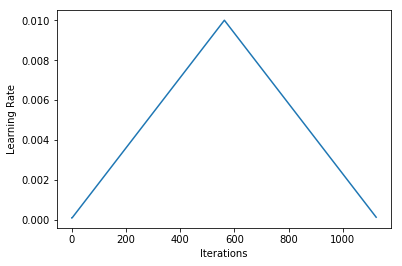

In [522]:
learn.recorder.plot_lr()

In [29]:
from cleanup import cleanup_models_folder
cleanup_models_folder('/root/Derakhshani/adversarial/models')

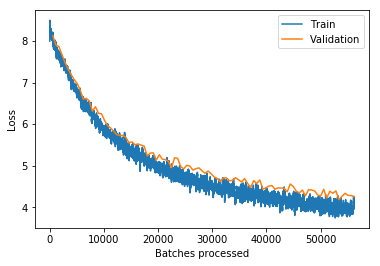

In [40]:
learn.recorder.plot_losses()

In [ ]:
#plot histogram
fig, axes = plt.subplots(len(hooks),1, figsize=(30,12))
for ax,h in zip(axes.flatten(), hooks):
  ax.imshow(get_hist(h), origin='lower')
  ax.axis('off')
plt.tight_layout()

In [ ]:
# plot mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms[:100])
  ax1.plot(ss[:100])
plt.legend(range(len(hooks)))

In [ ]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms)
  ax1.plot(ss)
plt.legend(range(len(hooks)))

In [ ]:
# zero precentage:
fig,axes = plt.subplots(len(hooks),1, figsize=(30,30))
for ax,h in zip(axes.flatten(), hooks):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [ ]:
# z1 = torch.empty(10).uniform_(-1,1).cuda()
# z2 = torch.empty(10).uniform_(-1,1).cuda()
z1 = torch.tensor([0.8, -0.5] * 5).cuda()
z2 = torch.tensor([-1.] * 10).cuda()
print("z1: ", z1)
print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.1)
print(len(z_s))

for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  #img.save('./pics/' + str(i) + '.png')

In [52]:
# idea : have 200 noises (1 for each class), then start iterating the dataset, and for each image, randomly apply one noise and record the result
def targeted_diversity(learn, n_perturbations = 200, percentage = 95):
  model = learn.model.eval()

  one_hot_conditions = [torch.empty(z_dim).uniform_(0,1).cuda().detach() for _ in range(n_perturbations)]
#   for i in range(z_dim):
#     one_hot_conditions[i][i] = 1.

  perturbations = [model.forward_single_z(z) for z in one_hot_conditions]

  hist = [0.] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 : print("at batch_no {}".format(batch_no))
    perturbed_batch = batch + perturbations[np.random.randint(0,len(perturbations))][None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      hist[pred] += 1

  pred_histogram_sum = np.sum(hist)
  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(hist)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram

def targeted_diversity_average(learn, n_perturbations = 200, percentage = 95, average_over = 4):
  results = []
  for i in range(average_over):
    n, _ = targeted_diversity(learn, n_perturbations, percentage)
    print(f'done with the {i}th calculation: {n}')
    results.append(n)
  return np.mean(results)

def diversity_average(learn, n_perturbations = 10, percentage = 95, average_over = 4):
  results = []
  for i in range(average_over):
    n, _ = diversity(learn, n_perturbations, percentage, verbose = False)
    print(f'done with the {i}th calculation: {n}')
    results.append(n)
  return np.mean(results)

In [59]:
n, hist = diversity(learn, 10, 95)
n, hist

at batch no 0
at batch no 5
at batch no 10
at batch no 15
at batch no 20
at batch no 25
at batch no 30
at batch no 35
at batch no 40
at batch no 45
at batch no 50
at batch no 55
at batch no 60
finished creating the prediction histogram


(566,
 [(794, 50.099998474121094),
  (599, 21.100000381469727),
  (668, 20.200000762939453),
  (904, 15.0),
  (973, 13.600000381469727),
  (490, 12.899999618530273),
  (39, 12.699999809265137),
  (770, 12.600000381469727),
  (741, 11.300000190734863),
  (828, 11.100000381469727),
  (109, 9.199999809265137),
  (556, 8.600000381469727),
  (489, 8.399999618530273),
  (955, 8.399999618530273),
  (887, 8.300000190734863),
  (669, 8.100000381469727),
  (84, 7.400000095367432),
  (855, 7.0),
  (538, 6.800000190734863),
  (108, 6.599999904632568),
  (124, 6.0),
  (397, 5.900000095367432),
  (48, 5.800000190734863),
  (61, 5.5),
  (777, 4.900000095367432),
  (721, 4.800000190734863),
  (401, 4.5),
  (971, 4.400000095367432),
  (893, 4.300000190734863),
  (857, 4.099999904632568),
  (591, 4.0),
  (711, 3.9000000953674316),
  (709, 3.799999952316284),
  (455, 3.700000047683716),
  (55, 3.5999999046325684),
  (414, 3.5),
  (906, 3.5),
  (151, 3.4000000953674316),
  (389, 3.4000000953674316),
  (40

In [207]:
results_1 = []
for n_pert in range(10, 110, 10):
  n = targeted_diversity_average(learn, n_pert, 95, 4)
  print(f'result for n_pert: {n_pert} is {n}')
  results_1.append(n)

at batch_no 0
done with the 0th calculation: 717
at batch_no 0
done with the 1th calculation: 718
at batch_no 0
done with the 2th calculation: 720
at batch_no 0
done with the 3th calculation: 718
result for n_pert: 10 is 718.25
at batch_no 0
done with the 0th calculation: 713
at batch_no 0
done with the 1th calculation: 724
at batch_no 0
done with the 2th calculation: 715
at batch_no 0
done with the 3th calculation: 719
result for n_pert: 20 is 717.75
at batch_no 0
done with the 0th calculation: 712
at batch_no 0
done with the 1th calculation: 722
at batch_no 0
done with the 2th calculation: 720
at batch_no 0
done with the 3th calculation: 717
result for n_pert: 30 is 717.75
at batch_no 0
done with the 0th calculation: 716
at batch_no 0
done with the 1th calculation: 717
at batch_no 0
done with the 2th calculation: 713
at batch_no 0
done with the 3th calculation: 714
result for n_pert: 40 is 715.0
at batch_no 0
done with the 0th calculation: 717
at batch_no 0
done with the 1th calculat

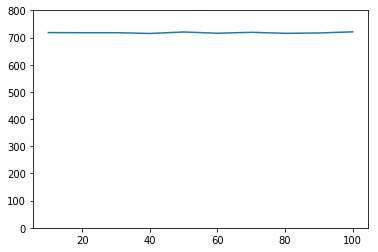

In [209]:
x = list(range(10, 110, 10))
plt.ylim(0, 800)
plt.plot(x, results_1)

In [204]:
results = []
for n_pert in range(10, 110, 10):
  n = diversity_average(learn, n_pert, 95, 3)
  print(f'result for n_pert: {n_pert} is {n}')
  results.append(n)

finished creating the prediction histogram
done with the 0th calculation: 548
finished creating the prediction histogram
done with the 1th calculation: 524
finished creating the prediction histogram
done with the 2th calculation: 519
result for n_pert: 10 is 530.3333333333334
finished creating the prediction histogram
done with the 0th calculation: 524
finished creating the prediction histogram
done with the 1th calculation: 546
finished creating the prediction histogram
done with the 2th calculation: 518
result for n_pert: 20 is 529.3333333333334
finished creating the prediction histogram
done with the 0th calculation: 561
finished creating the prediction histogram
done with the 1th calculation: 543
finished creating the prediction histogram
done with the 2th calculation: 523
result for n_pert: 30 is 542.3333333333334
finished creating the prediction histogram
done with the 0th calculation: 571
finished creating the prediction histogram
done with the 1th calculation: 548
finished crea

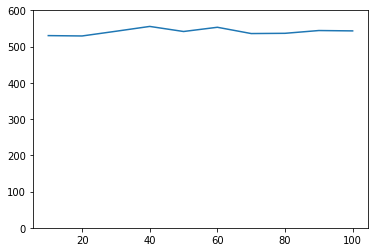

In [206]:
x = list(range(10, 110, 10))
plt.ylim(0, 600)
plt.plot(x, results)

In [219]:
#targeted:
targeted_div_metrics = results_1
div_metrics = results

#non-targeted:
n_targeted_div_metrics = [244.0, 247.0, 265.3333333333333, 246.66666666666666, 241.0, 231.33333333333334, 
                          247.66666666666666, 229.0, 222.33333333333334, 236.0]
n_div_metrics = [132, 118, 122, 135, 133, 129, 136, 132, 124, 143]

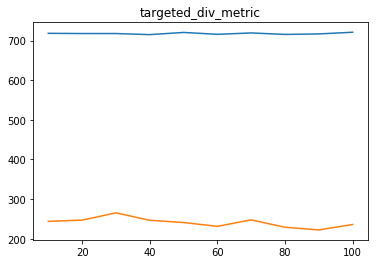

In [220]:
plt.plot(x, targeted_div_metrics)
plt.plot(x, n_targeted_div_metrics)
plt.title('targeted_div_metric')
plt.show()

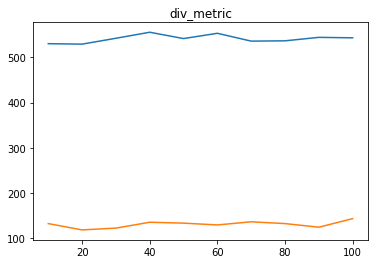

In [221]:
plt.plot(x, div_metrics)
plt.plot(x, n_div_metrics)
plt.title('div_metric')
plt.show()

In [30]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist 

In [29]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist 

In [28]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist

at batch no 0
at batch no 5
at batch no 10
at batch no 15
at batch no 20
at batch no 25
at batch no 30
at batch no 35
at batch no 40
at batch no 45
at batch no 50
at batch no 55
at batch no 60
finished creating the prediction histogram


(364,
 [(721, 143.20),
  (750, 49.40),
  (971, 48.40),
  (794, 47.10),
  (431, 35.10),
  (669, 35.10),
  (414, 30.60),
  (588, 28.40),
  (520, 24.90),
  (61, 24.20),
  (904, 18.30),
  (411, 14.30),
  (828, 13.50),
  (39, 11.70),
  (556, 11.40),
  (581, 9.20),
  (651, 8.30),
  (489, 7.80),
  (599, 6.60),
  (84, 5.50),
  (572, 4.80),
  (907, 4.70),
  (987, 4.40),
  (401, 4.30),
  (490, 4.30),
  (614, 4.30),
  (60, 4.00),
  (955, 3.50),
  (711, 3.30),
  (48, 3.20),
  (691, 3.10),
  (709, 3.00),
  (419, 2.90),
  (770, 2.90),
  (815, 2.90),
  (864, 2.80),
  (879, 2.80),
  (108, 2.70),
  (441, 2.70),
  (632, 2.70),
  (56, 2.50),
  (604, 2.50),
  (55, 2.40),
  (464, 2.30),
  (549, 2.30),
  (575, 2.20),
  (893, 2.20),
  (973, 2.20),
  (96, 2.10),
  (496, 2.10),
  (518, 2.10),
  (412, 2.00),
  (641, 2.00),
  (762, 2.00),
  (801, 2.00),
  (872, 2.00),
  (858, 1.90),
  (871, 1.90),
  (580, 1.80),
  (621, 1.80),
  (746, 1.80),
  (806, 1.80),
  (46, 1.70),
  (151, 1.70),
  (171, 1.70),
  (633, 1.70

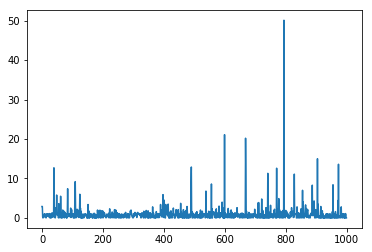

In [60]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [61]:
entropy(values)

tensor(8.6468)

In [97]:
#on test
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = targeted_diversity(learn, 10, 95)
n, hist 

at batch_no 0
at batch_no 100
at batch_no 200
at batch_no 300
at batch_no 400
at batch_no 500
at batch_no 600
at batch_no 700
at batch_no 800
at batch_no 900
at batch_no 1000
at batch_no 1100
at batch_no 1200
at batch_no 1300
at batch_no 1400
at batch_no 1500
at batch_no 1600
at batch_no 1700
at batch_no 1800
at batch_no 1900
at batch_no 2000
at batch_no 2100
at batch_no 2200
at batch_no 2300
at batch_no 2400
at batch_no 2500
at batch_no 2600
at batch_no 2700
at batch_no 2800
at batch_no 2900
at batch_no 3000
at batch_no 3100


(885,
 [(815, 234.00),
  (652, 177.00),
  (646, 163.00),
  (580, 160.00),
  (611, 156.00),
  (489, 145.00),
  (591, 144.00),
  (621, 141.00),
  (737, 139.00),
  (904, 130.00),
  (94, 129.00),
  (868, 127.00),
  (582, 125.00),
  (497, 123.00),
  (893, 120.00),
  (794, 118.00),
  (116, 115.00),
  (955, 115.00),
  (979, 114.00),
  (679, 112.00),
  (721, 109.00),
  (39, 108.00),
  (565, 108.00),
  (741, 106.00),
  (491, 105.00),
  (562, 103.00),
  (839, 102.00),
  (109, 101.00),
  (162, 101.00),
  (549, 99.00),
  (46, 97.00),
  (48, 96.00),
  (84, 95.00),
  (750, 95.00),
  (82, 94.00),
  (973, 94.00),
  (151, 93.00),
  (492, 93.00),
  (695, 93.00),
  (199, 91.00),
  (843, 89.00),
  (51, 88.00),
  (971, 88.00),
  (640, 87.00),
  (424, 86.00),
  (669, 86.00),
  (692, 86.00),
  (879, 86.00),
  (281, 85.00),
  (47, 84.00),
  (783, 84.00),
  (203, 83.00),
  (310, 83.00),
  (382, 83.00),
  (411, 83.00),
  (866, 83.00),
  (743, 82.00),
  (364, 81.00),
  (577, 81.00),
  (197, 80.00),
  (318, 80.00

In [98]:
#on test
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = targeted_diversity(learn, 10, 95)
n, hist 

at batch_no 0
at batch_no 100
at batch_no 200
at batch_no 300
at batch_no 400
at batch_no 500
at batch_no 600
at batch_no 700
at batch_no 800
at batch_no 900
at batch_no 1000
at batch_no 1100
at batch_no 1200
at batch_no 1300
at batch_no 1400
at batch_no 1500
at batch_no 1600
at batch_no 1700
at batch_no 1800
at batch_no 1900
at batch_no 2000
at batch_no 2100
at batch_no 2200
at batch_no 2300
at batch_no 2400
at batch_no 2500
at batch_no 2600
at batch_no 2700
at batch_no 2800
at batch_no 2900
at batch_no 3000
at batch_no 3100


(885,
 [(815, 239.00),
  (652, 181.00),
  (646, 168.00),
  (580, 163.00),
  (611, 155.00),
  (591, 148.00),
  (737, 143.00),
  (489, 142.00),
  (621, 139.00),
  (904, 134.00),
  (794, 130.00),
  (497, 127.00),
  (893, 127.00),
  (582, 125.00),
  (94, 123.00),
  (955, 120.00),
  (116, 115.00),
  (868, 115.00),
  (39, 112.00),
  (679, 112.00),
  (565, 110.00),
  (162, 109.00),
  (491, 108.00),
  (721, 108.00),
  (979, 108.00),
  (741, 105.00),
  (839, 105.00),
  (109, 104.00),
  (562, 104.00),
  (84, 103.00),
  (549, 102.00),
  (48, 99.00),
  (82, 99.00),
  (492, 99.00),
  (51, 98.00),
  (973, 96.00),
  (199, 95.00),
  (750, 95.00),
  (46, 93.00),
  (640, 92.00),
  (695, 92.00),
  (151, 88.00),
  (971, 88.00),
  (783, 87.00),
  (843, 87.00),
  (203, 86.00),
  (669, 86.00),
  (692, 86.00),
  (424, 84.00),
  (956, 84.00),
  (281, 83.00),
  (577, 83.00),
  (828, 82.00),
  (866, 82.00),
  (47, 81.00),
  (310, 81.00),
  (743, 81.00),
  (847, 81.00),
  (61, 80.00),
  (208, 80.00),
  (703, 80.0

In [99]:
#on test
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = targeted_diversity(learn, 10, 95)
n, hist 

at batch_no 0
at batch_no 100
at batch_no 200
at batch_no 300
at batch_no 400
at batch_no 500
at batch_no 600
at batch_no 700
at batch_no 800
at batch_no 900
at batch_no 1000
at batch_no 1100
at batch_no 1200
at batch_no 1300
at batch_no 1400
at batch_no 1500
at batch_no 1600
at batch_no 1700
at batch_no 1800
at batch_no 1900
at batch_no 2000
at batch_no 2100
at batch_no 2200
at batch_no 2300
at batch_no 2400
at batch_no 2500
at batch_no 2600
at batch_no 2700
at batch_no 2800
at batch_no 2900
at batch_no 3000
at batch_no 3100


(885,
 [(815, 227.00),
  (652, 183.00),
  (646, 172.00),
  (580, 155.00),
  (591, 149.00),
  (621, 148.00),
  (737, 148.00),
  (611, 147.00),
  (489, 136.00),
  (904, 129.00),
  (497, 125.00),
  (868, 125.00),
  (979, 124.00),
  (582, 122.00),
  (794, 122.00),
  (94, 118.00),
  (955, 118.00),
  (893, 117.00),
  (721, 116.00),
  (116, 114.00),
  (491, 108.00),
  (565, 108.00),
  (741, 107.00),
  (562, 106.00),
  (679, 106.00),
  (39, 105.00),
  (839, 104.00),
  (109, 102.00),
  (162, 101.00),
  (750, 100.00),
  (46, 98.00),
  (695, 98.00),
  (549, 97.00),
  (82, 95.00),
  (199, 95.00),
  (492, 95.00),
  (84, 94.00),
  (973, 94.00),
  (51, 93.00),
  (151, 91.00),
  (48, 90.00),
  (424, 89.00),
  (843, 89.00),
  (203, 87.00),
  (692, 87.00),
  (971, 87.00),
  (640, 86.00),
  (669, 86.00),
  (197, 84.00),
  (440, 84.00),
  (879, 84.00),
  (47, 83.00),
  (180, 83.00),
  (577, 83.00),
  (208, 81.00),
  (743, 81.00),
  (783, 81.00),
  (847, 81.00),
  (189, 80.00),
  (281, 80.00),
  (382, 80.0

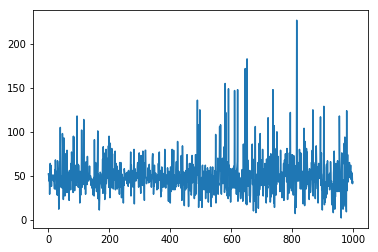

In [100]:
# on test
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [101]:
#on test
entropy(values)

tensor(9.8493)

In [ ]:
def make_triplet_samples(z, margin, r2, r3):
  positive_sample = z + random_vector_volume(z.shape, 0, margin).cuda() 
  negative_sample = z + random_vector_volume(z.shape, r2, r3).cuda()
  return positive_sample, negative_sample

def random_vector_surface(shape, r = 1.):
  mat = torch.randn(size=shape).cuda()
  norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
  return (mat/norm) * r

def random_vector_volume(shape, inner_r, outer_r):
  fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
  fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
  fraction.unsqueeze_(-1)
  return random_vector_surface(shape, 1) * fraction

In [ ]:
from collections import Counter

def most_frequent(x):
  return Counter(x).most_common(1)[0]

def preds_around(center, radius, n_preds, model, dummy_img):
  z_s = random_vector_volume([n_preds, 10], radius, radius + 0.01) + center[None]
  noises = model.forward_z(z_s)
  perturbed_imgs = noises + dummy_img 
  return torch.argmax(arch(perturbed_imgs), 1)
  
def most_freq_pred_around(center, radius, n_preds, model, dummy_img):
  preds = preds_around(center, radius, n_preds, model, dummy_img)
  most_freq = most_frequent(preds.tolist())
  return (class_index_to_label(most_freq[0]), most_freq[1]/n_preds)

def investigate_neighborhood(z, step, model, dummy_img):
  with torch.no_grad():
    result = []
    for radius in np.arange(0.1, 6., step):
#       print("creating {} more preds".format(int(10 + 5 * (radius ** 2))))
      most_freq_pred = most_freq_pred_around(z, radius, int(10 + 5 * (radius ** 2)), model, dummy_img)
      result.append((radius, most_freq_pred))
    return result

In [ ]:
#experiment 1

z = torch.tensor([0.5] * 10).cuda()
# z = torch.empty(10).uniform_(-1, 1).cuda()
# z_s = z[None]

model = learn.model.eval()
x_img = normalize(learn.data.train_ds[50][0].data.cuda())
  
for i in range(6):
  z = torch.empty(10).uniform_(-1, 1).cuda()
  print("investigation for: ", z)
  for elem in investigate_neighborhood(z, 0.5, model, x_img):
    print(elem)
print("done")

In [ ]:
#experiment 1-1: modified investigate_z
z_investigate_path = '/root/Derakhshani/adversarial/textual_notes/investigate_z_{}.txt'.format(env.save_filename)
if Path(z_investigate_path).exists(): raise FileExistsError("file already exists")
file = open(str(z_investigate_path), 'w')
        
for i, (z, noise) in enumerate(zip(pruned_z_s, pruned_noises)):
  hist = compute_prediction_histogram(learn, noise)
  indexed_hist = [(i, val) for i, val in enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse=True)
  labeled_hist = [(class_index_to_label(i), count) for i, count in sorted_hist]
  print("result {}:".format(i))
  print(big_vector_to_str(z))
  print(labeled_hist[:6])
  print("\n\n")
  
  file.write("result {}:\n".format(i))
  file.write(big_vector_to_str(z) + "\n")
  file.write(str(labeled_hist[:6]))
  file.write("\n\n\n")
  file.flush()

In [ ]:
#experiment 2
import itertools
z_s = [torch.tensor(t).cuda() for t in itertools.product( *([[-0.33, 0.33]] * 10) )]
model = learn.model.eval()
noises = []
with torch.no_grad():
  for z in z_s:
    noises.append(model.forward_single_z(z))

In [ ]:
x_img = normalize(learn.data.train_ds[50][0].data.cuda())

preds = []
for noise in noises:
  perturbed_img = x_img + noise
  preds.append(torch.argmax(arch(perturbed_img[None]), 1)[0].item())

from collections import Counter
result = [(class_index_to_label(index), count) for index, count in Counter(preds).most_common(5)]
result

In [ ]:
#experiment 3
import itertools
dimension_values = [[-0.9, 0.9]] * z_dim
for i in range(z_dim):
  if i % 100 != 0:
    dimension_values[i] = [0.]
# dimension_values[0] = [0.]
# dimension_values[3] = [0.]
# dimension_values[6] = [0.]
# dimension_values[9] = [0.]
pruned_z_s = [torch.tensor(t).cuda() for t in itertools.product(*dimension_values)]
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3: for the targeted-attack case
pruned_z_s = []
for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3-1: noises for 
pruned_z_s = []
# for i in range(z_dim):
#   new_z = torch.empty(z_dim).uniform_(0,1).cuda().detach()
#   pruned_z_s.append(new_z)

for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda().detach()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
for noise in pruned_noises[0:200]:
  img = noise_to_image(noise)
  img.show()

In [ ]:
# spider web
z_values = [
  [ 0.33, -0.33,  0.33,  0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33],
  [-0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33],
  [-0.33,  0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33,  0.33,  0.33],
  [-0.33,  0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33],
  [ 0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33, -0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33, -0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()


In [ ]:
z_values = [
  # window screen
  [-0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()

In [ ]:
#vgg-16_12 most repeated labels:
l = [(611, 215.0),
  (474, 194.1),
  (398, 120.3),
  (721, 79.6),
  (741, 73.5),
  (510, 62.5)]

[(class_index_to_label(index), count) for index, count in l]

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [ ]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[200][0]
x = normalize(x_img.data.cuda())
z = torch.tensor([-0.33,  0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33], dtype=torch.float32).cuda()
# z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()

p_x = x + p
# print("img range, noise range")
# print_range(x); print_range(p)
adv_label = class_index_to_label(arch(p_x[None]).argmax(1).item())
print_big_vector(arch(p_x[None])[0])
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()


# print_range(p)
# print_range(denormalize(x))
# print_range(p_x)

benign_label = class_index_to_label(arch(x[None]).argmax(1).item())

print_big_vector(arch(x[None])[0])
print(benign_label, adv_label)

In [ ]:
z1 = torch.tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p1 = model.forward_single_z(z1)

z2 = torch.tensor([1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p2 = model.forward_single_z(z2)

z3 = torch.tensor([1, 1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p3 = model.forward_single_z(z3)

l2_distance(p1, p3)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)